In [50]:
import os
import json
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.dates as mdates
from scipy.stats import norm

In [51]:
# Data reader
def getData(ticker):
    # todays date
    current_dateTime = datetime.now()
    
    # Retrive info
    asset = yf.Ticker(ticker)

    # Need to call first to be able to acess start date
    hist = asset.history(period="max")

    start_date = var.history_metadata['firstTradeDate']
    data = yf.download(ticker, start = start_date, end = current_dateTime)

    # Calculate log of close price and percentage change for later use
    data['Log Close'] = np.log(data['Close'])
    data['Percentage'] = data['Close']/data['Open']
    
    # Return dataframe
    return data

# Load asset names
with open('config.json') as file:
    data = json.load(file)

In [52]:
def largestDrawDown(df):
# find worst possible drawdown:
    drawDowns=[]
    #print(len(df))
    for i in range(len(df)):
       if i == (len(df)-1):
           break
       else:
           v1=df['Close'].iloc[i]
           loss=True ; count = i ; DD=0. ; top=0.
           while loss:
               try:
                   count+=1
                   v2=df['Close'].iloc[count]
                   if v2<v1:
                       drawDowns.append([DD,i+1,count,top+1])
                       loss=False
                   else:
                       var= 100.*(v2/v1)
                       if var>DD:
                           DD=var
                           top=count
                       else:
                           pass
               except:
                   loss=False
    orderedDD=sorted(drawDowns,key = lambda x:x[0])
    return orderedDD

In [53]:
def Insetplotter(x,y,name,DD,percentSet,xshift,yshift,left,bottom,width,height,loc1,loc2):
    #Plot price against time
    plt.figure(1,[10,5])
    DDstart = DD[-1][1] ; DDend = DD[-1][2]
    plt.plot(x,y,'k.-')
    #plt.scatter(DDstart,y[DDstart],s=20, facecolors='none', edgecolors='r')
    plt.plot(DDstart,y[DDstart],'ro',markersize=40,fillstyle='none')
    #plt.arrow(1500,15000,750,-11500,color='r')
    plt.axis([0, len(x), 1.1*np.amin(y), np.amax(y)])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.xlabel('Days since inception',fontsize=30)
    plt.ylabel('$',fontsize=40)
    plt.xlim(0.,len(x))
    
    plt.title(name,fontsize=20)
     
    #Plot inset of logged version with fit line
    DDstart = DD[-1][1] ; DDend = DD[-1][-1]
    xx=x[DDstart-20:DDend+20] ; yy=y[DDstart-20:DDend+20]
    a= plt.axes([0.2+left,0.25+bottom,0.7+width,0.55+height])    # [left,bottom,width,height]
    plt.plot(xx,yy,'k.-')
    
    plt.plot([DDstart,DDstart],[np.amin(yy)*0.95,np.amax(yy)*1.05],'r:')
    plt.plot([DDend,DDend],[np.amin(yy)*0.95,np.amax(yy)*1.05],'r:')
    plt.ylim(np.amin(yy)*0.95,np.amax(yy)*1.05)
    plt.xlim(xx[0],xx[-1])
    l1='Max Drawdown = '+str(round(DD[-1][0],2))+'%'
    plt.text(DDstart+xshift,np.amin(yy)+yshift,l1,fontsize=10)
    #plt.savefig('plots//'+'DD '+name+'.png',bbox_inches="tight")
    #plt.tight_layout()
    plt.show()
    
    def distributionPlot(percentSet,name,loc1,loc2):
        # Histogram of daily percentage movments
        percentSet=(percentSet-1.)*100.
        #Plot params
        fig= plt.figure(1,[10,10])
        ax = fig.add_subplot(1, 1, 1)
        ax.tick_params(axis='both', which='major', labelsize=20)
        var= ax.hist(percentSet,bins=200)
        plotHeight=sorted(var[0])
        plotWidth=sorted(var[1])
        plt.xlabel('Daily movment (%)',fontsize=20)
        plt.ylabel('Frequency',fontsize=20)
        plt.ylim(plotHeight[0],plotHeight[-1])
        plt.title(name,fontsize=40)
        # Stats
        mean,std=norm.fit(percentSet)
        std1=[std,std] ;std2=[2*std,2*std];std3=[3*std,3*std]
        Nstd1=[(-std+mean),(-std+mean)] ;Nstd2=[2*(-std+mean),2*(-std+mean)];Nstd3=[3*(-std+mean),3*(-std+mean)]
        aveX=[mean,mean]; aveY=[0,plotHeight[-1]+5]
        #plot and save
        plt.plot(aveX,aveY,'k--',linewidth=2)
        plt.plot(std1,aveY,'r:',linewidth=2)
        plt.plot(std2,aveY,'r:',linewidth=2)
        plt.plot(std3,aveY,'r:',linewidth=2)
        plt.plot(Nstd1,aveY,'r:',linewidth=2)
        plt.plot(Nstd2,aveY,'r:',linewidth=2)
        plt.plot(Nstd3,aveY,'r:',linewidth=2)
        m='Mean ='+str(round(mean,4))+'%'
        s='STD ='+str(round(std,4))+'%'
        plt.text(loc1[0],loc1[1],m,fontsize=20)
        plt.tight_layout()
        plt.text(loc2[0],loc2[1],s,fontsize=20)
        #plt.savefig('plots//'+name+'Distribution'+'.png',bbox_inches="tight")
        plt.show()
        
    distributionPlot(percentSet,name,loc1,loc2)

    
def logPlot(x,y,name):

    fig= plt.figure(5,[20,10])
    ax = fig.add_subplot(1, 1, 1)
    #plt.plot(x,y,'b.-')
    #lx=np.log10(cp)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

    string1='f(y)= '+str(round(slope,4))+'*x'+' +'+str(round(intercept,4))
    xFit=np.linspace(0,len(x),num=len(x))
    yFit=slope*xFit+intercept
    ax.plot(x,y,'k.-',label='Log(y) vs x')
    ax.plot(xFit,yFit,'b.-',label=string1)
    plt.legend(prop={'size': 24})
    #ax.set_xlim(0,xlim)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.xlabel('Days since inception',fontsize=30)
    plt.ylabel('Log(Price)',fontsize=30)
    plt.tight_layout()
    plt.title(name,fontsize=20)
    #plt.savefig('plots//'+'log'+name+'.png',bbox_inches="tight")
    plt.show()
    

SH
[*********************100%***********************]  1 of 1 completed


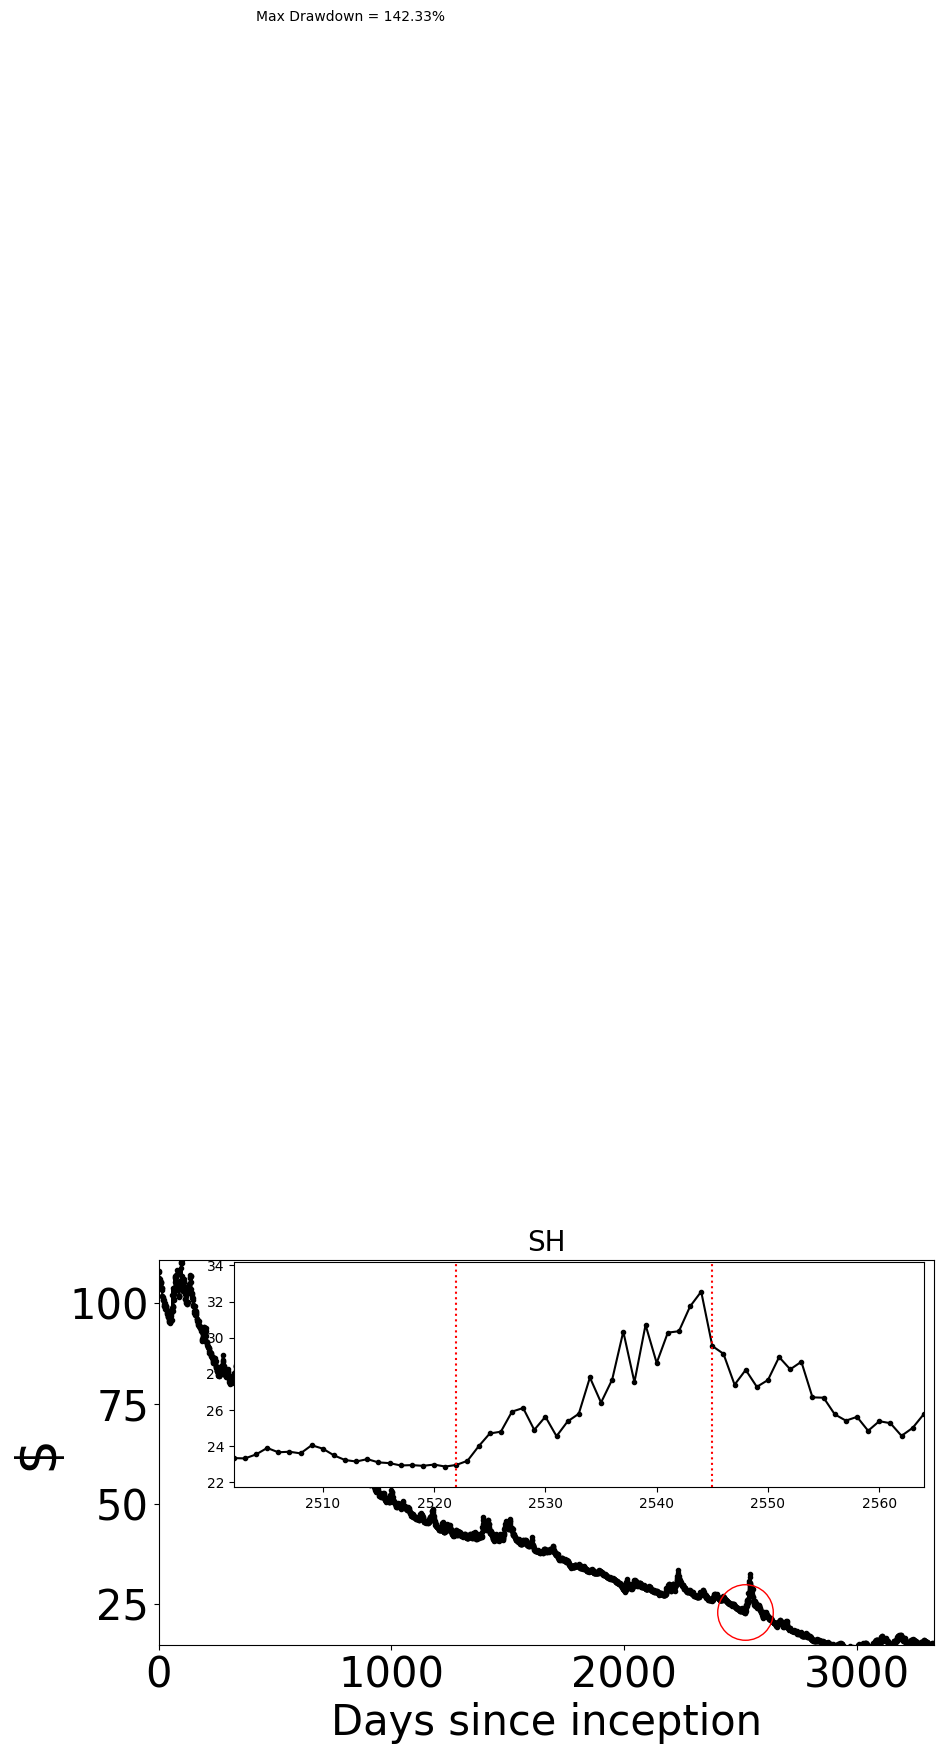

C:\Users\Scott\AppData\Local\Temp\ipykernel_4988\4208330821.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


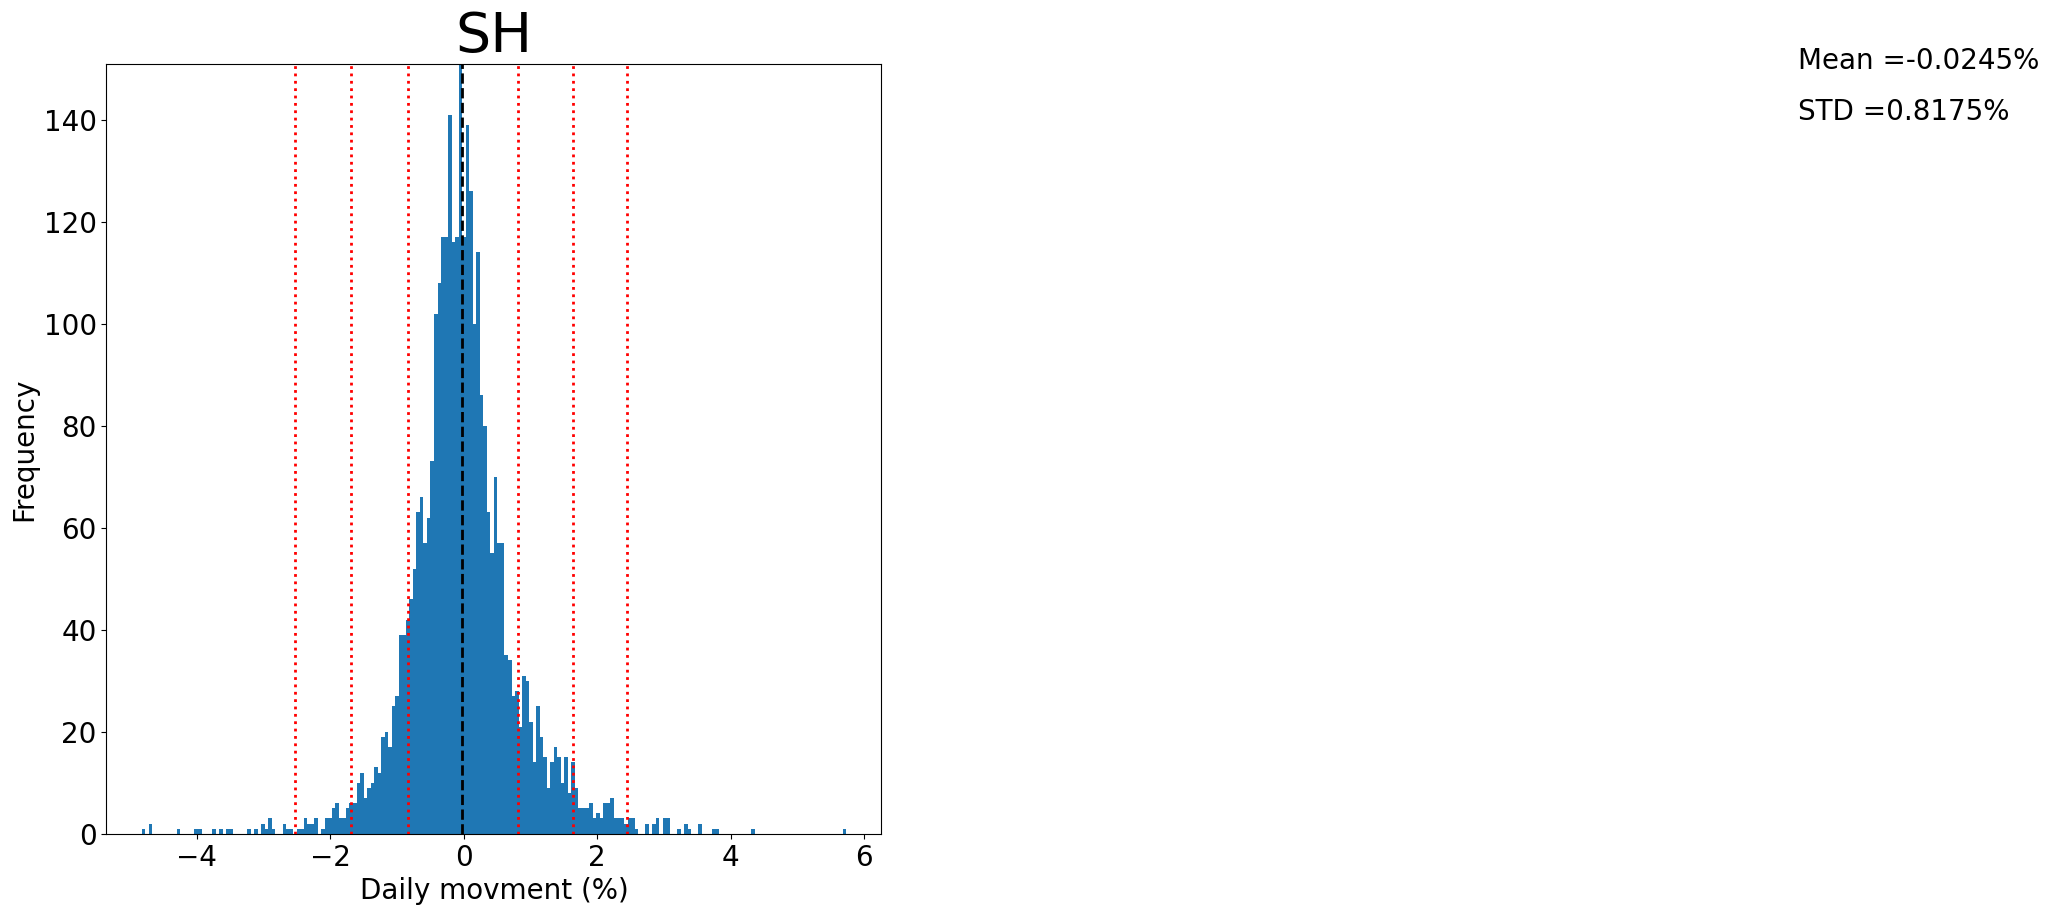

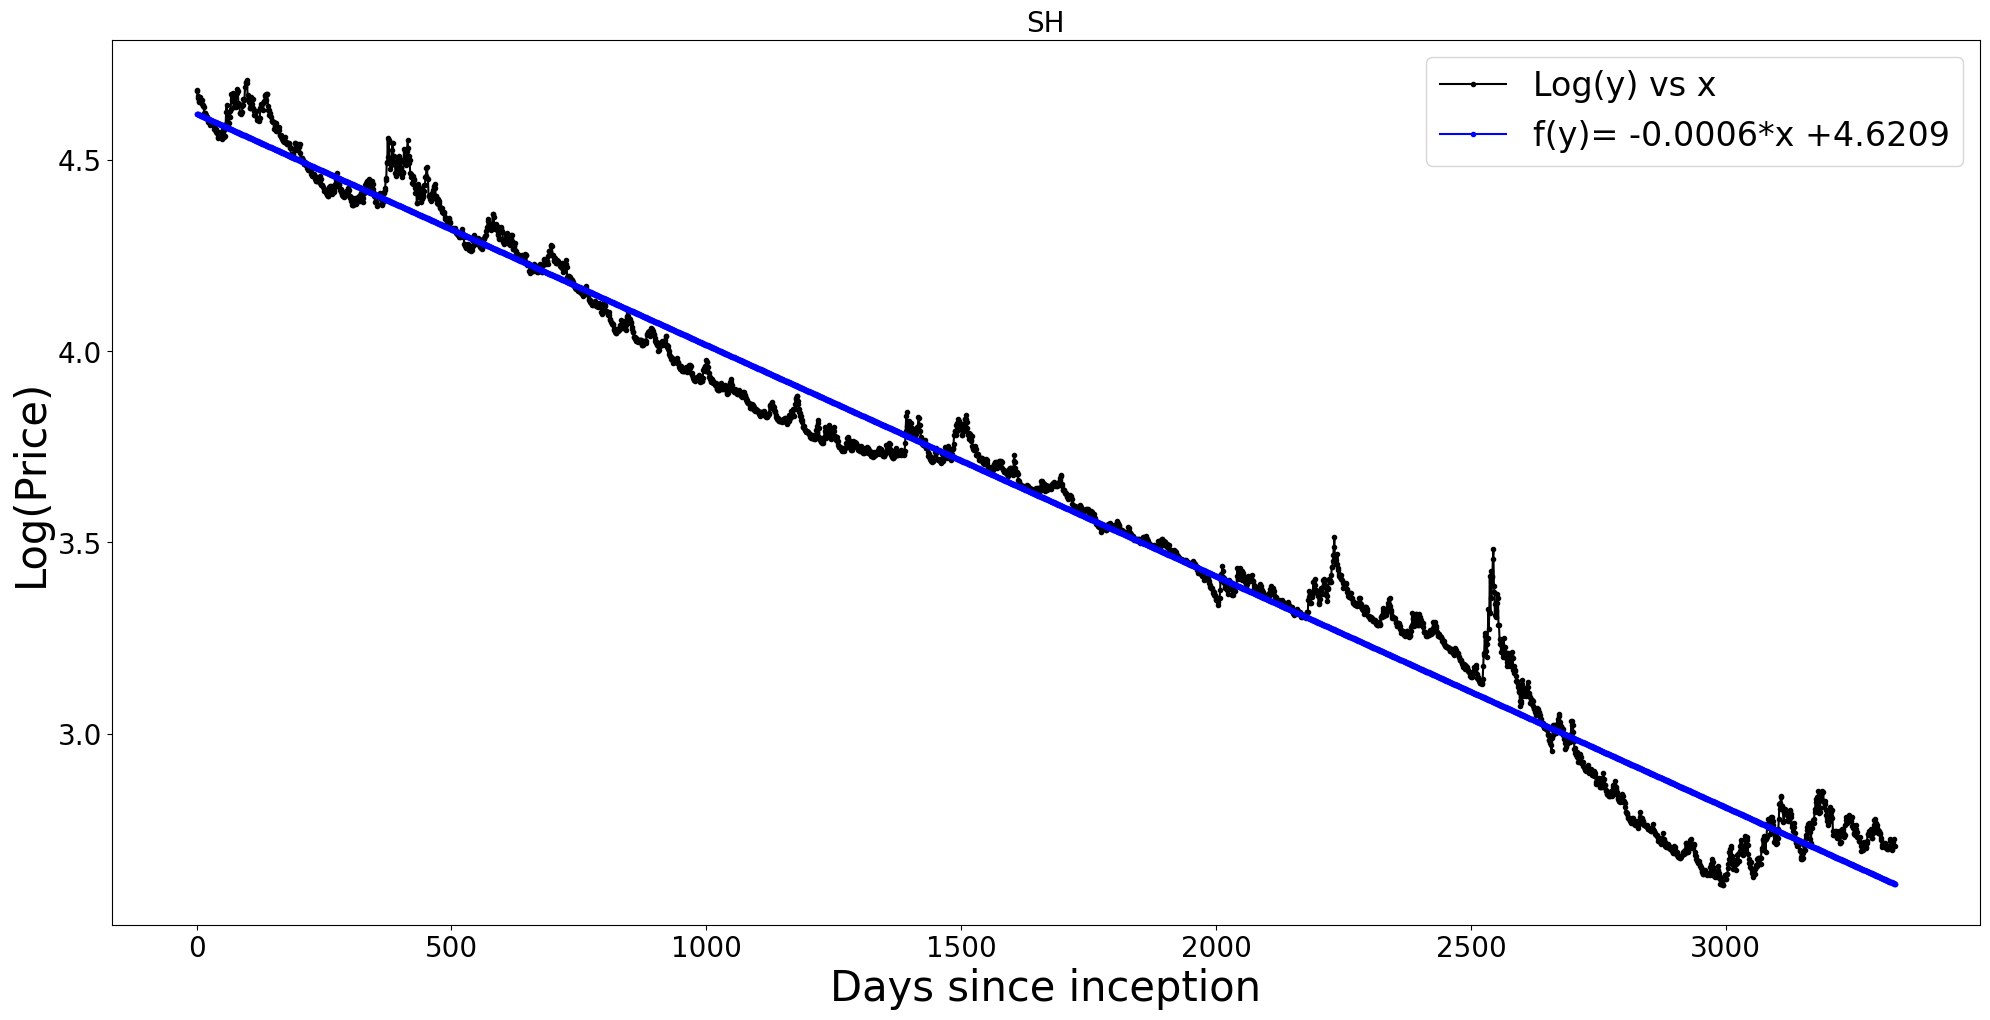

SDS
[*********************100%***********************]  1 of 1 completed


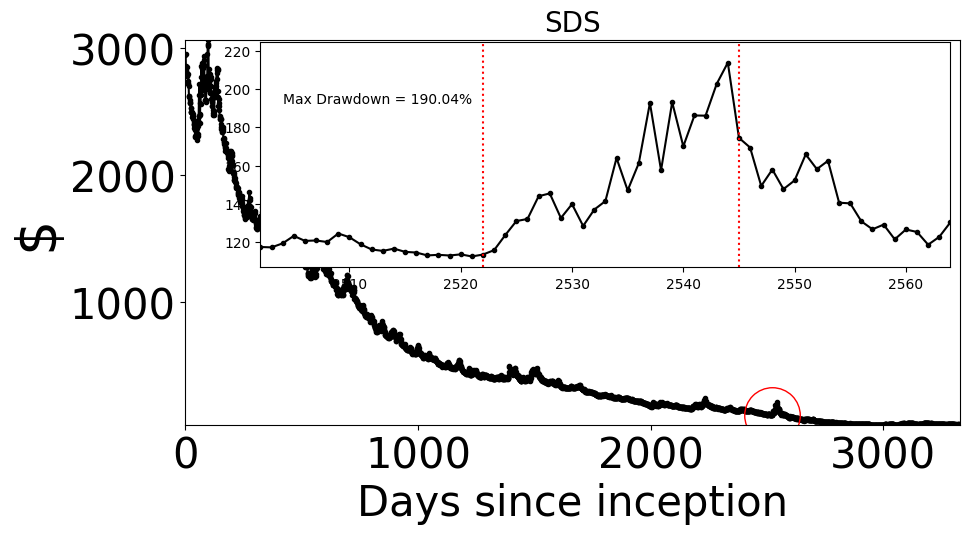

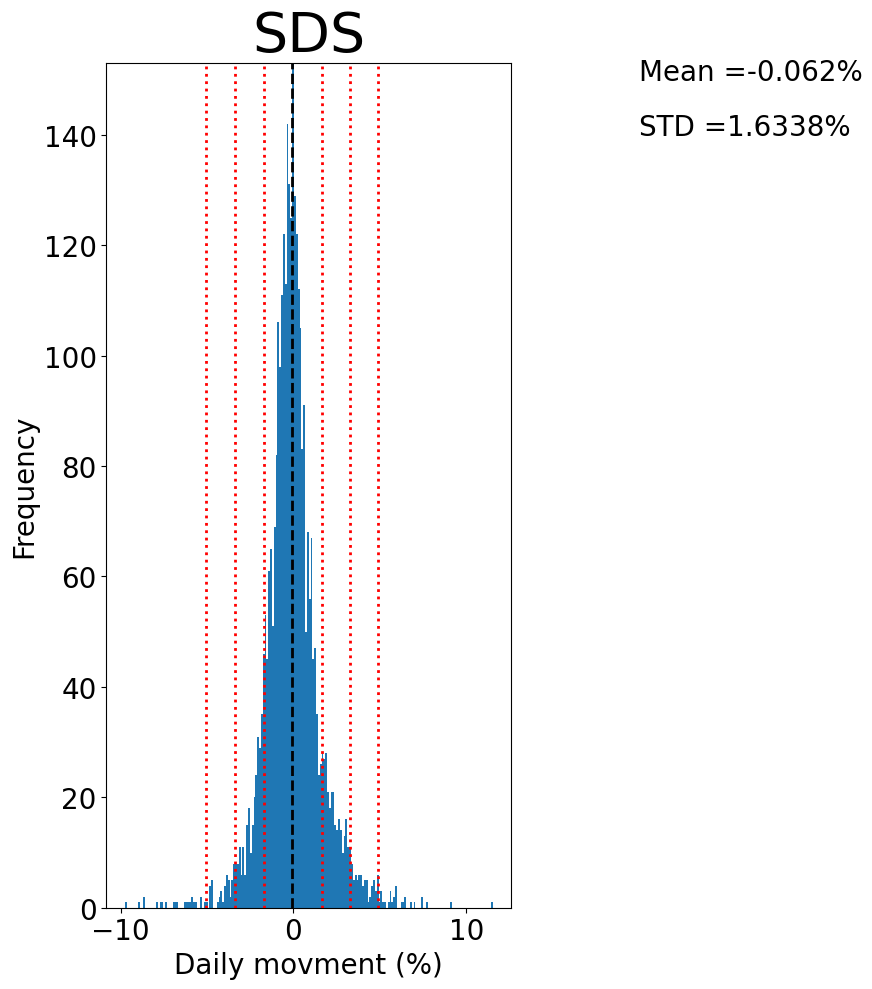

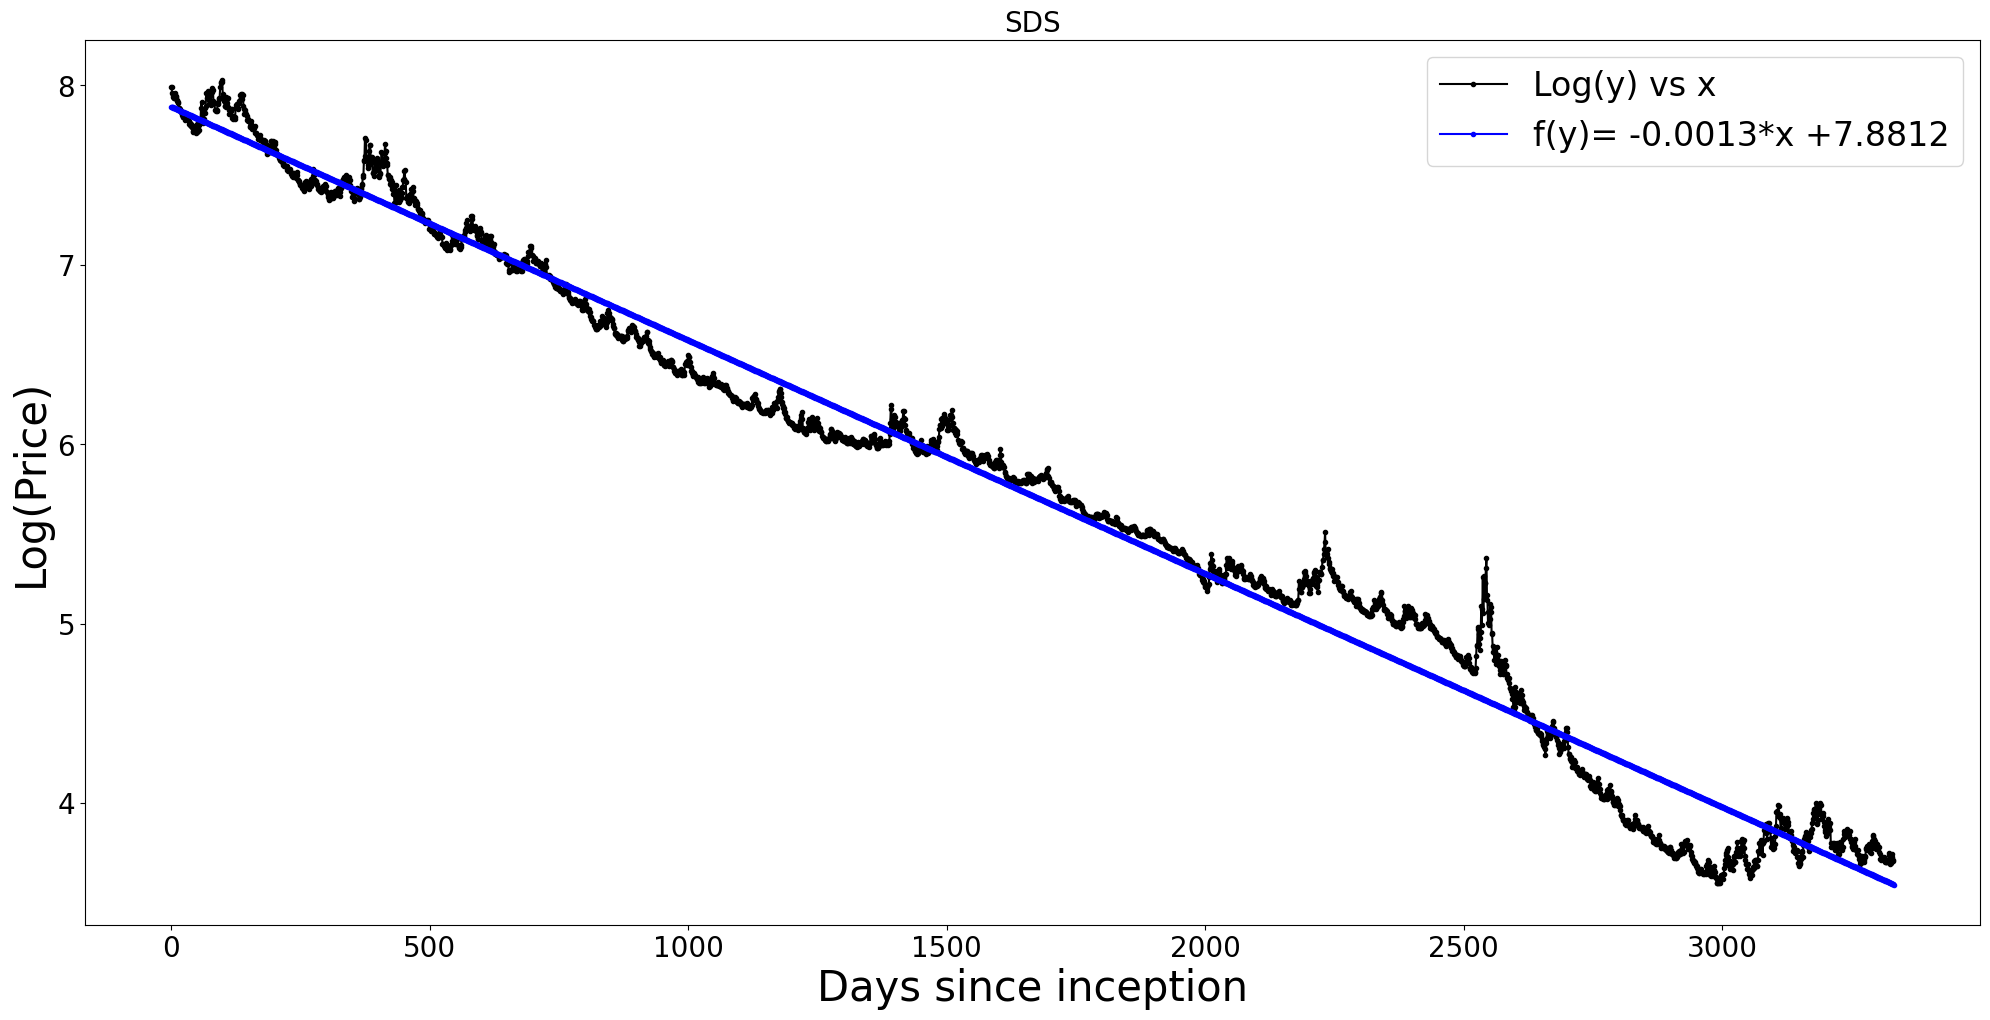

SPXS
[*********************100%***********************]  1 of 1 completed


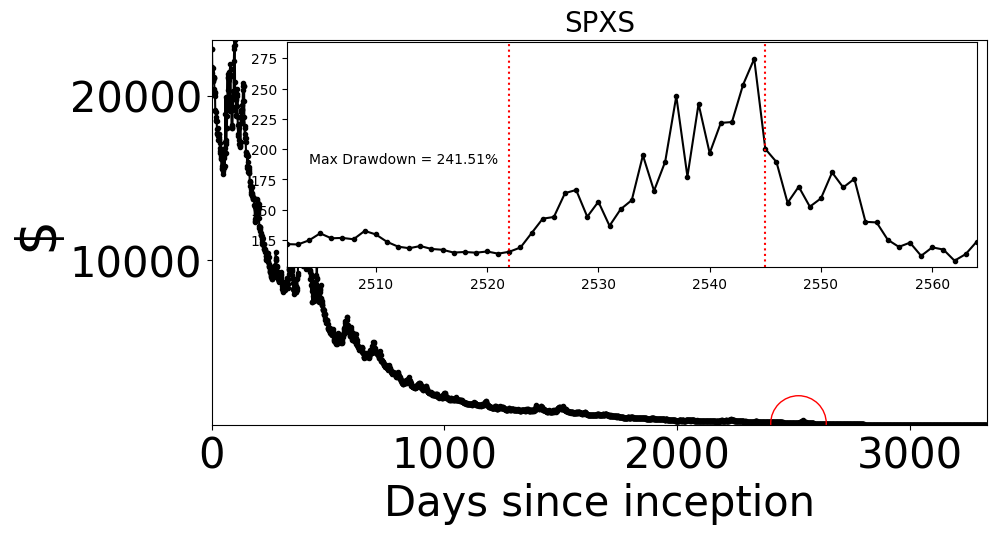

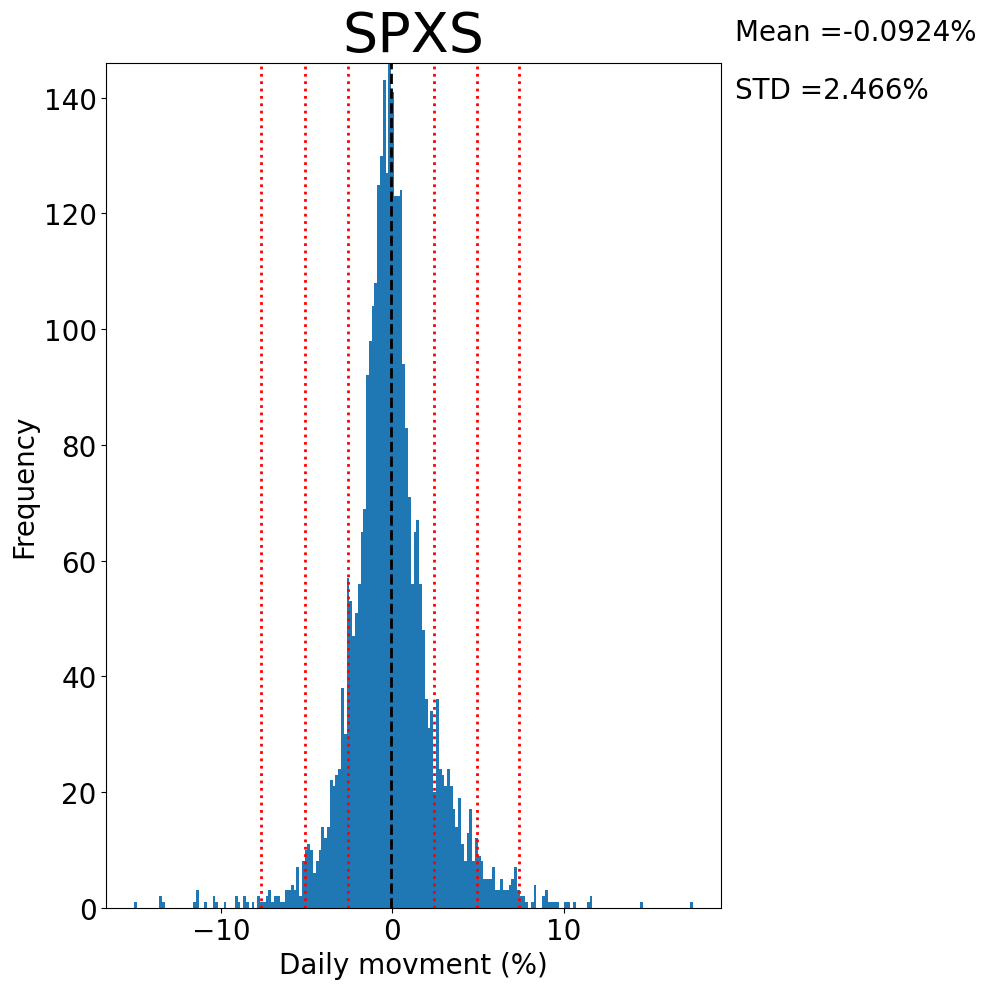

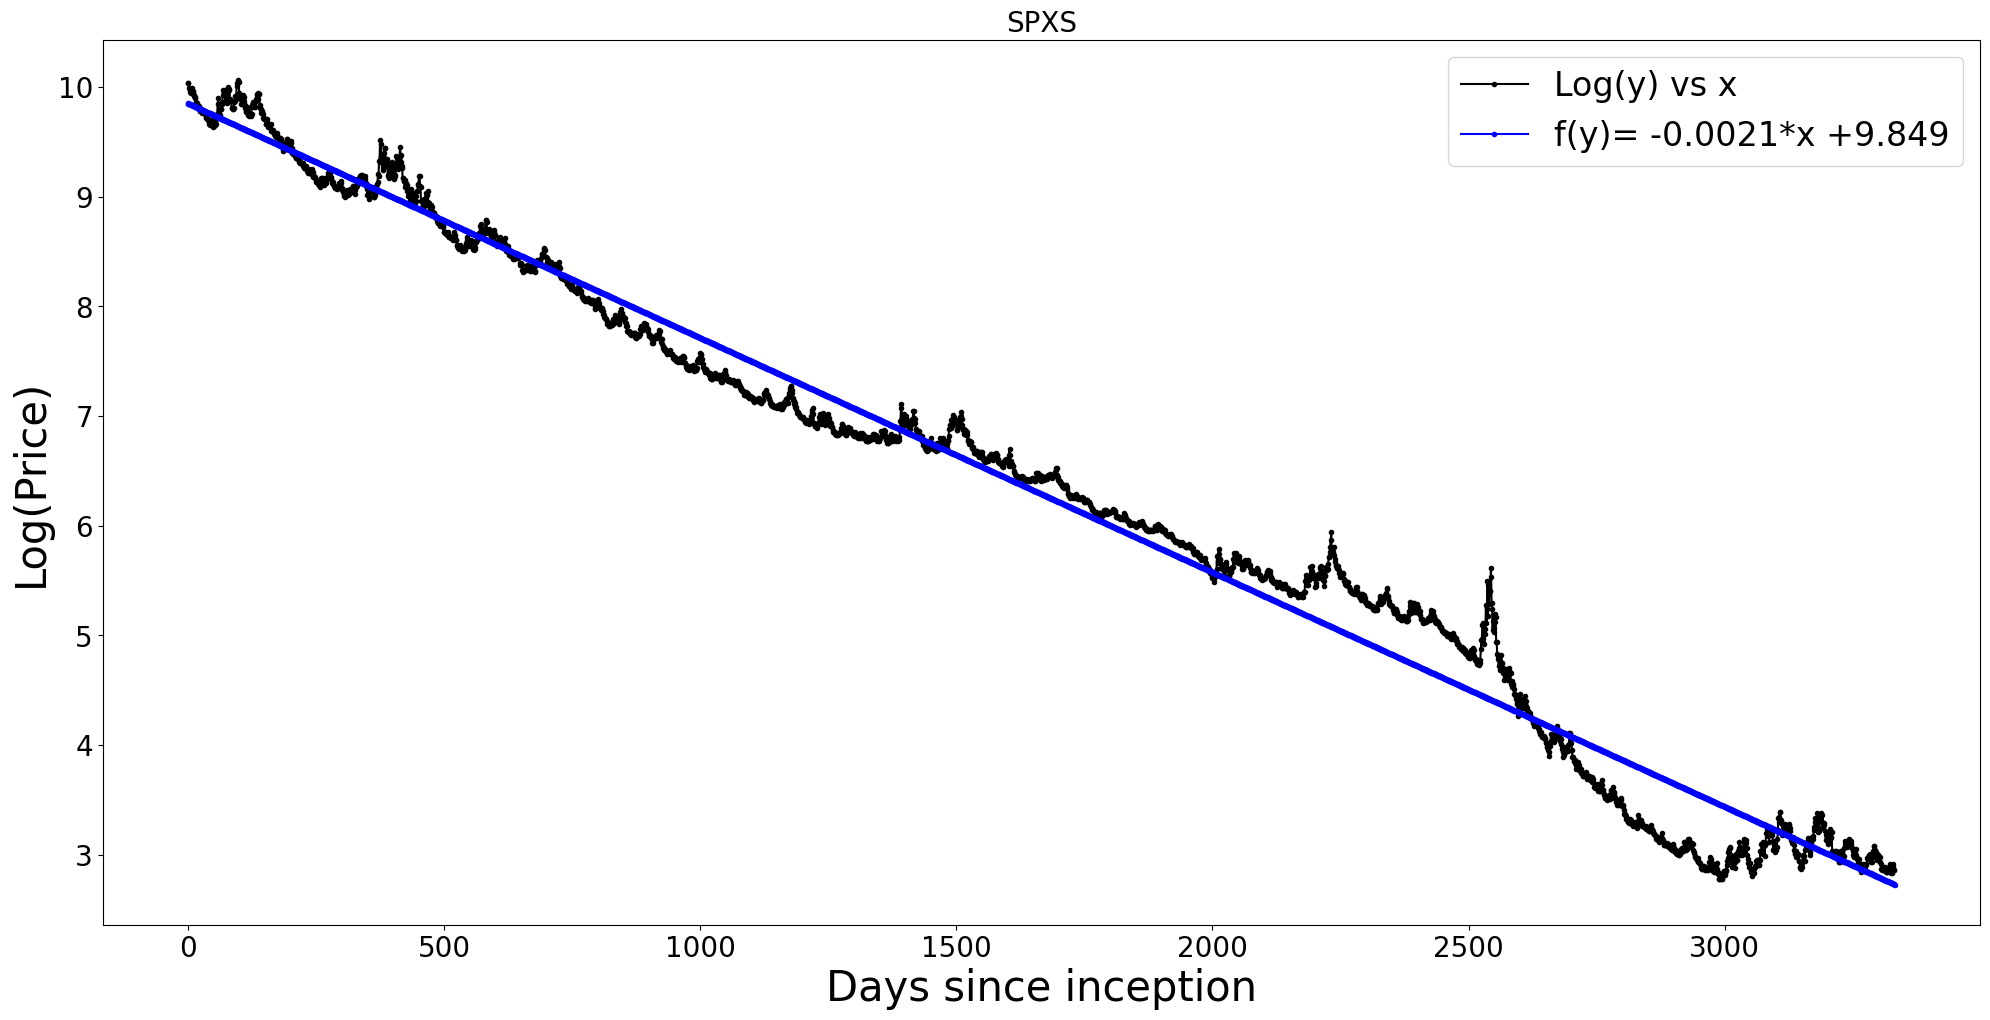

DOG
[*********************100%***********************]  1 of 1 completed


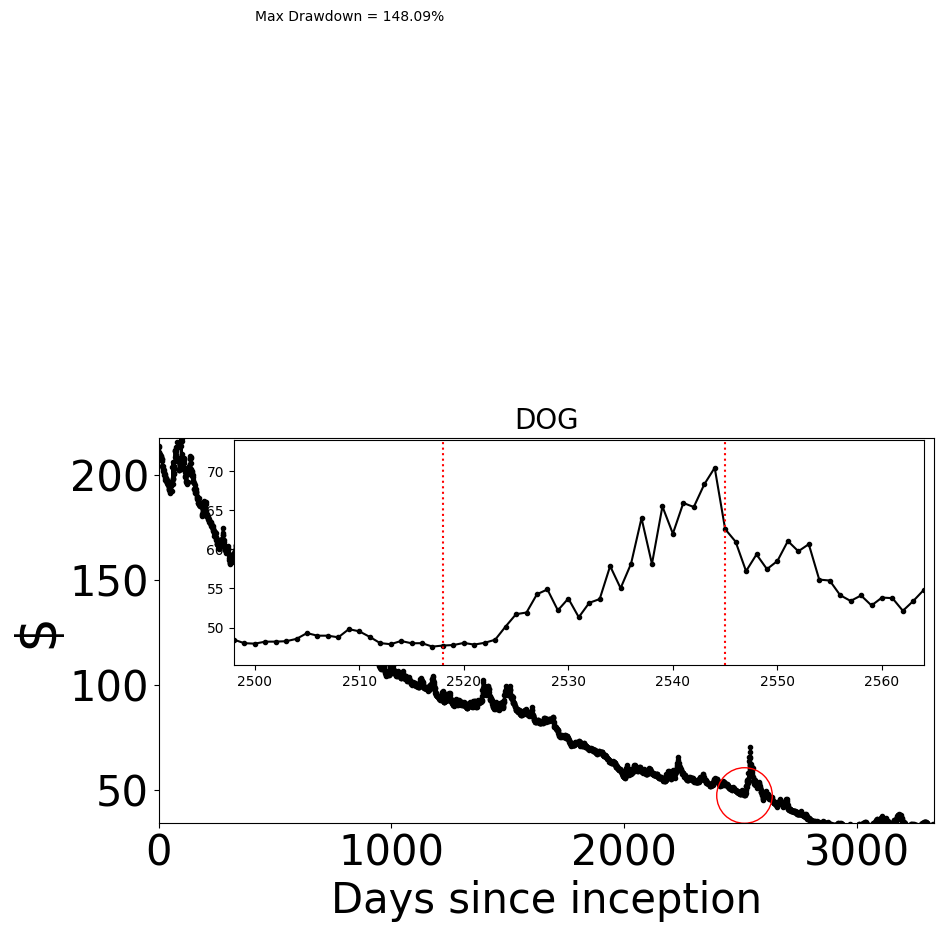

C:\Users\Scott\AppData\Local\Temp\ipykernel_4988\4208330821.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


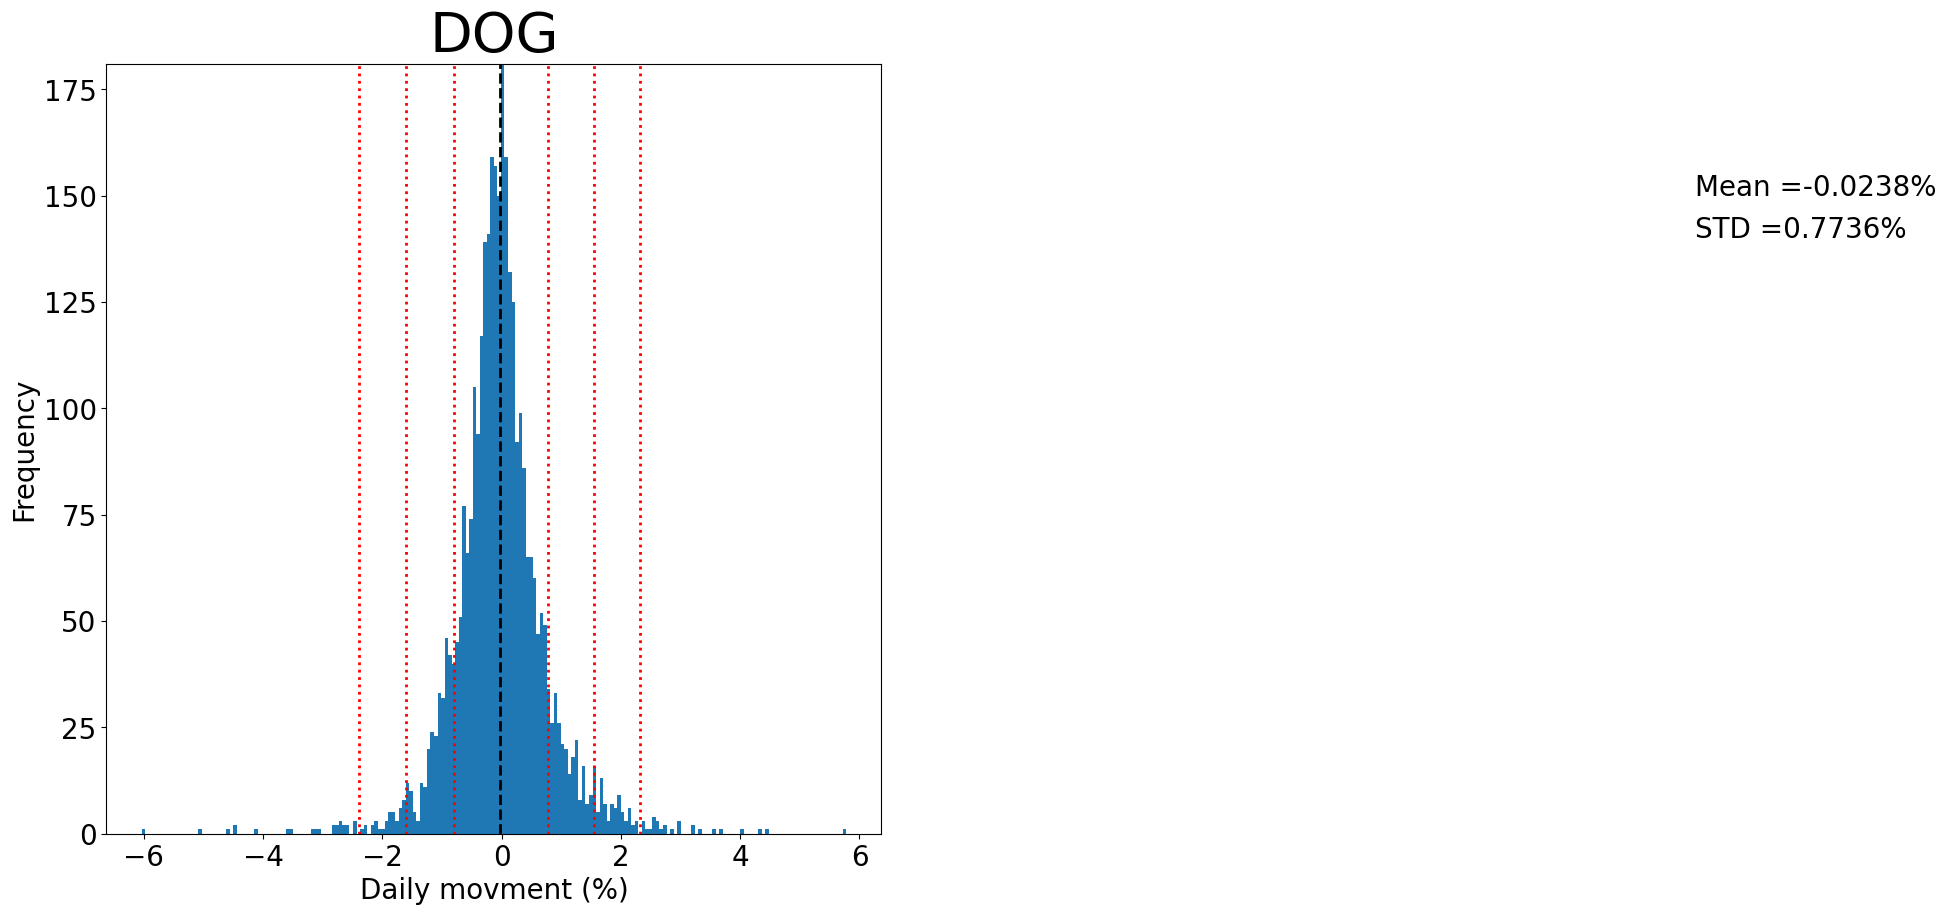

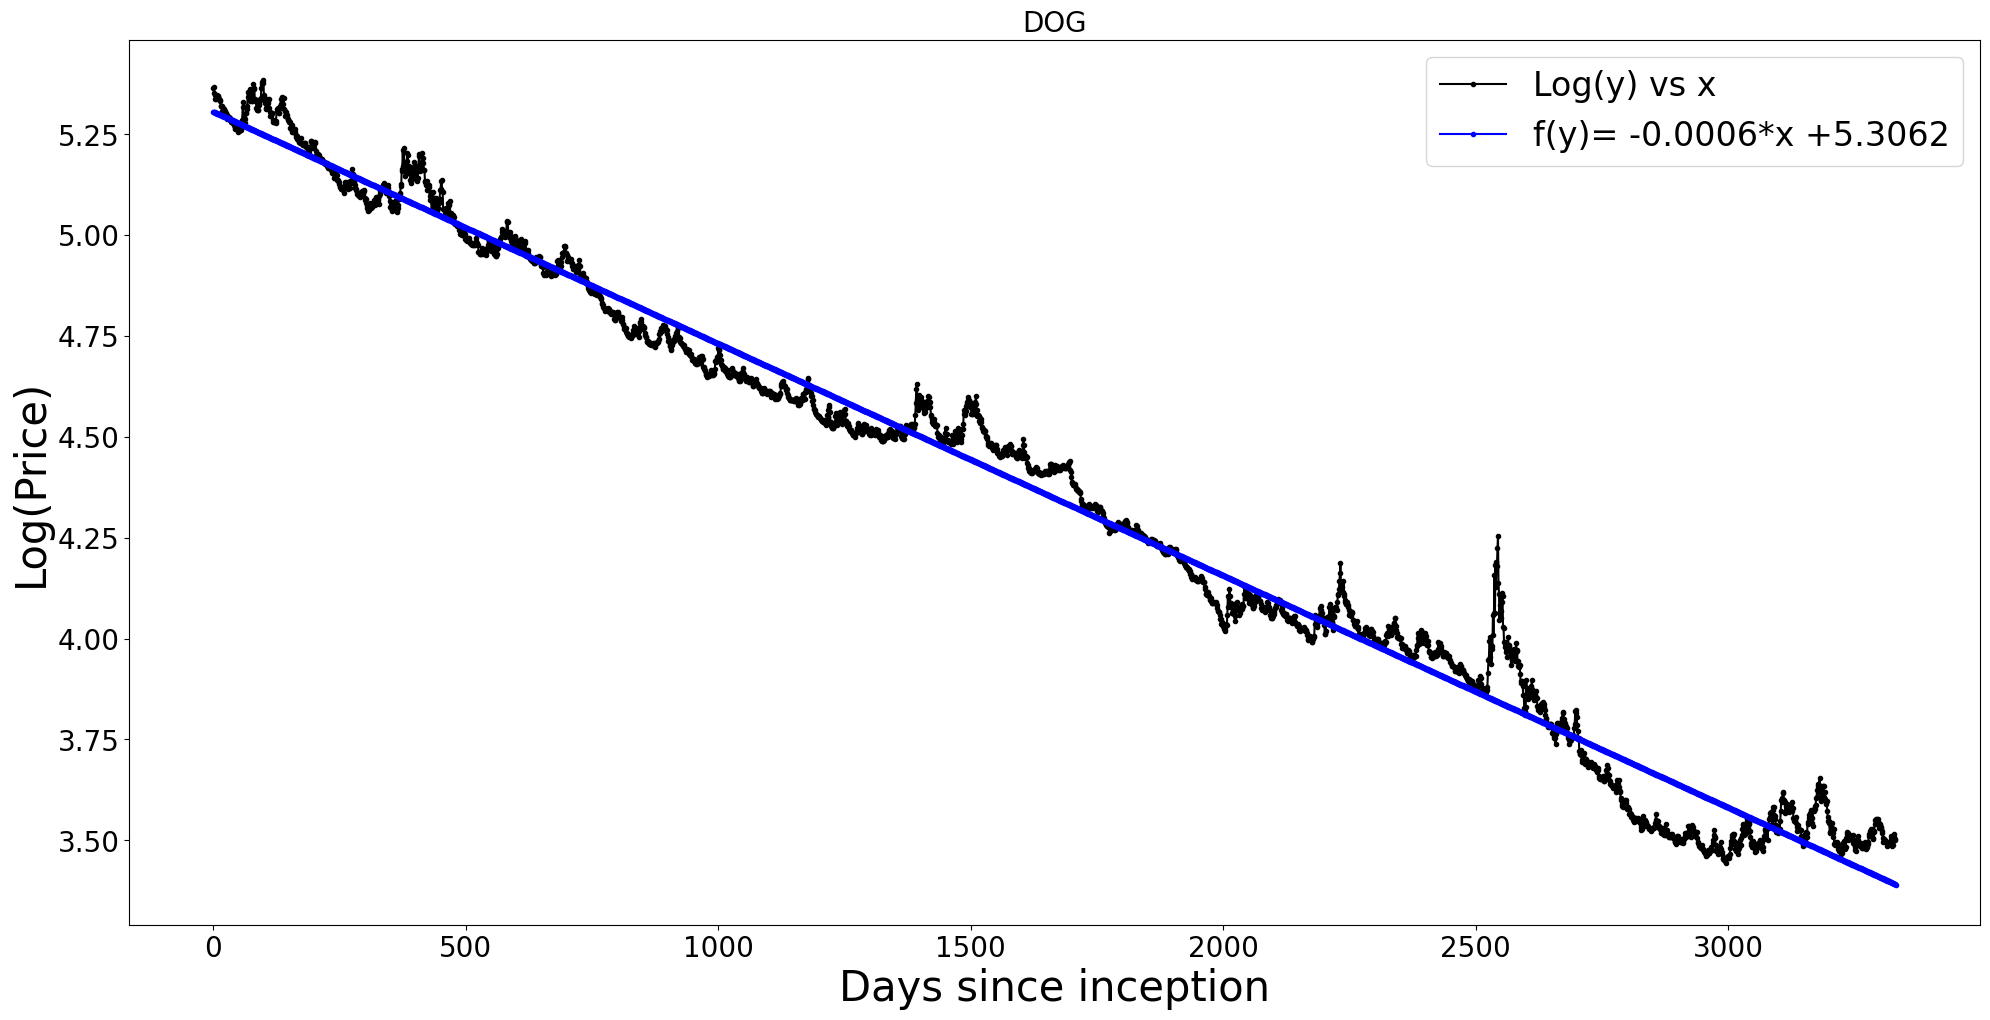

RYCWX
[*********************100%***********************]  1 of 1 completed


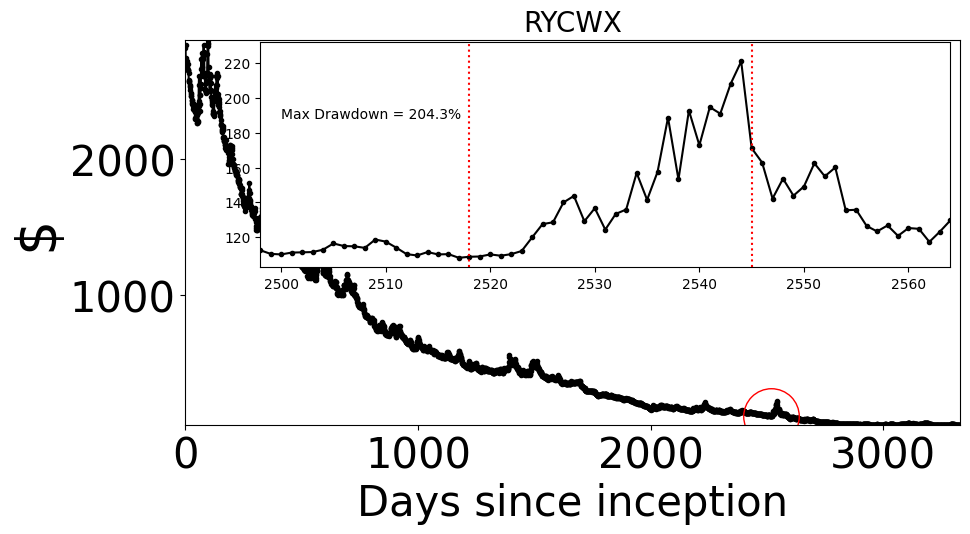

C:\Users\Scott\AppData\Local\Temp\ipykernel_4988\4208330821.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


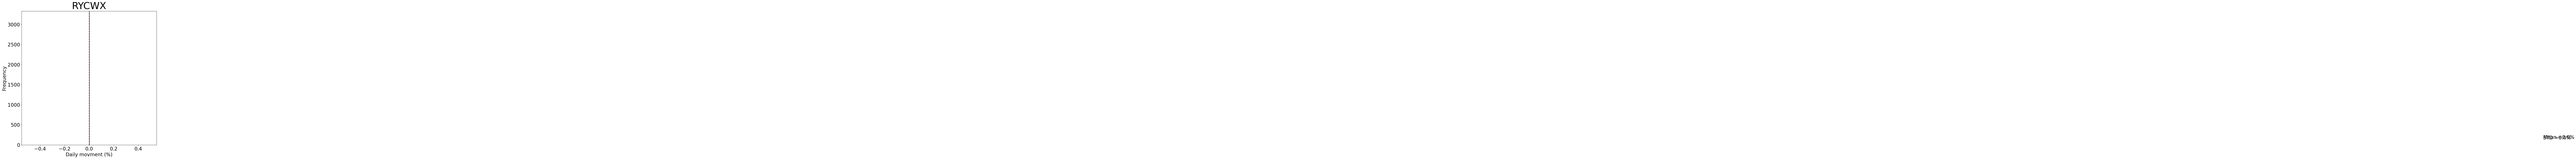

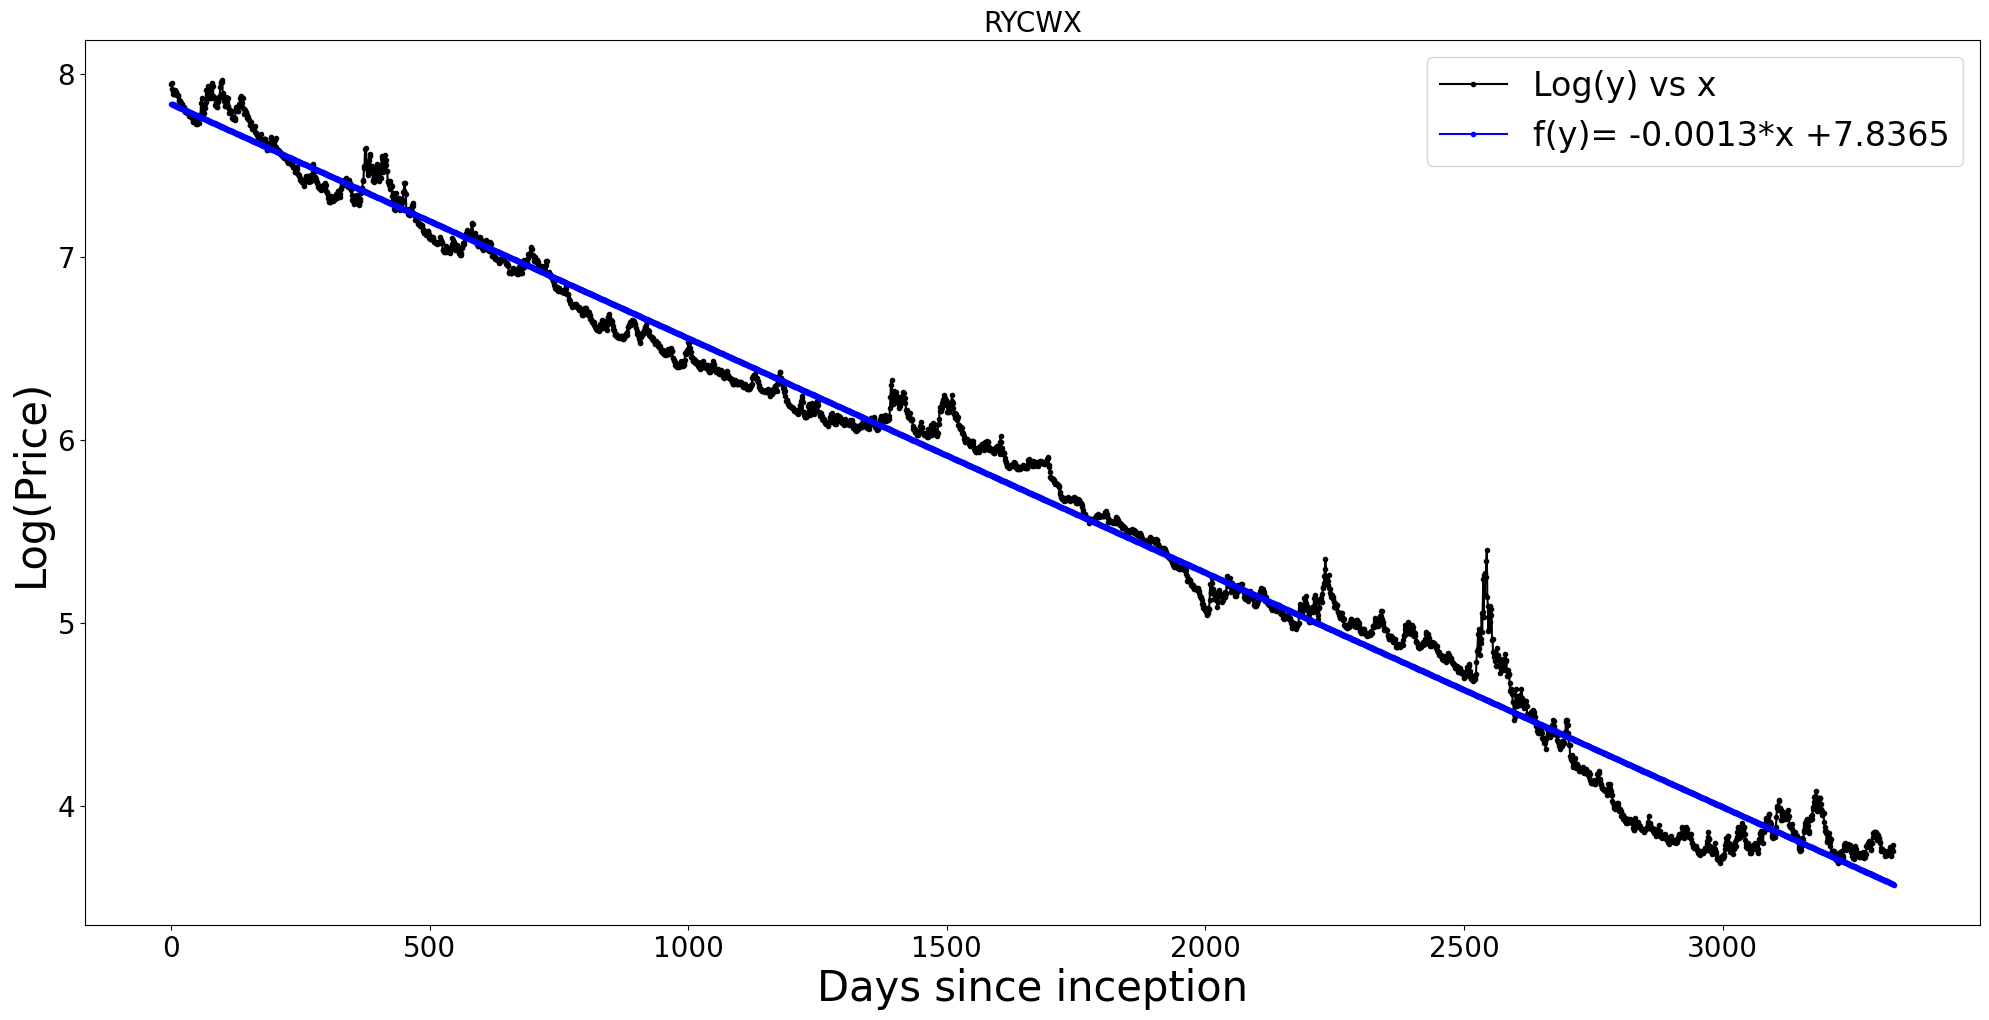

SDOW
[*********************100%***********************]  1 of 1 completed


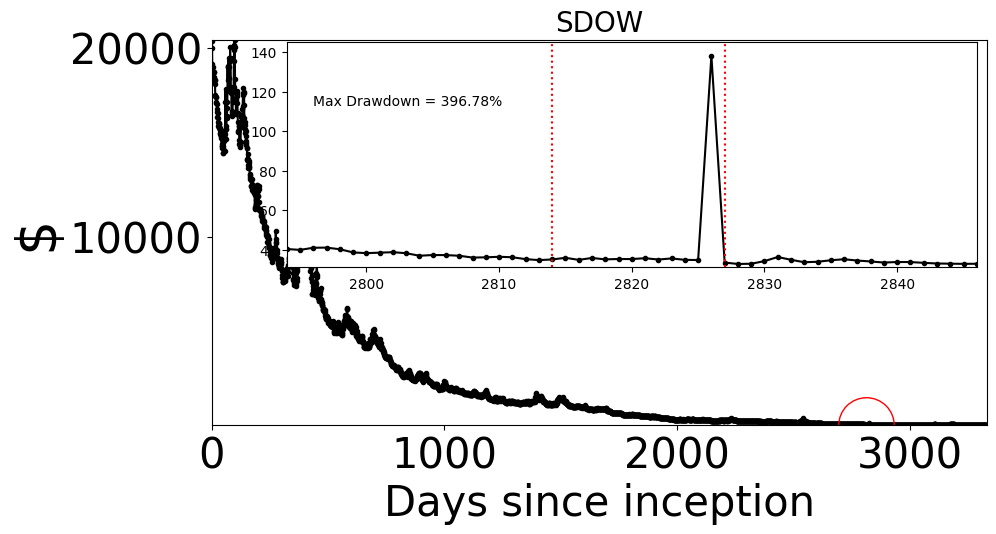

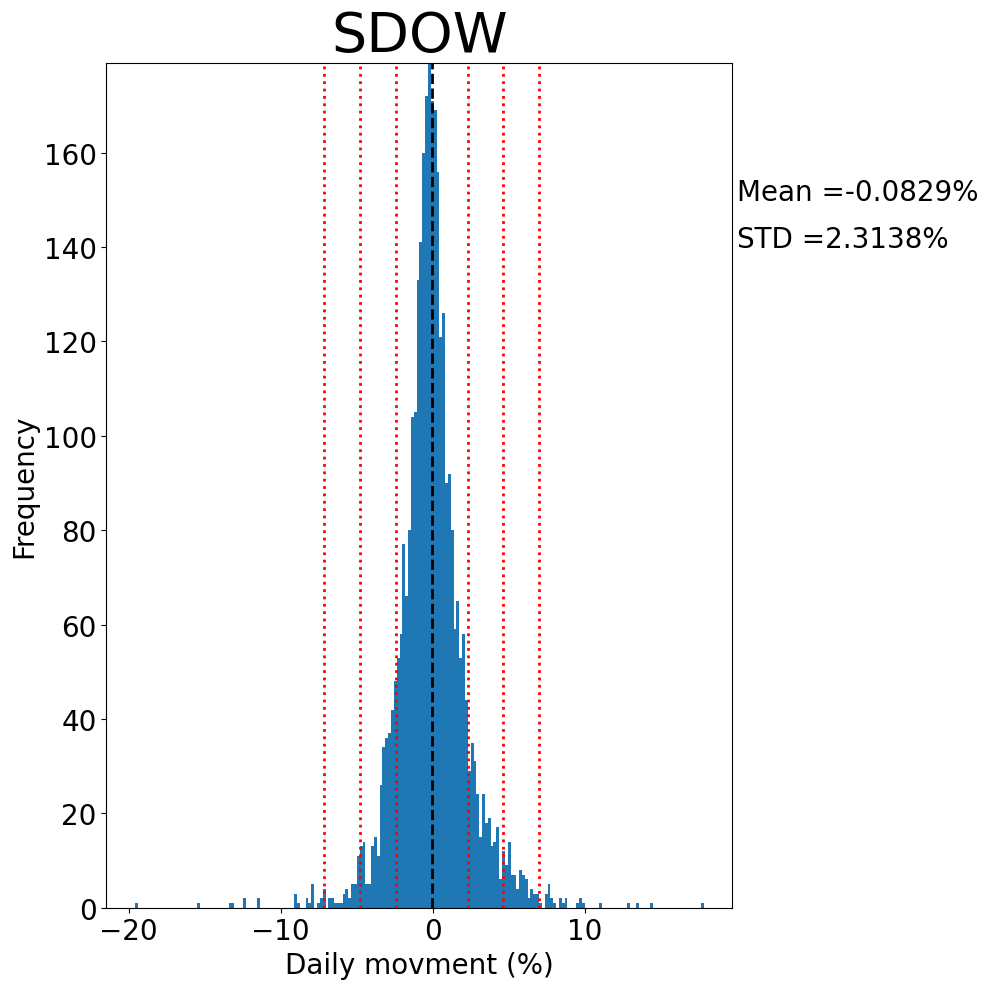

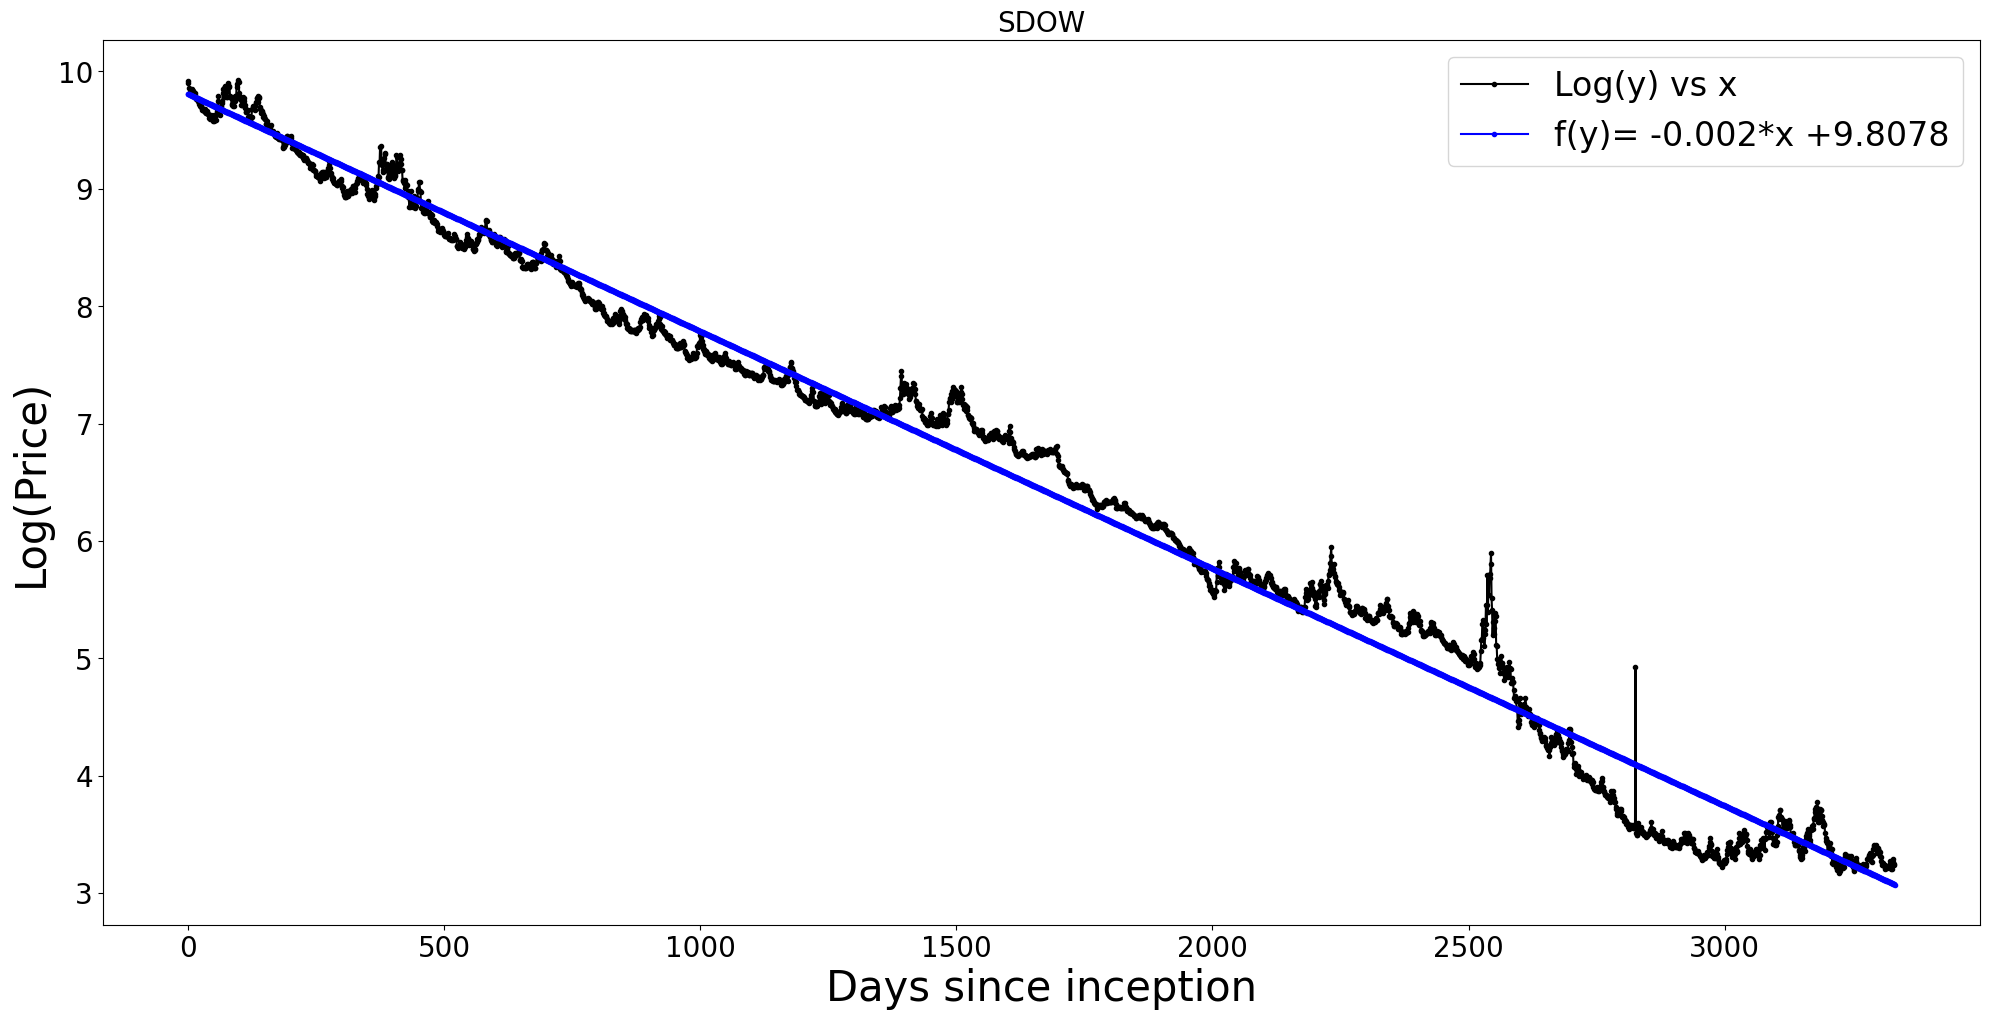

FAZ
[*********************100%***********************]  1 of 1 completed


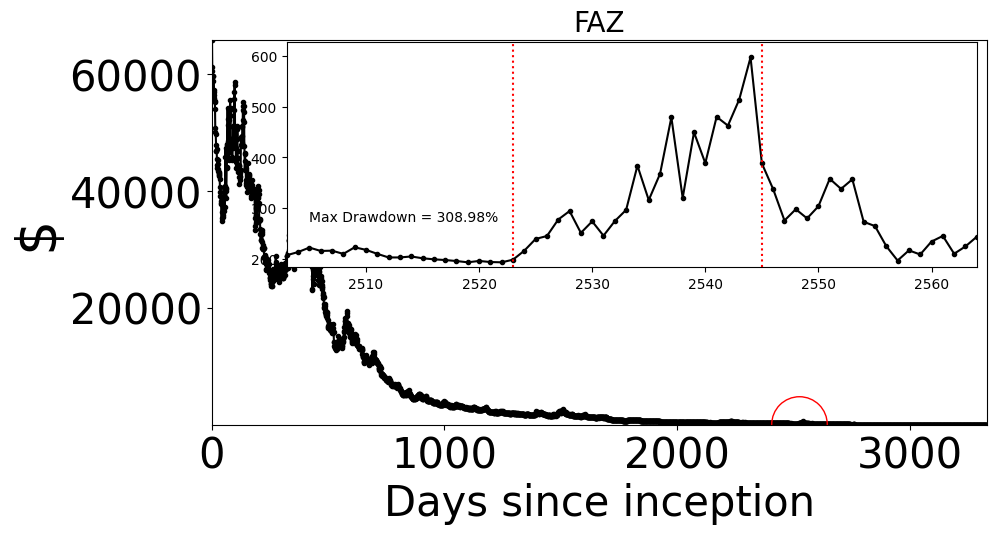

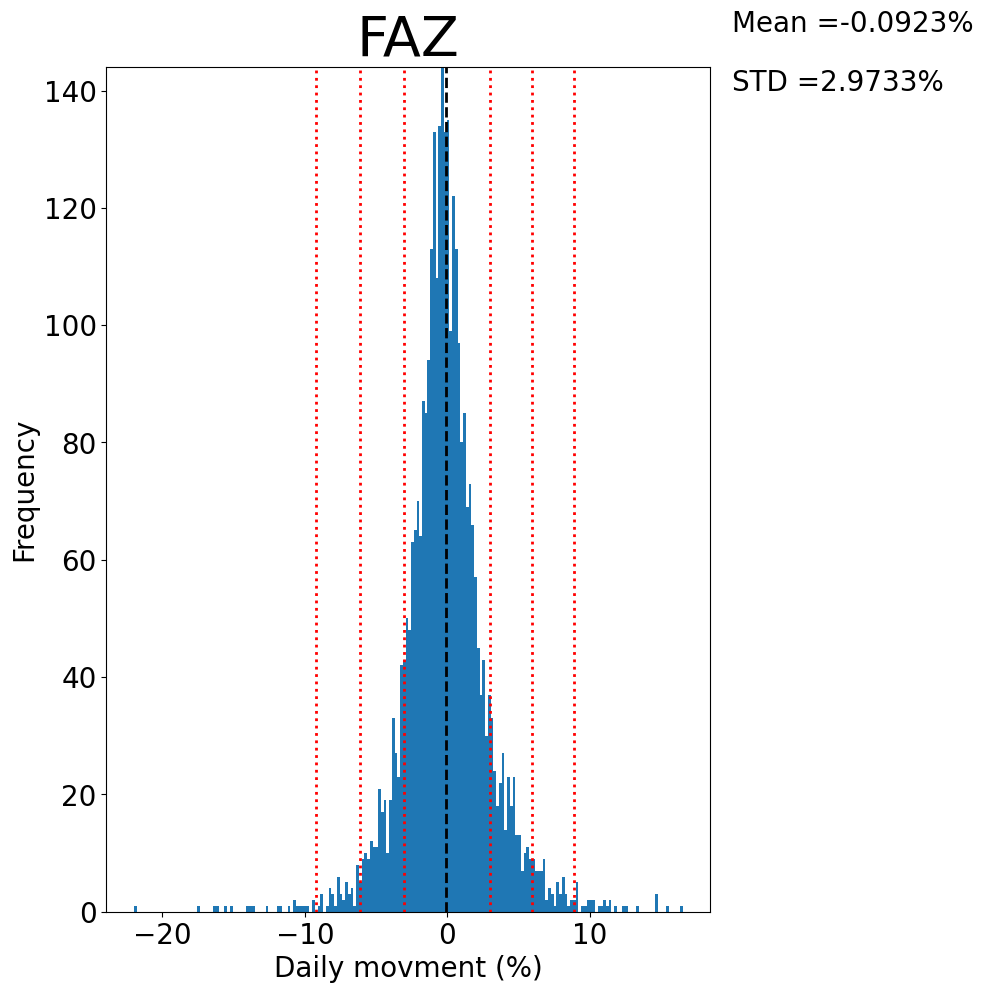

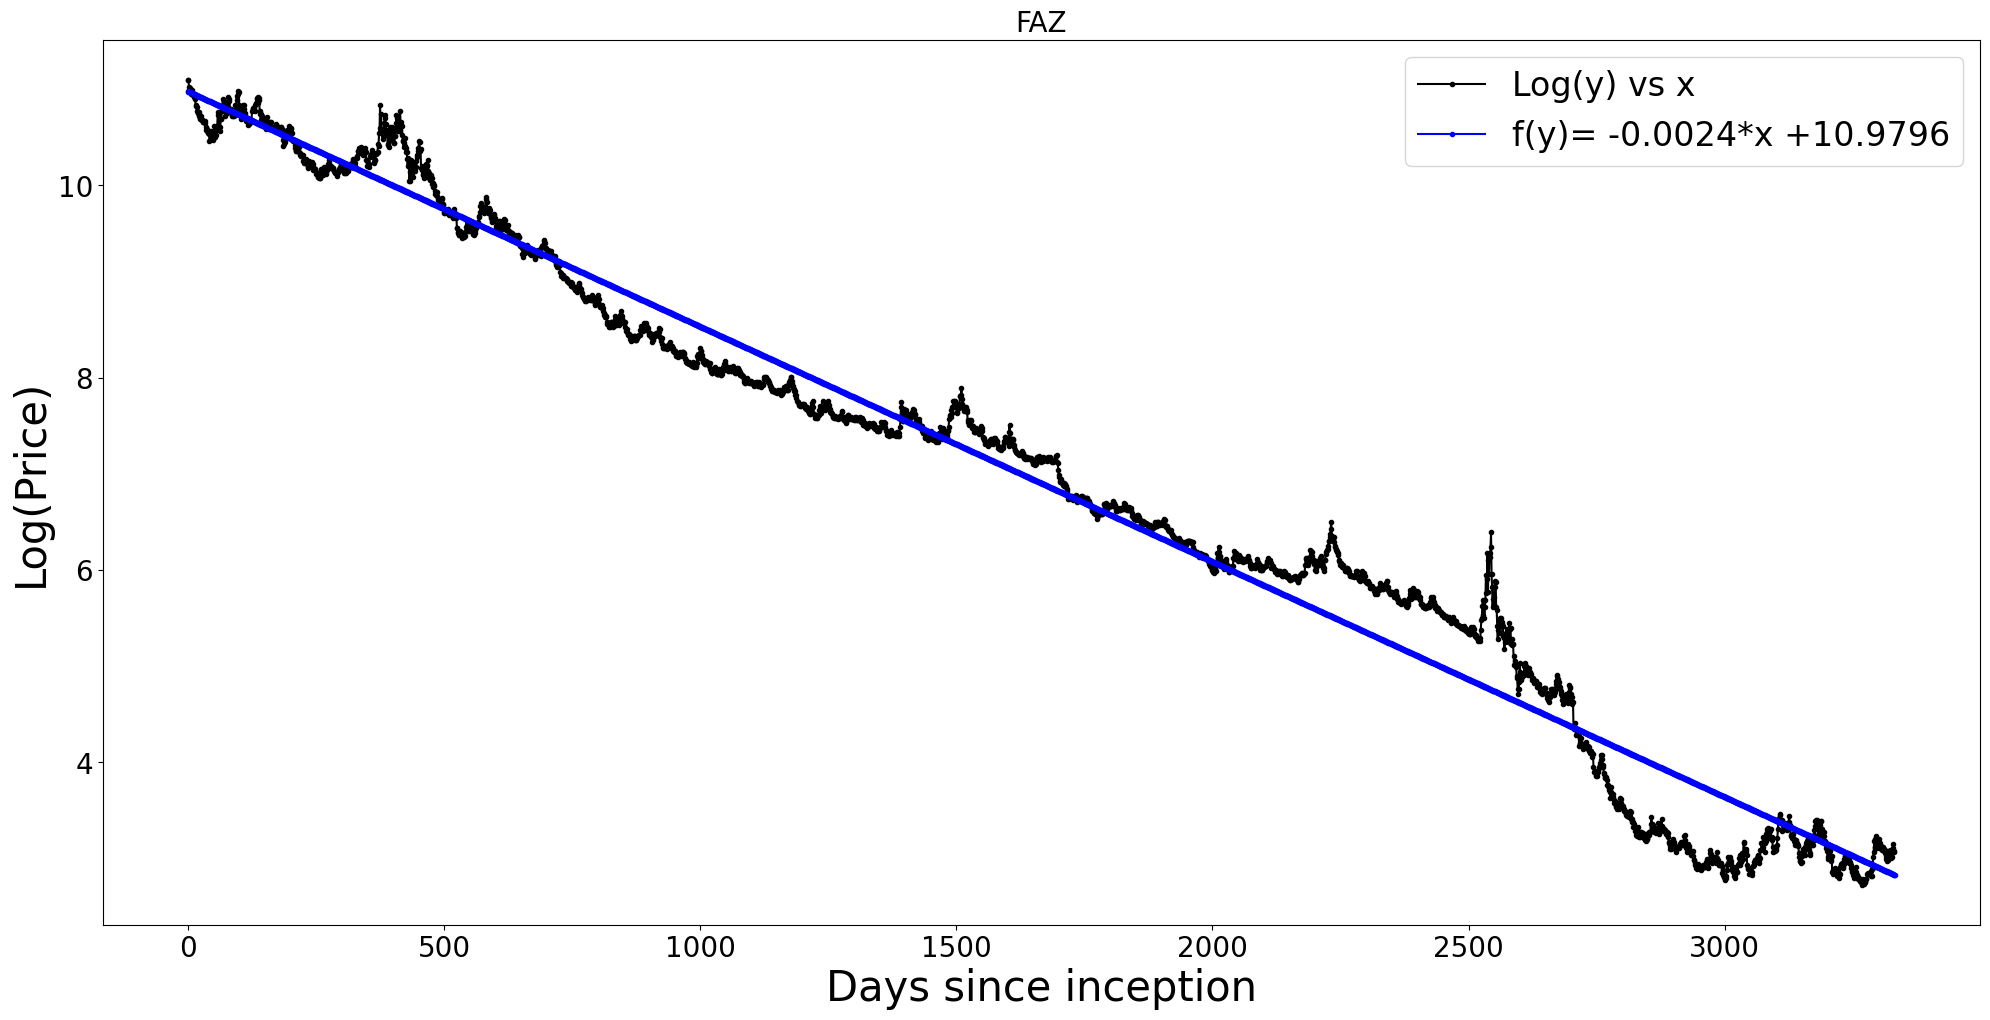

PCQ
[*********************100%***********************]  1 of 1 completed


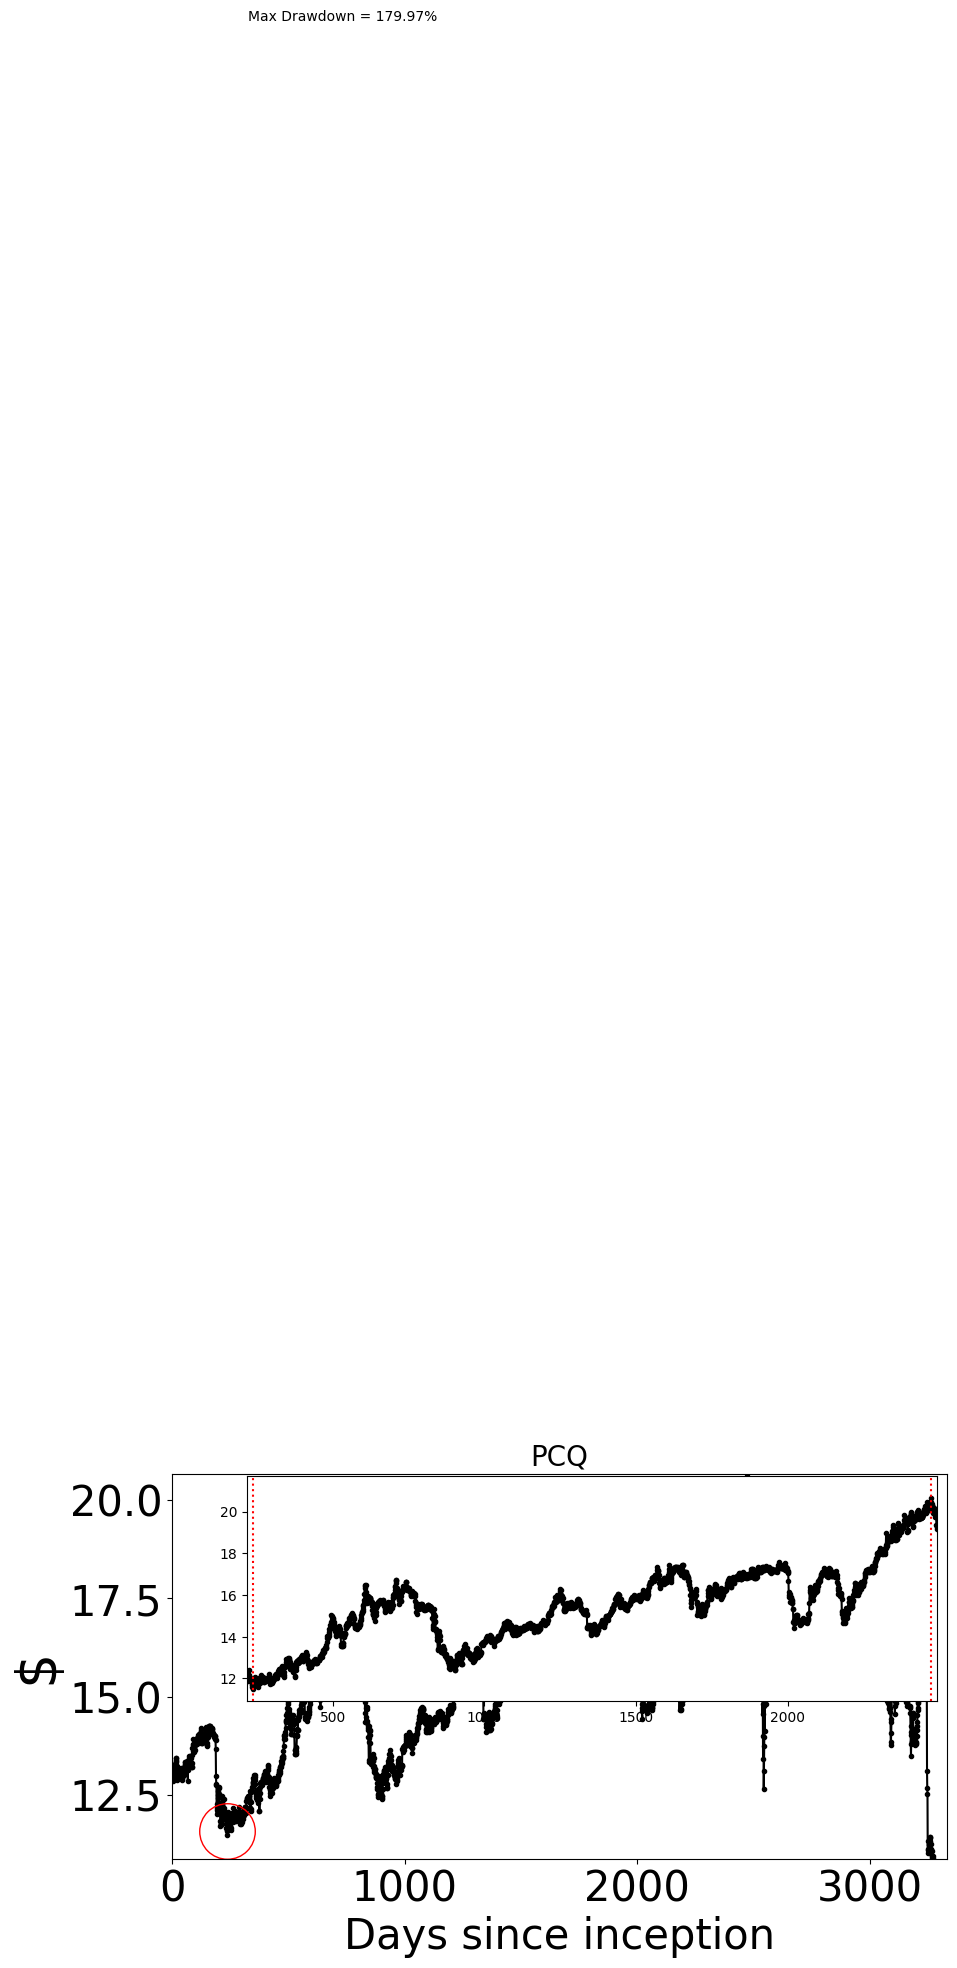

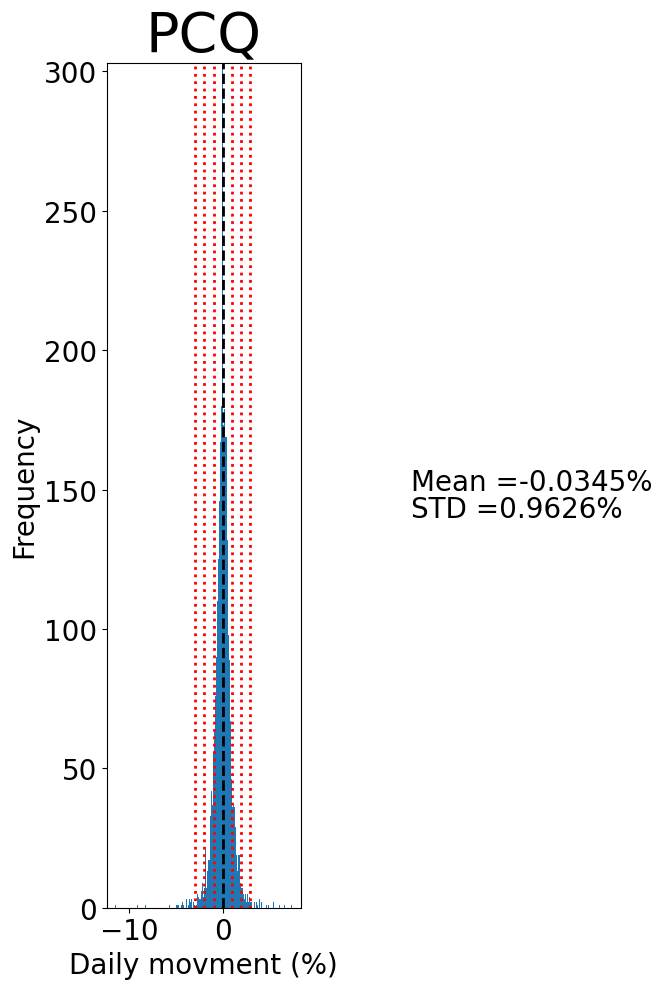

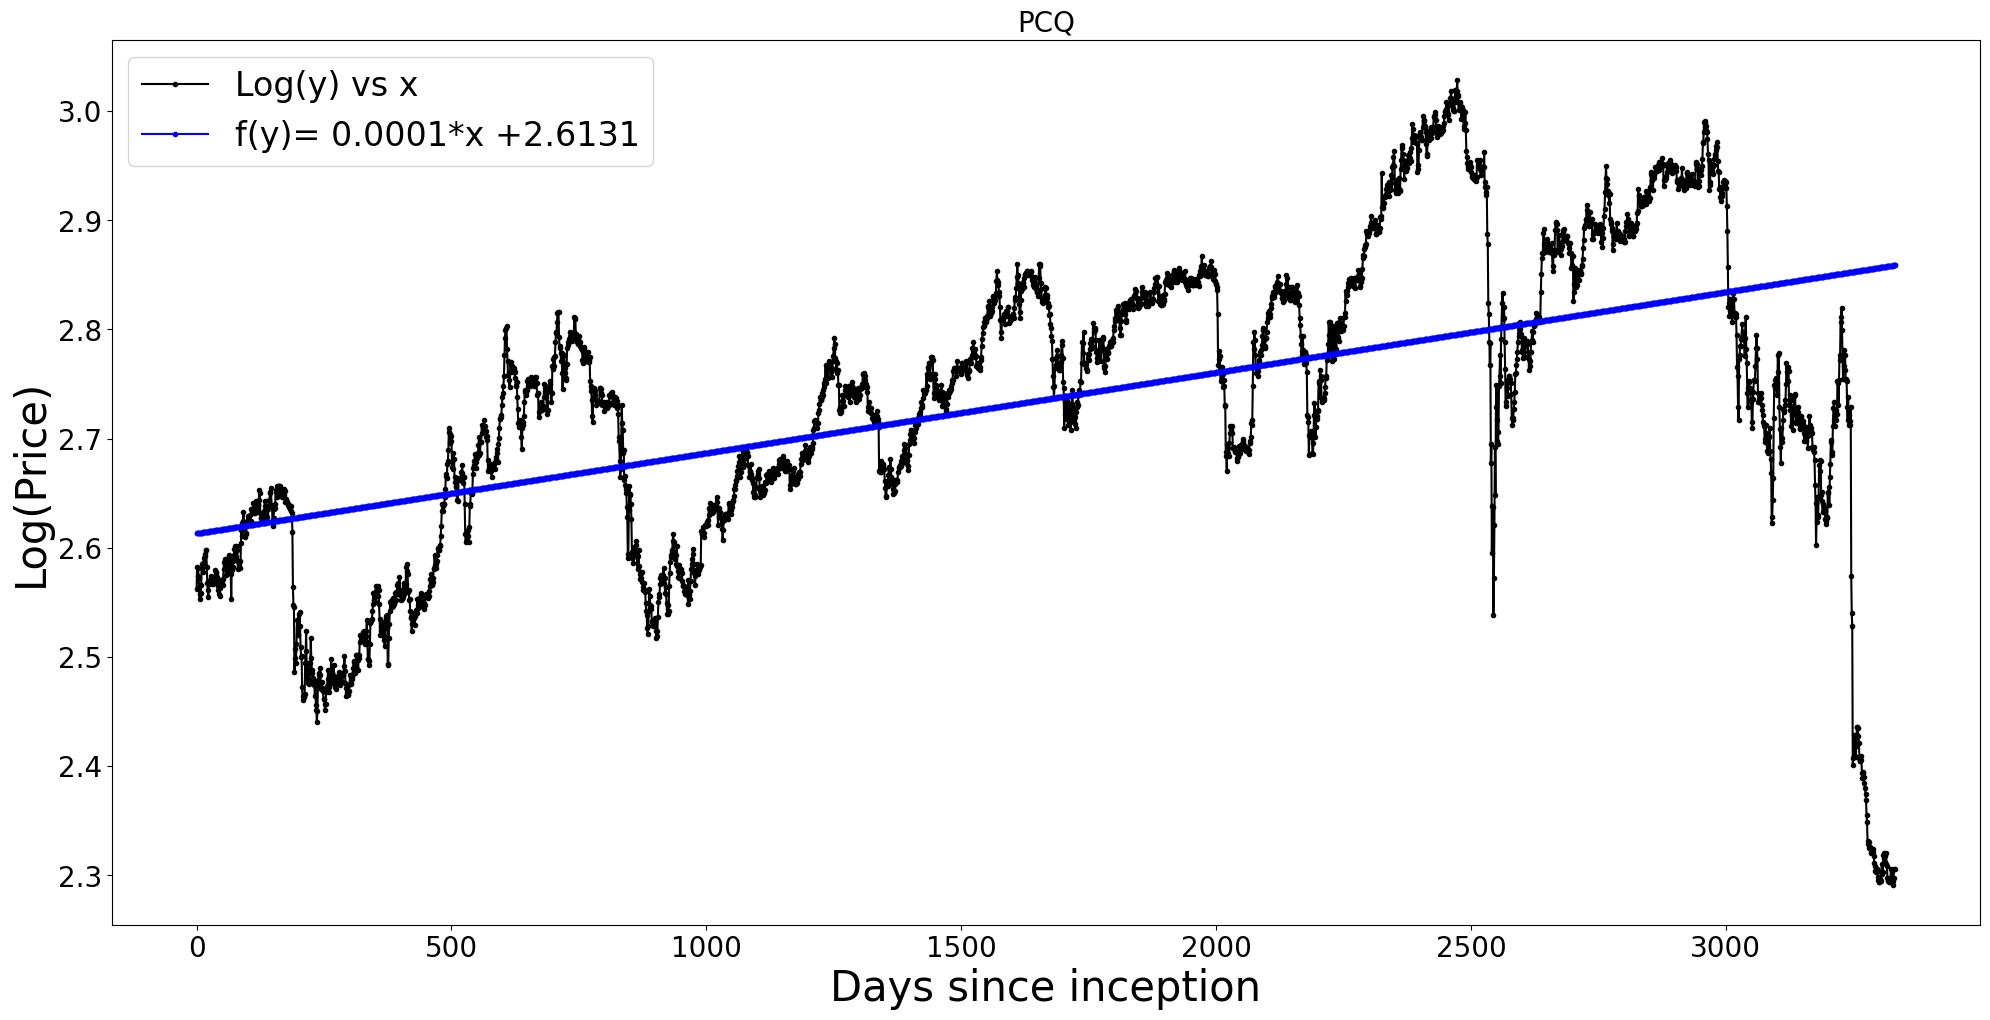

TWM
[*********************100%***********************]  1 of 1 completed


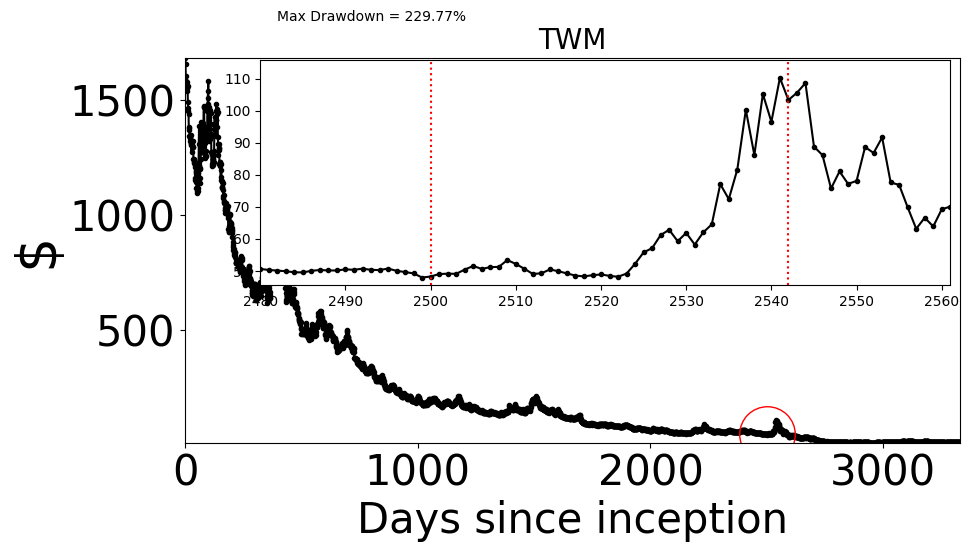

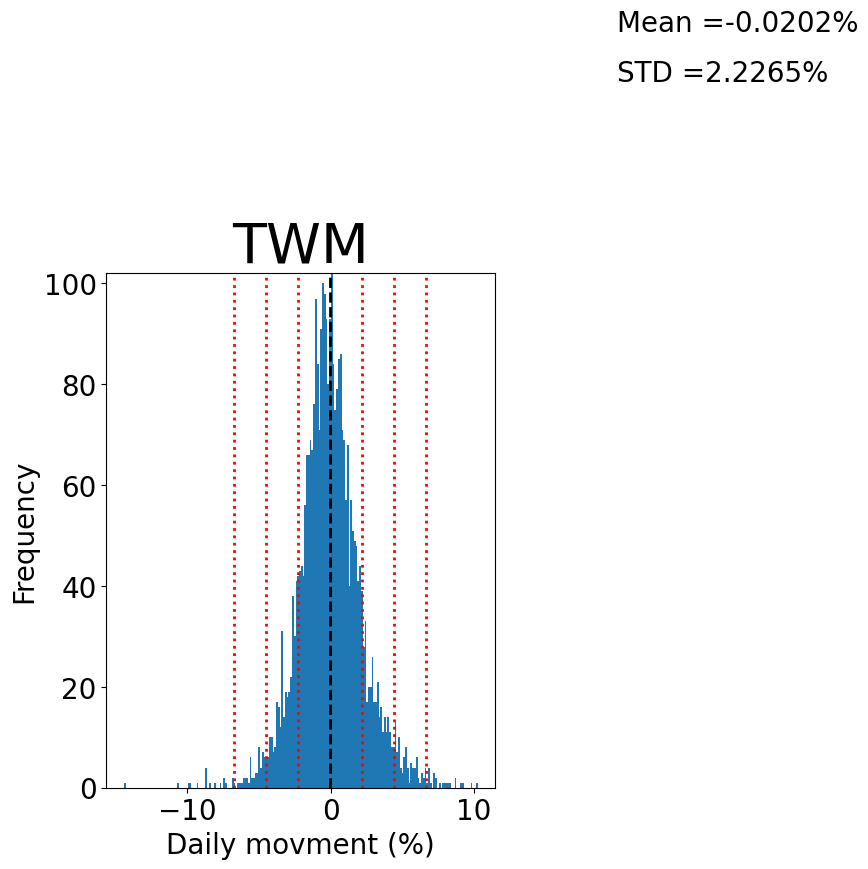

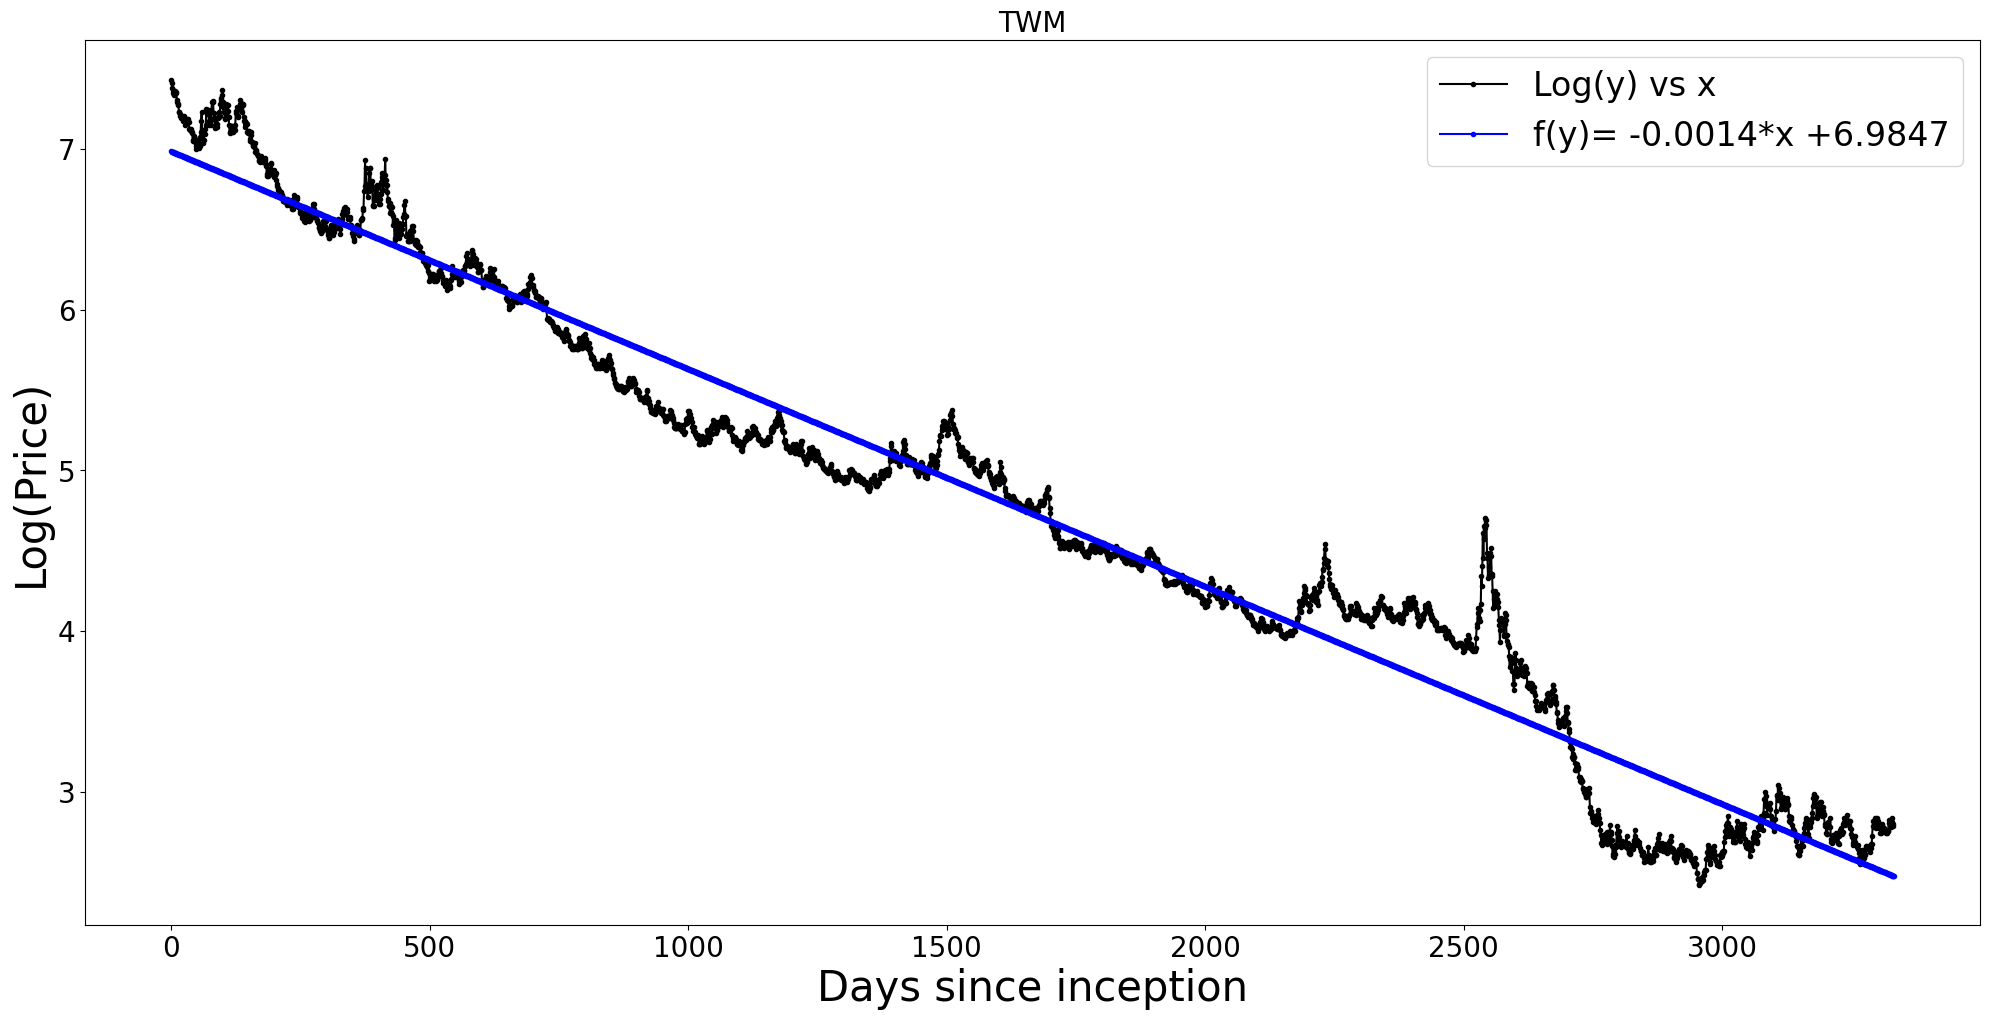

SRTY
[*********************100%***********************]  1 of 1 completed


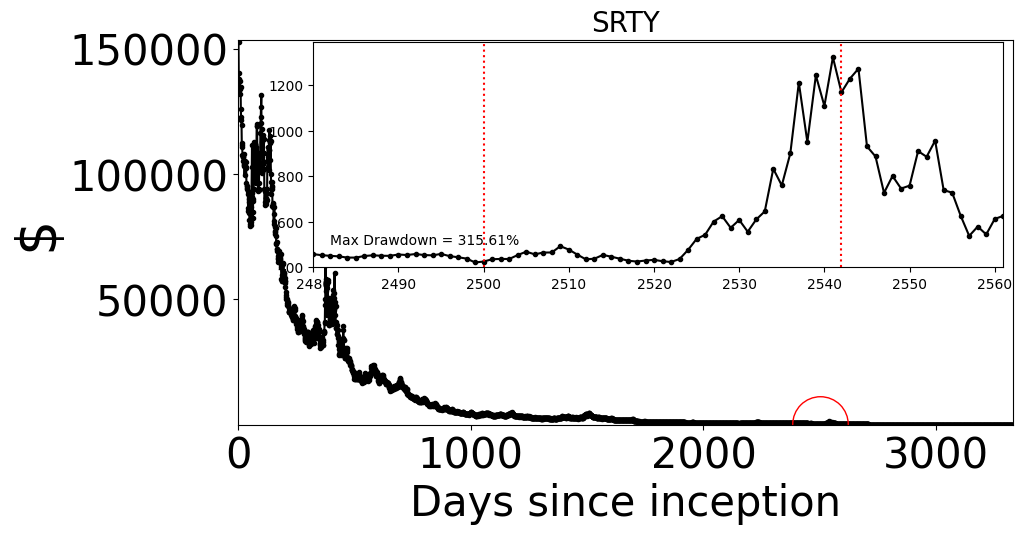

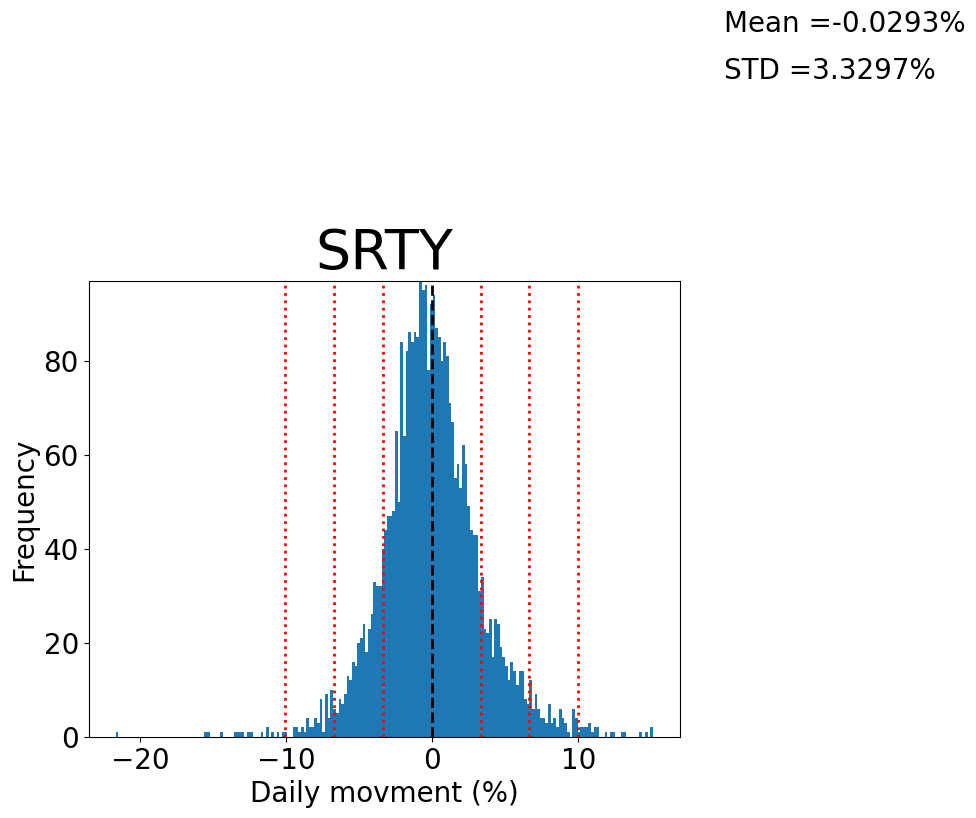

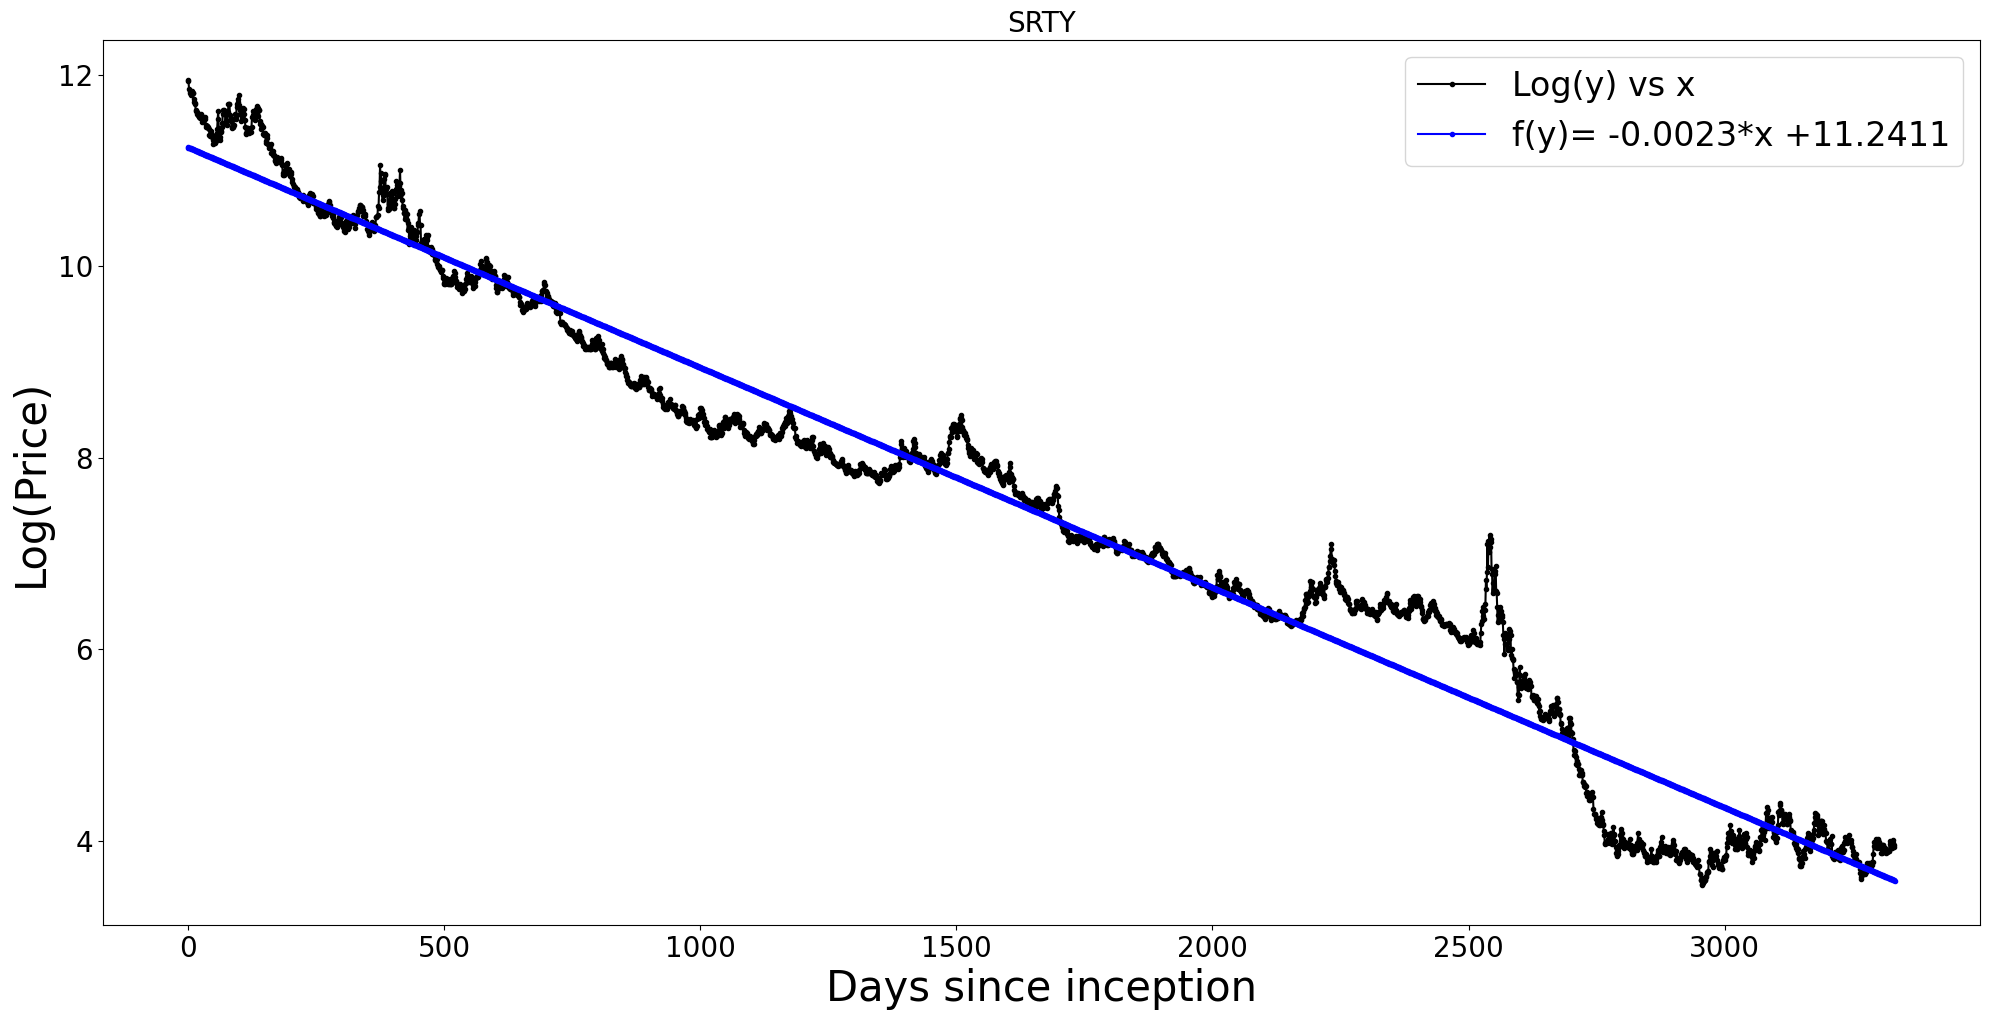

TZA
[*********************100%***********************]  1 of 1 completed


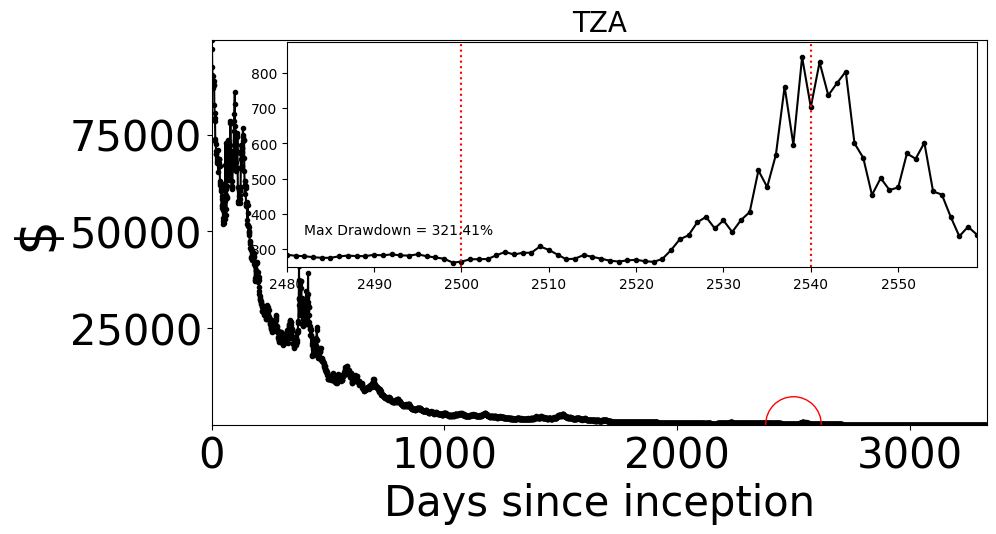

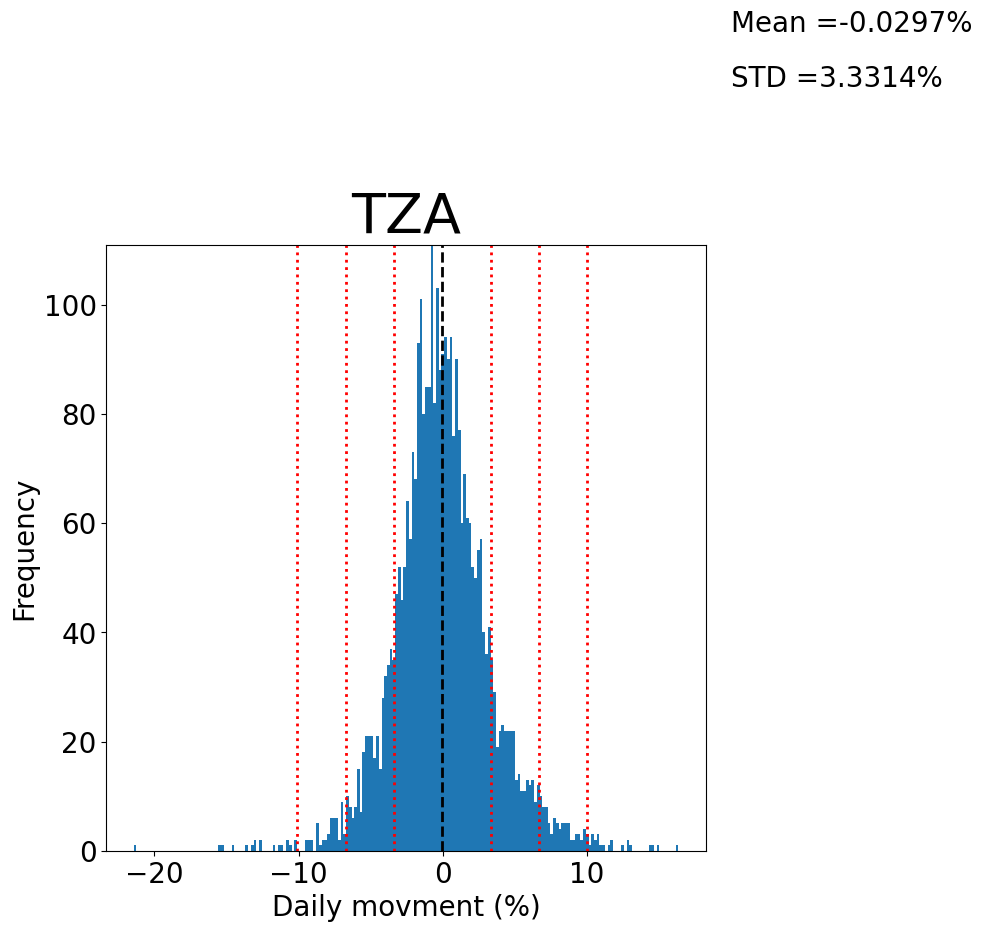

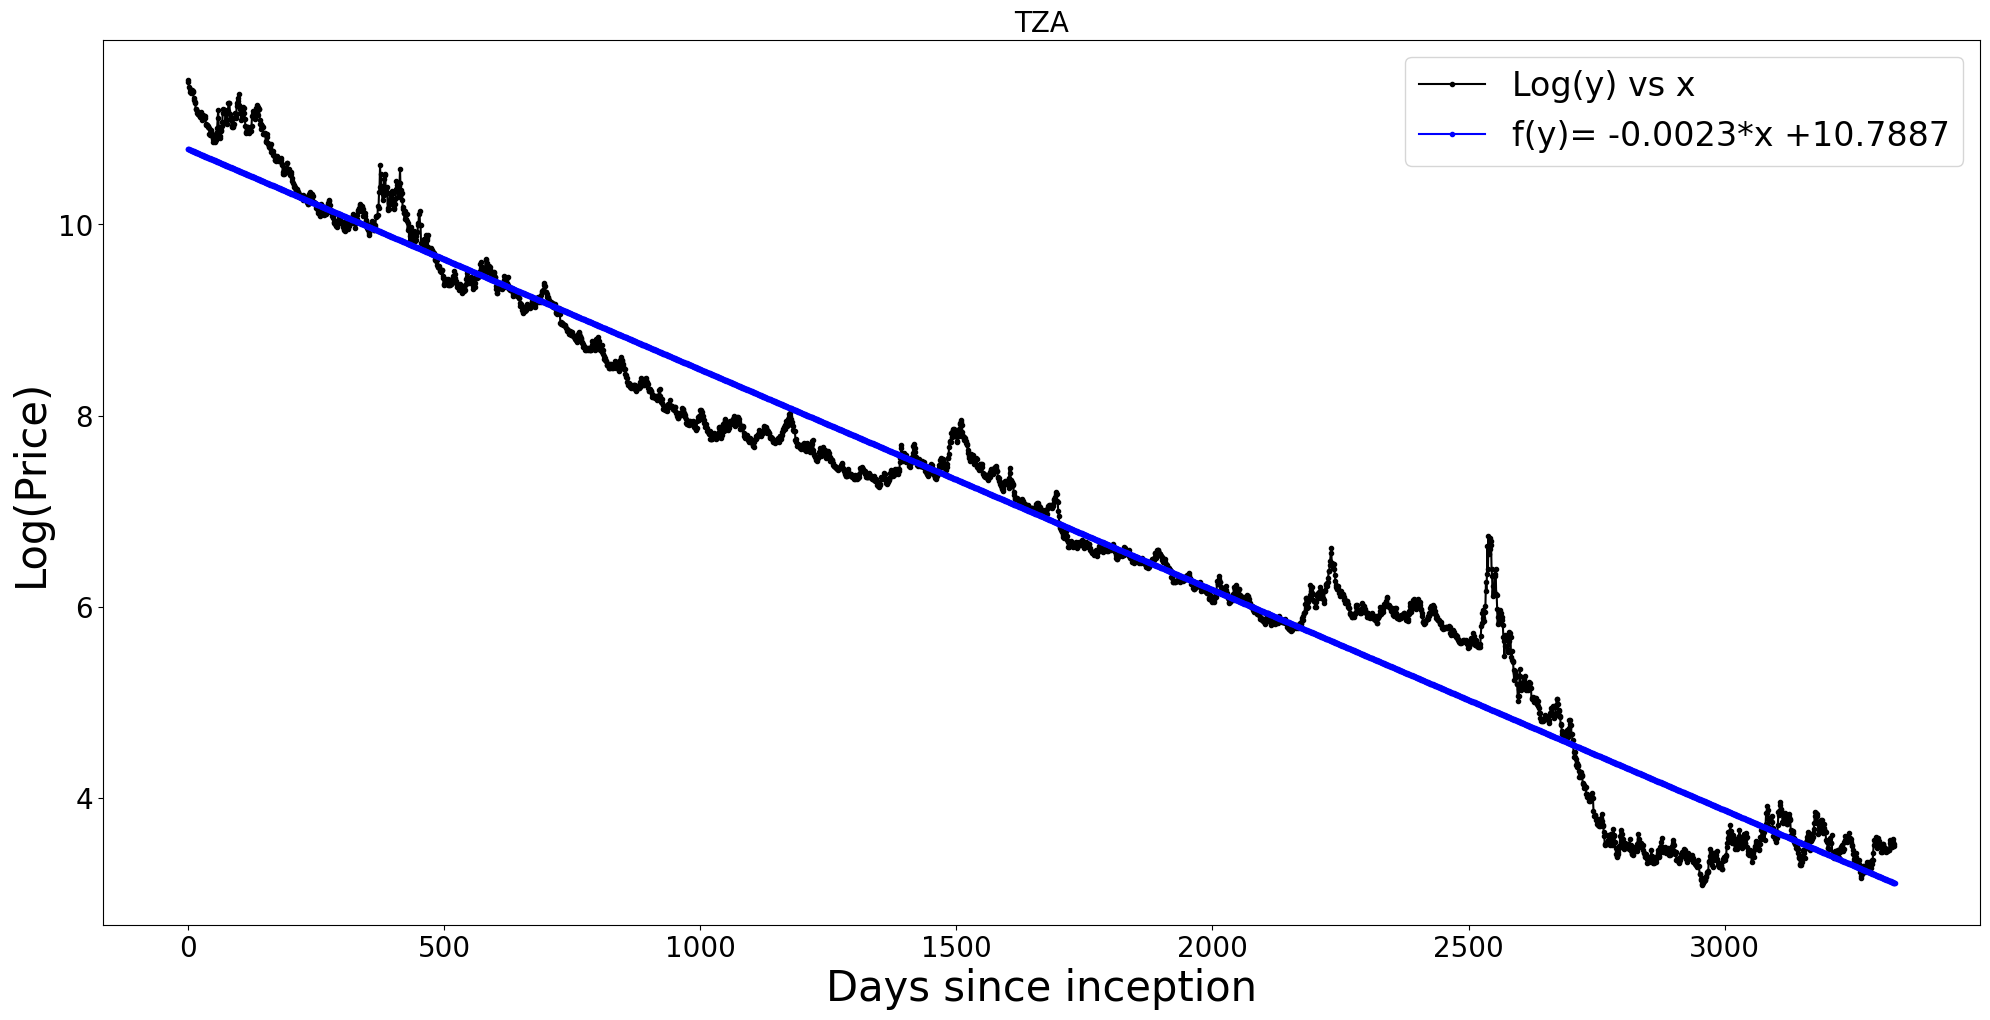

DUST
[*********************100%***********************]  1 of 1 completed


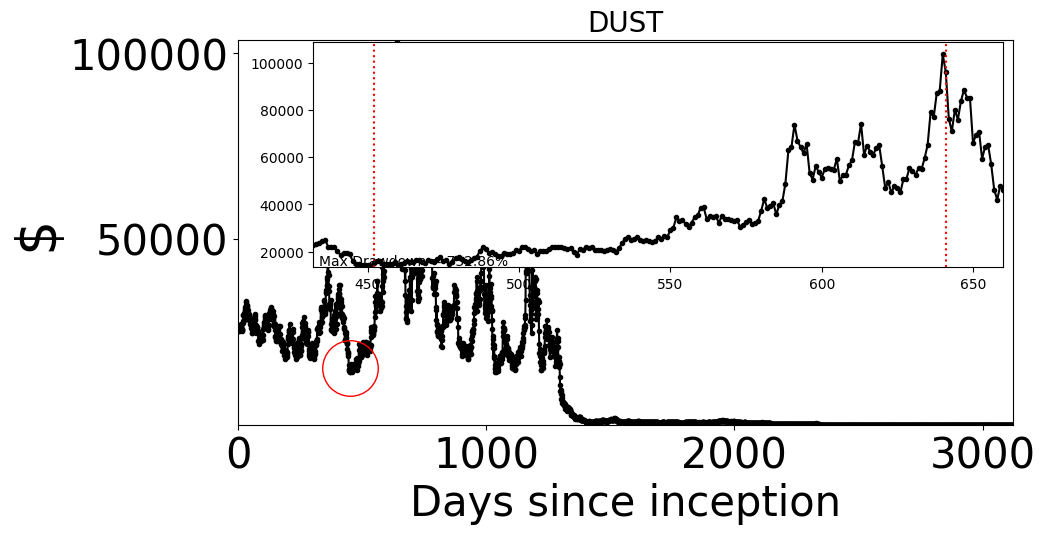

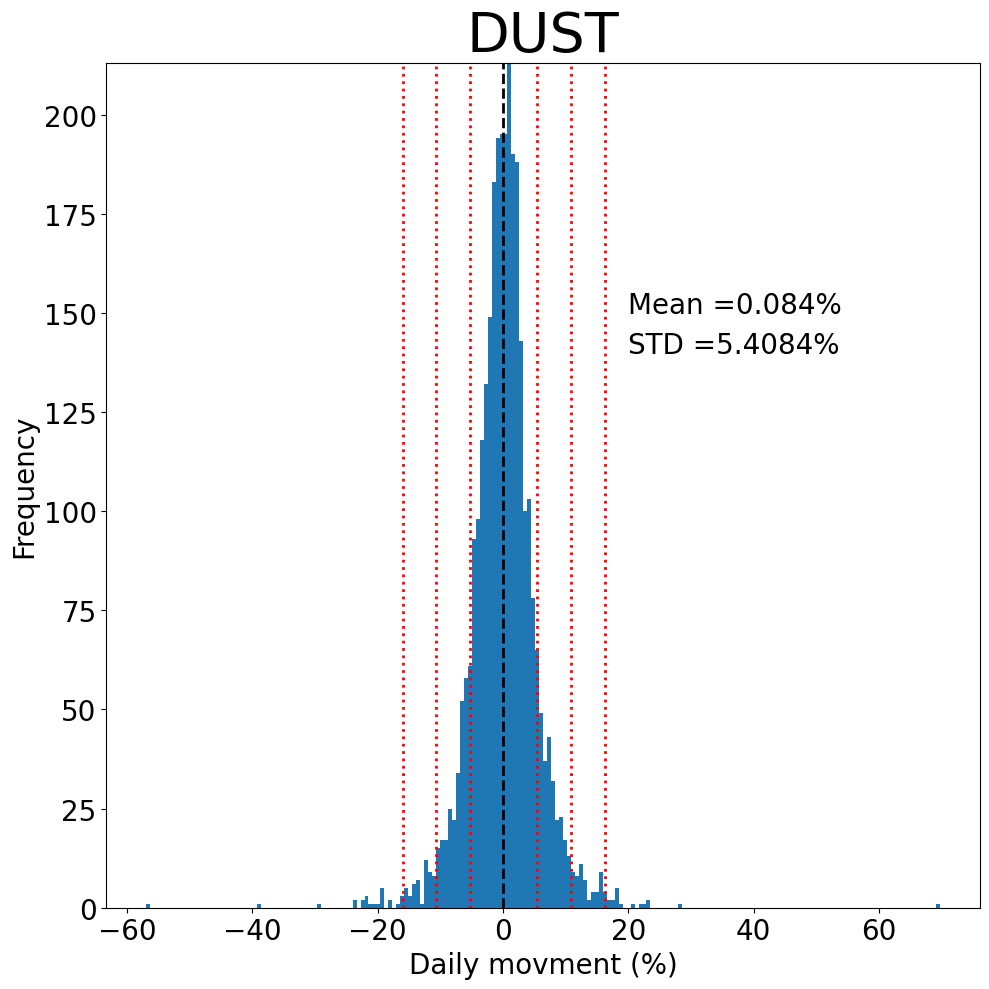

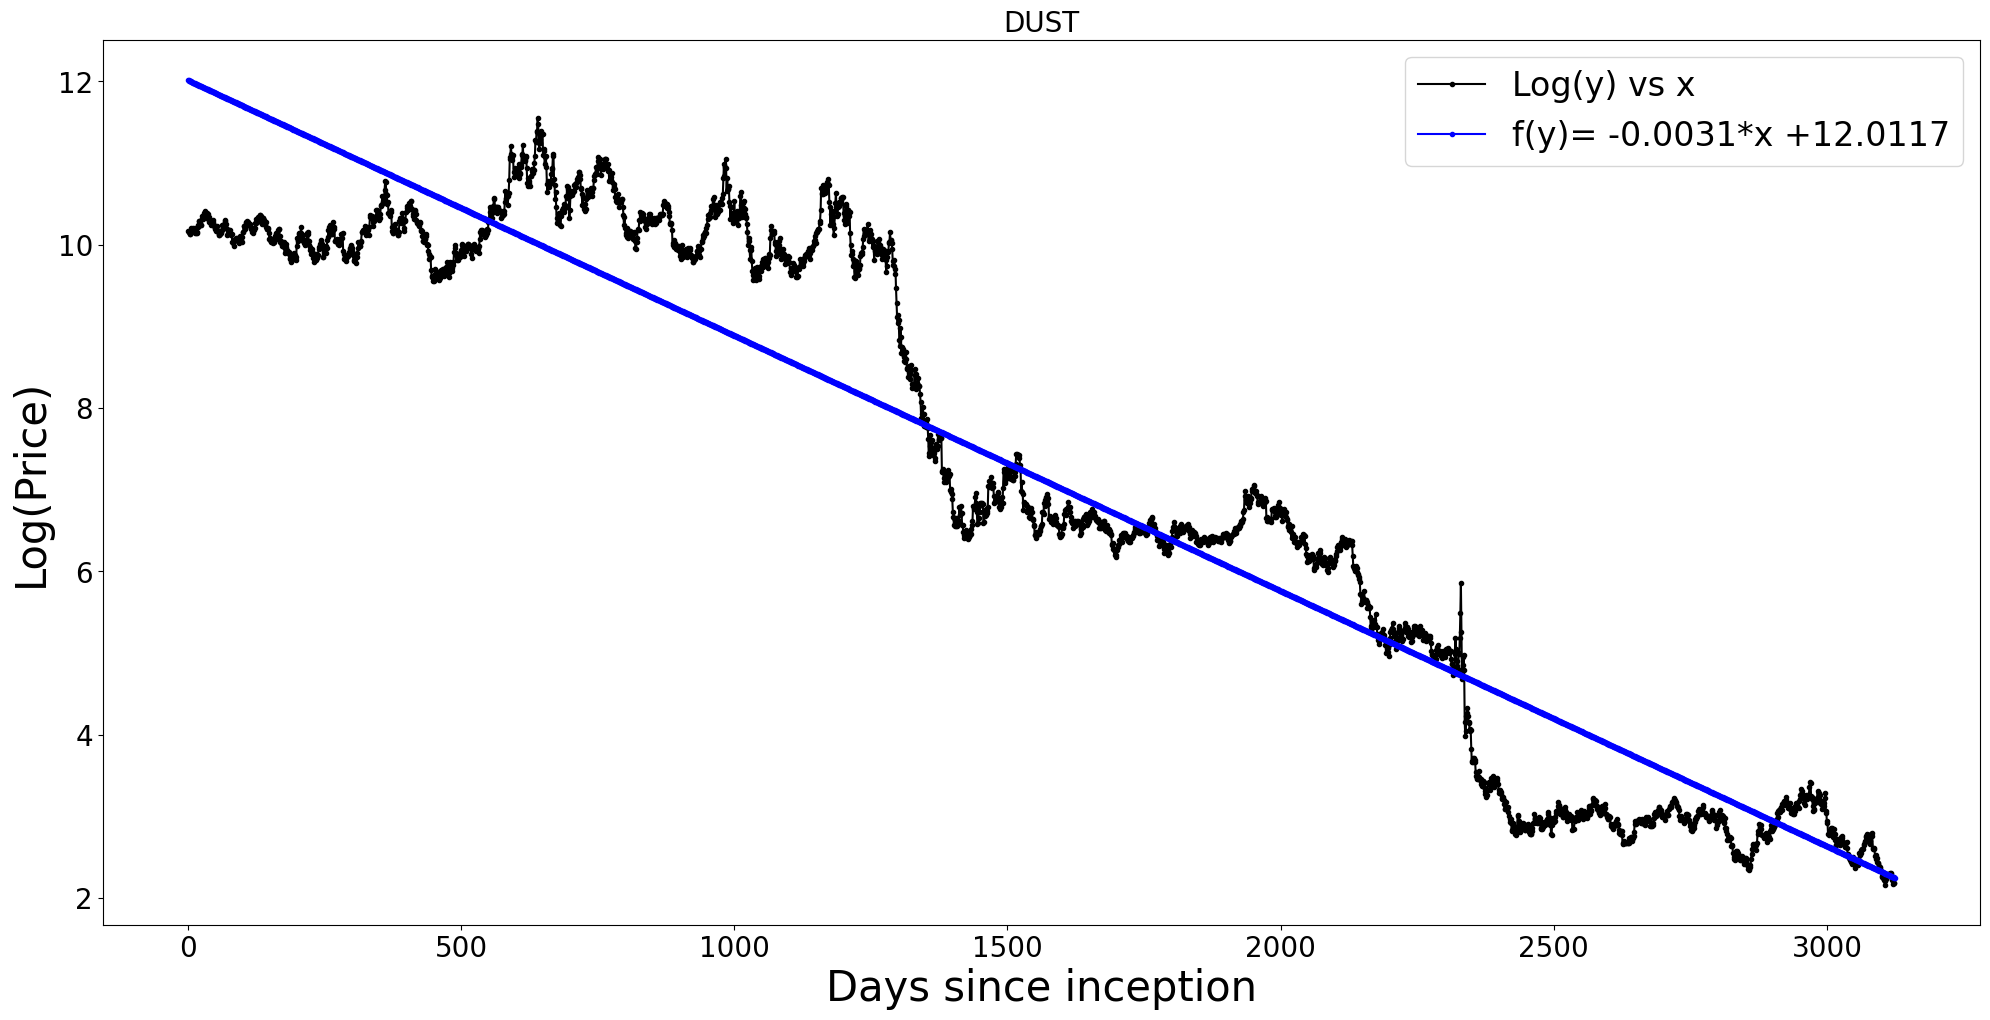

DRIP
[*********************100%***********************]  1 of 1 completed


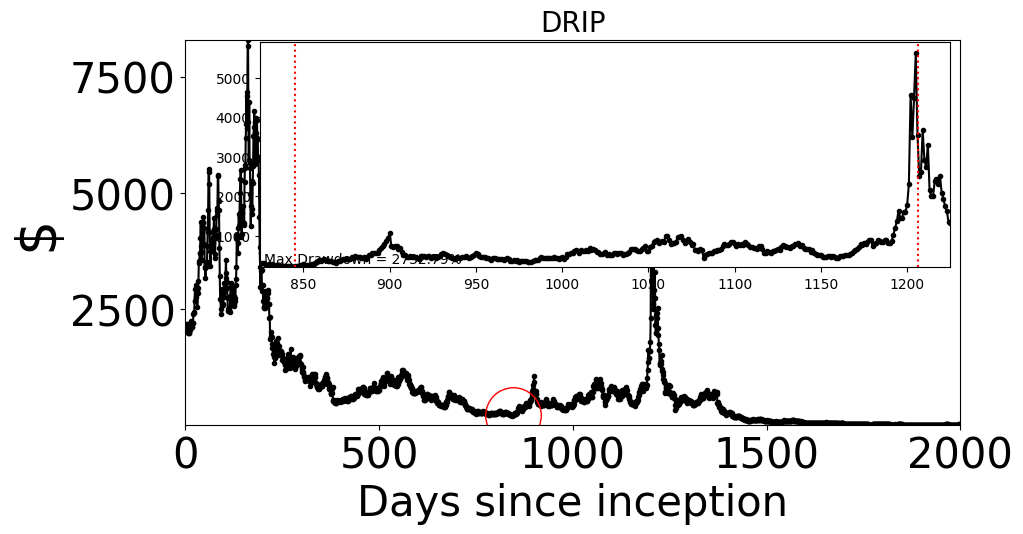

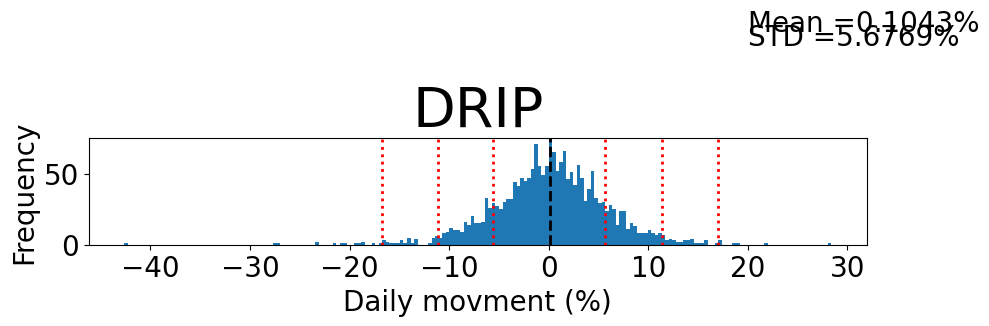

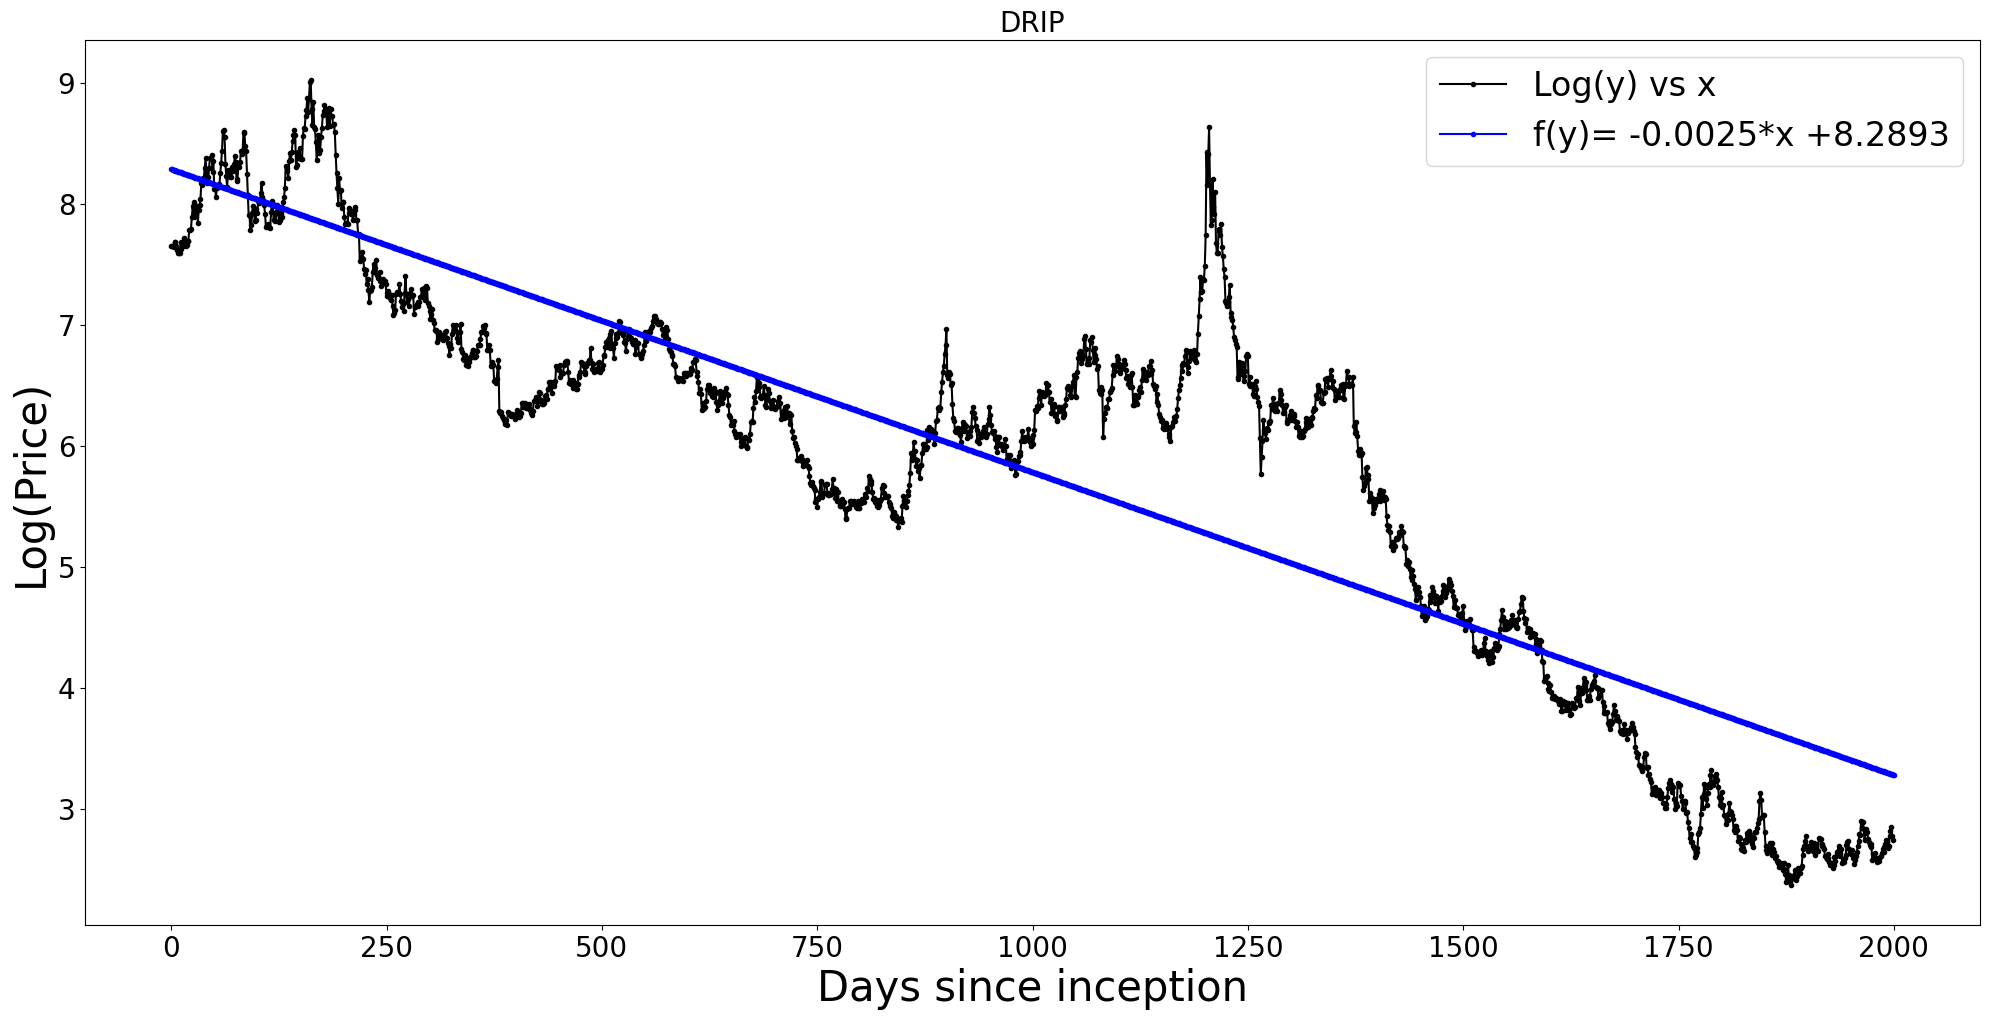

JDST
[*********************100%***********************]  1 of 1 completed


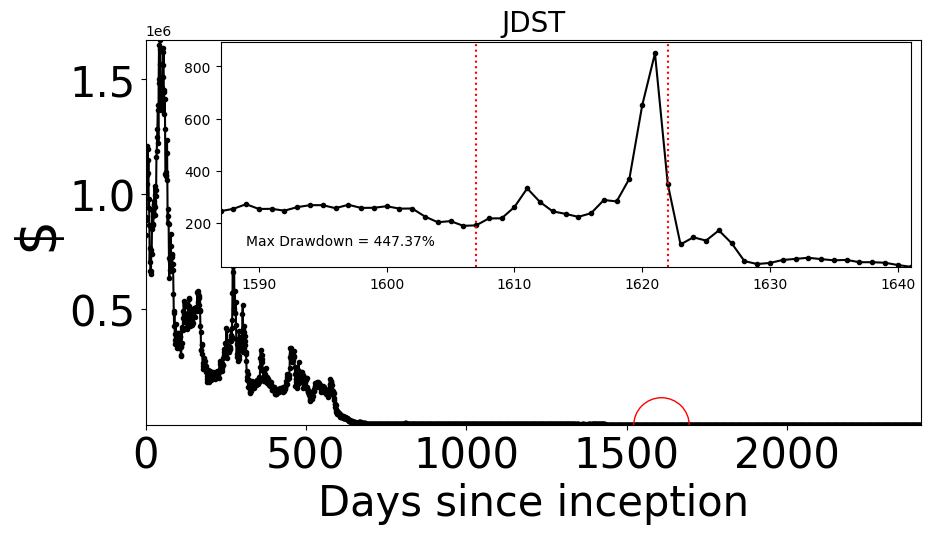

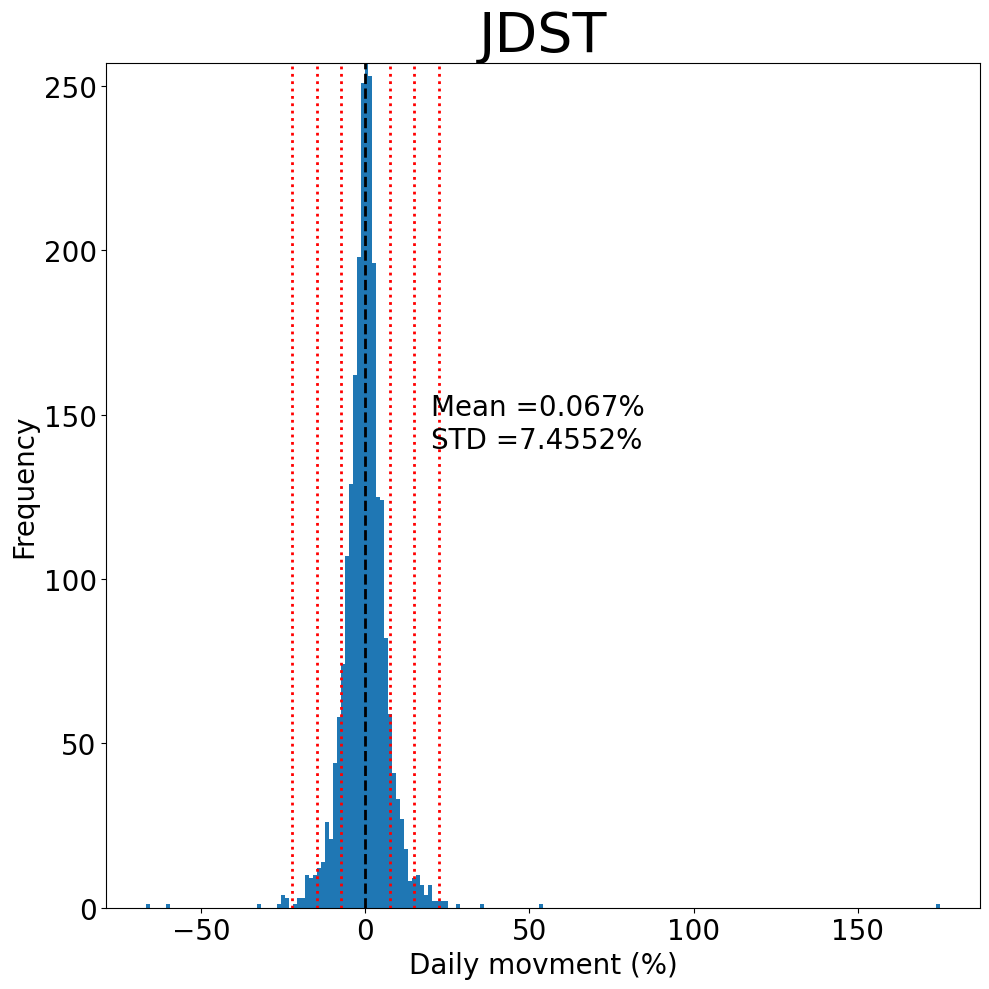

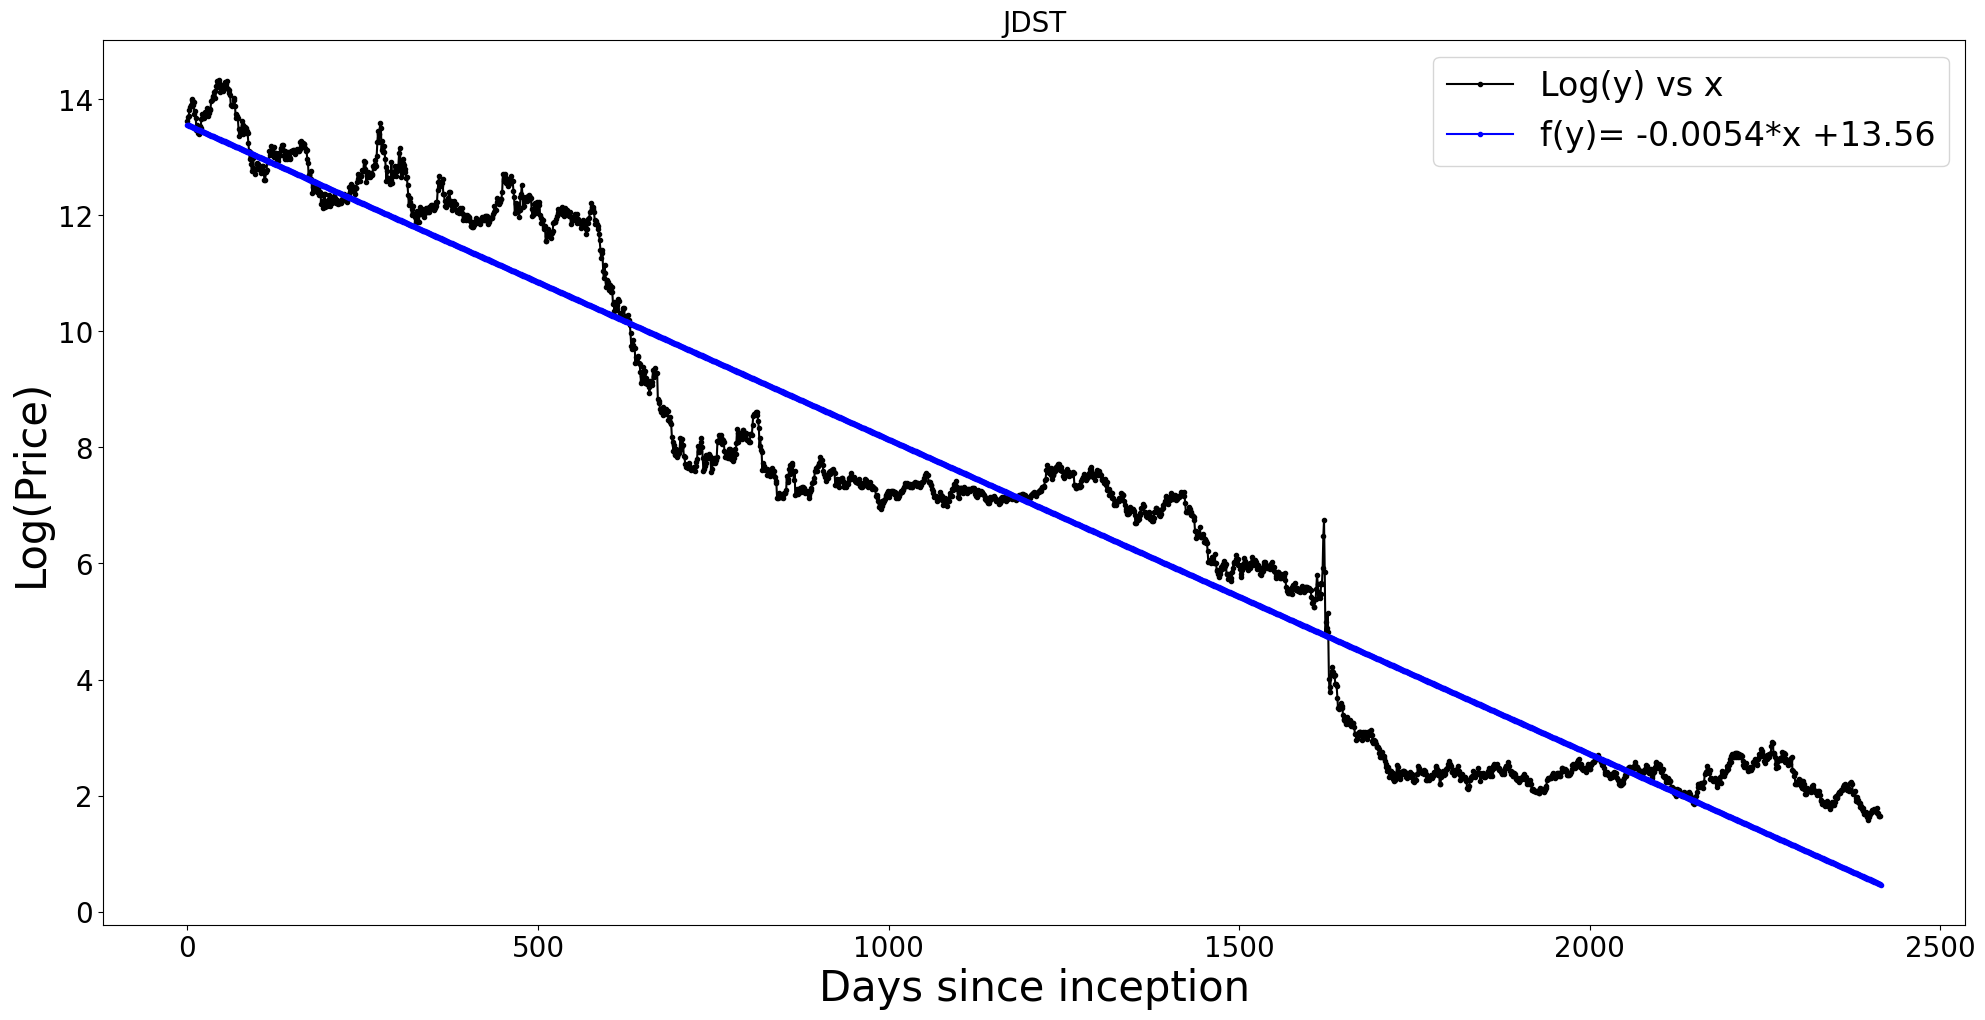

PSQ
[*********************100%***********************]  1 of 1 completed


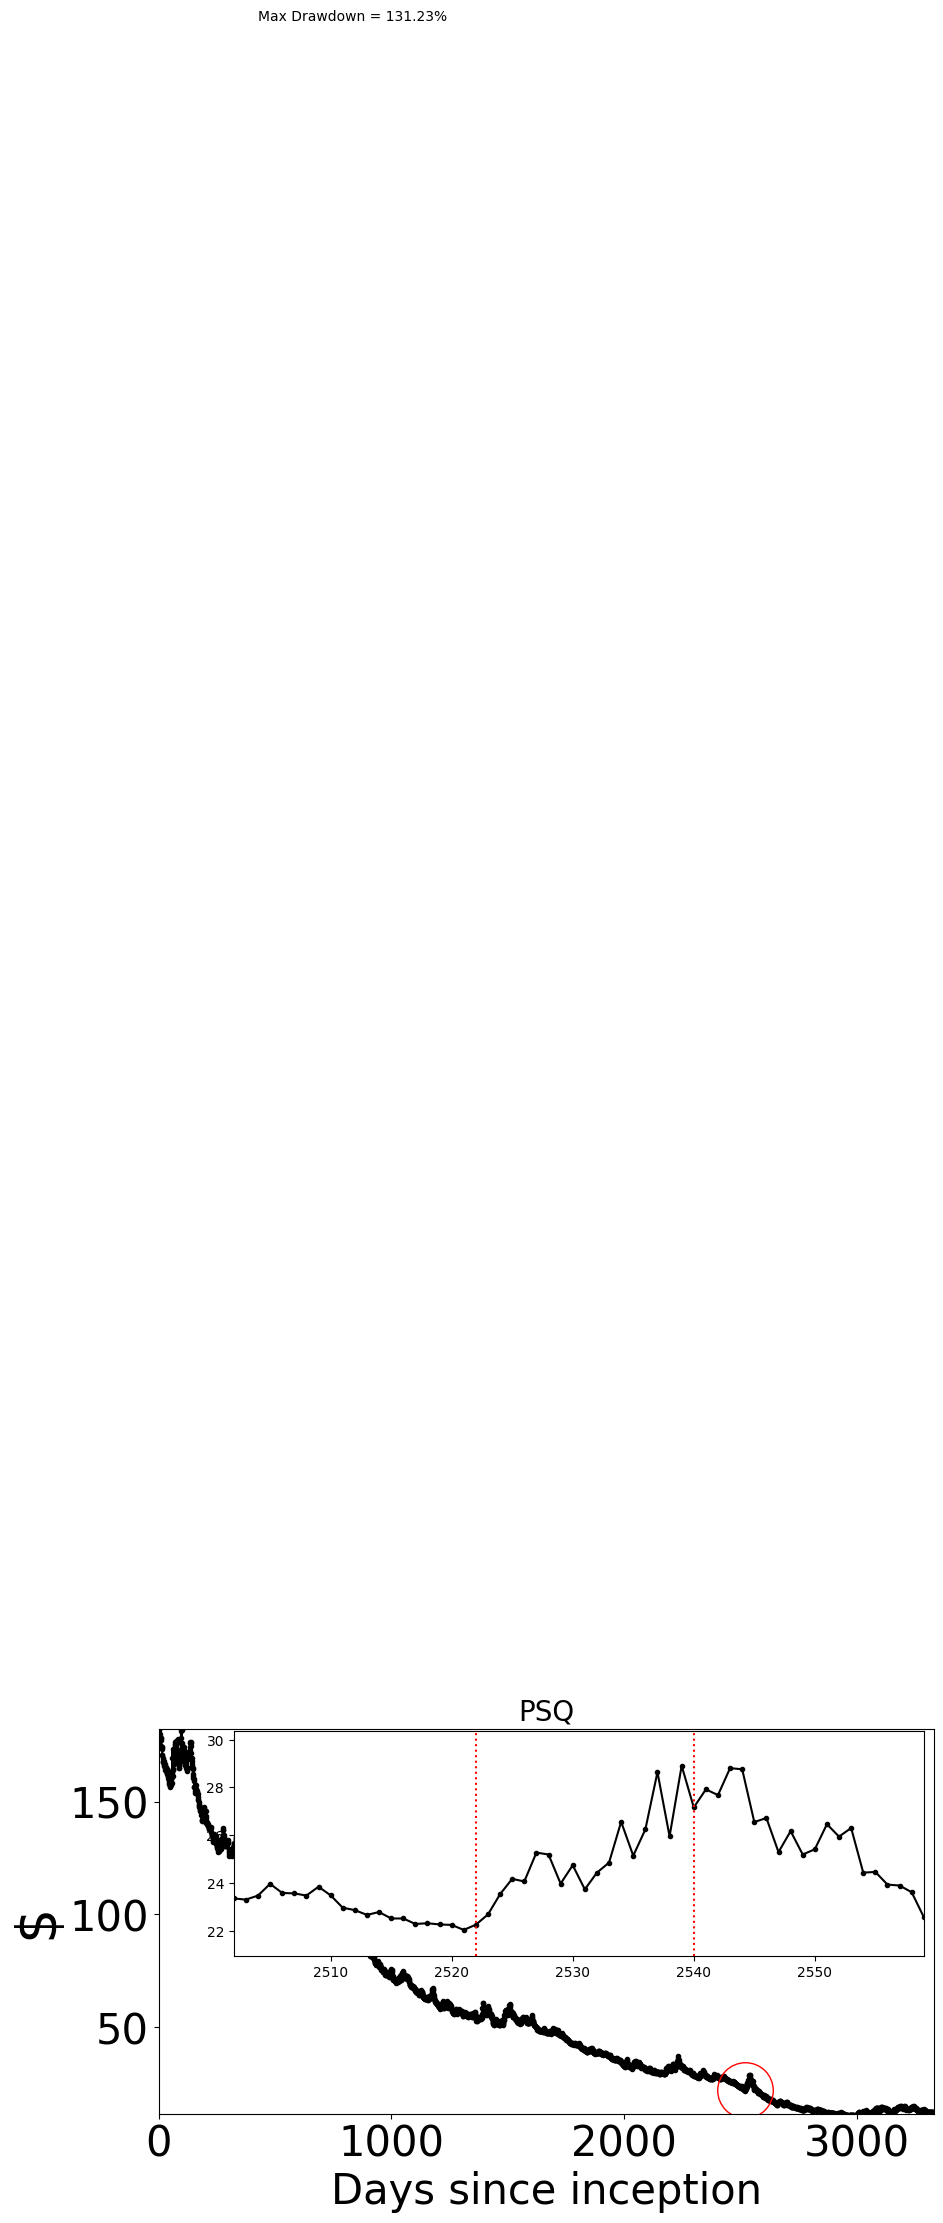

C:\Users\Scott\AppData\Local\Temp\ipykernel_4988\4208330821.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


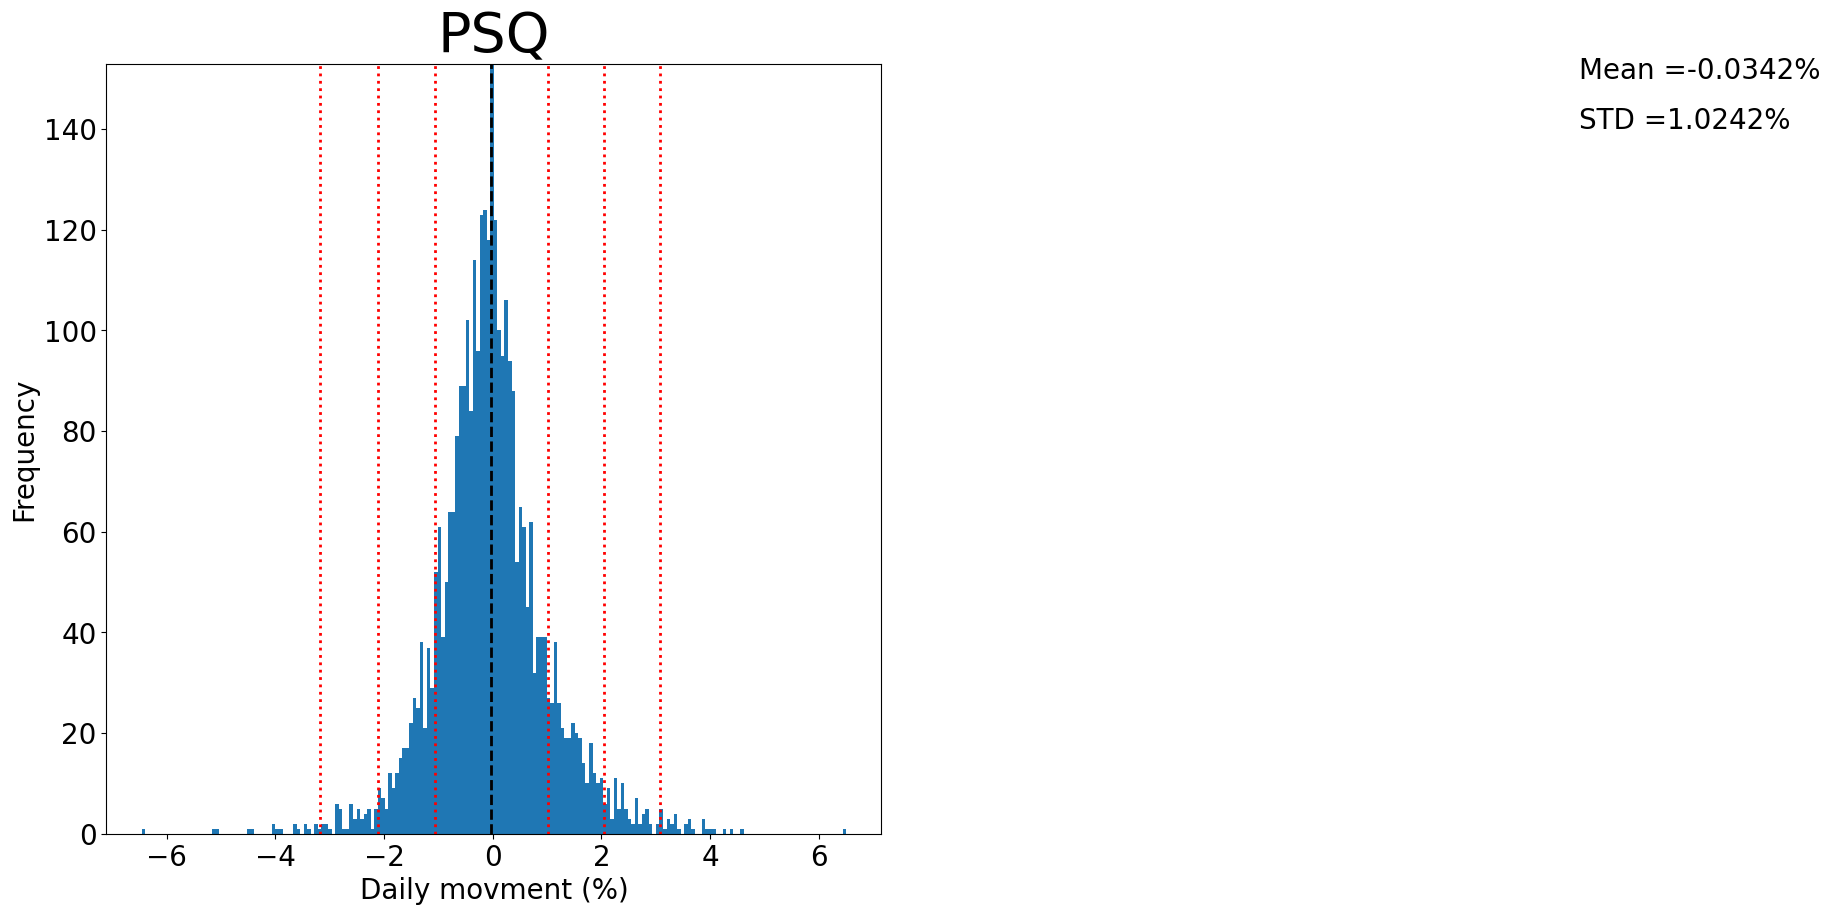

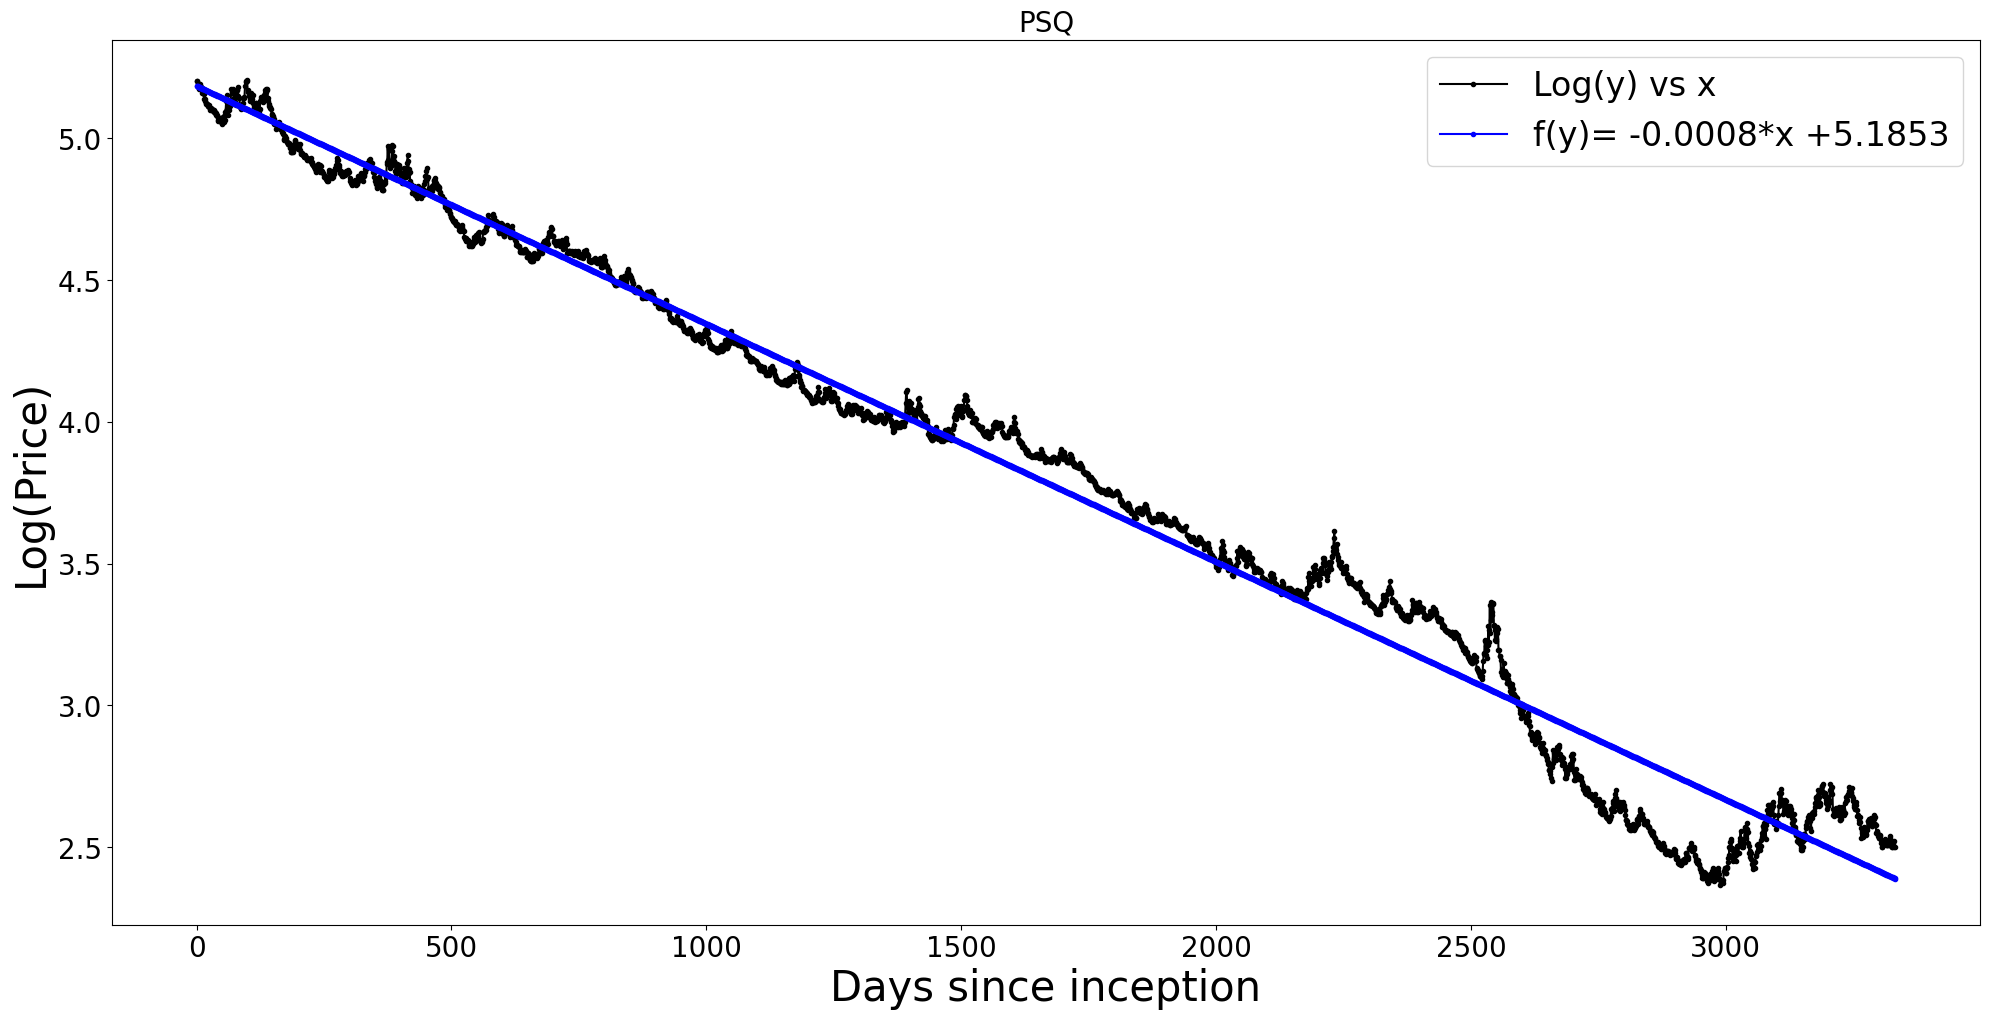

SQS
[*********************100%***********************]  1 of 1 completed


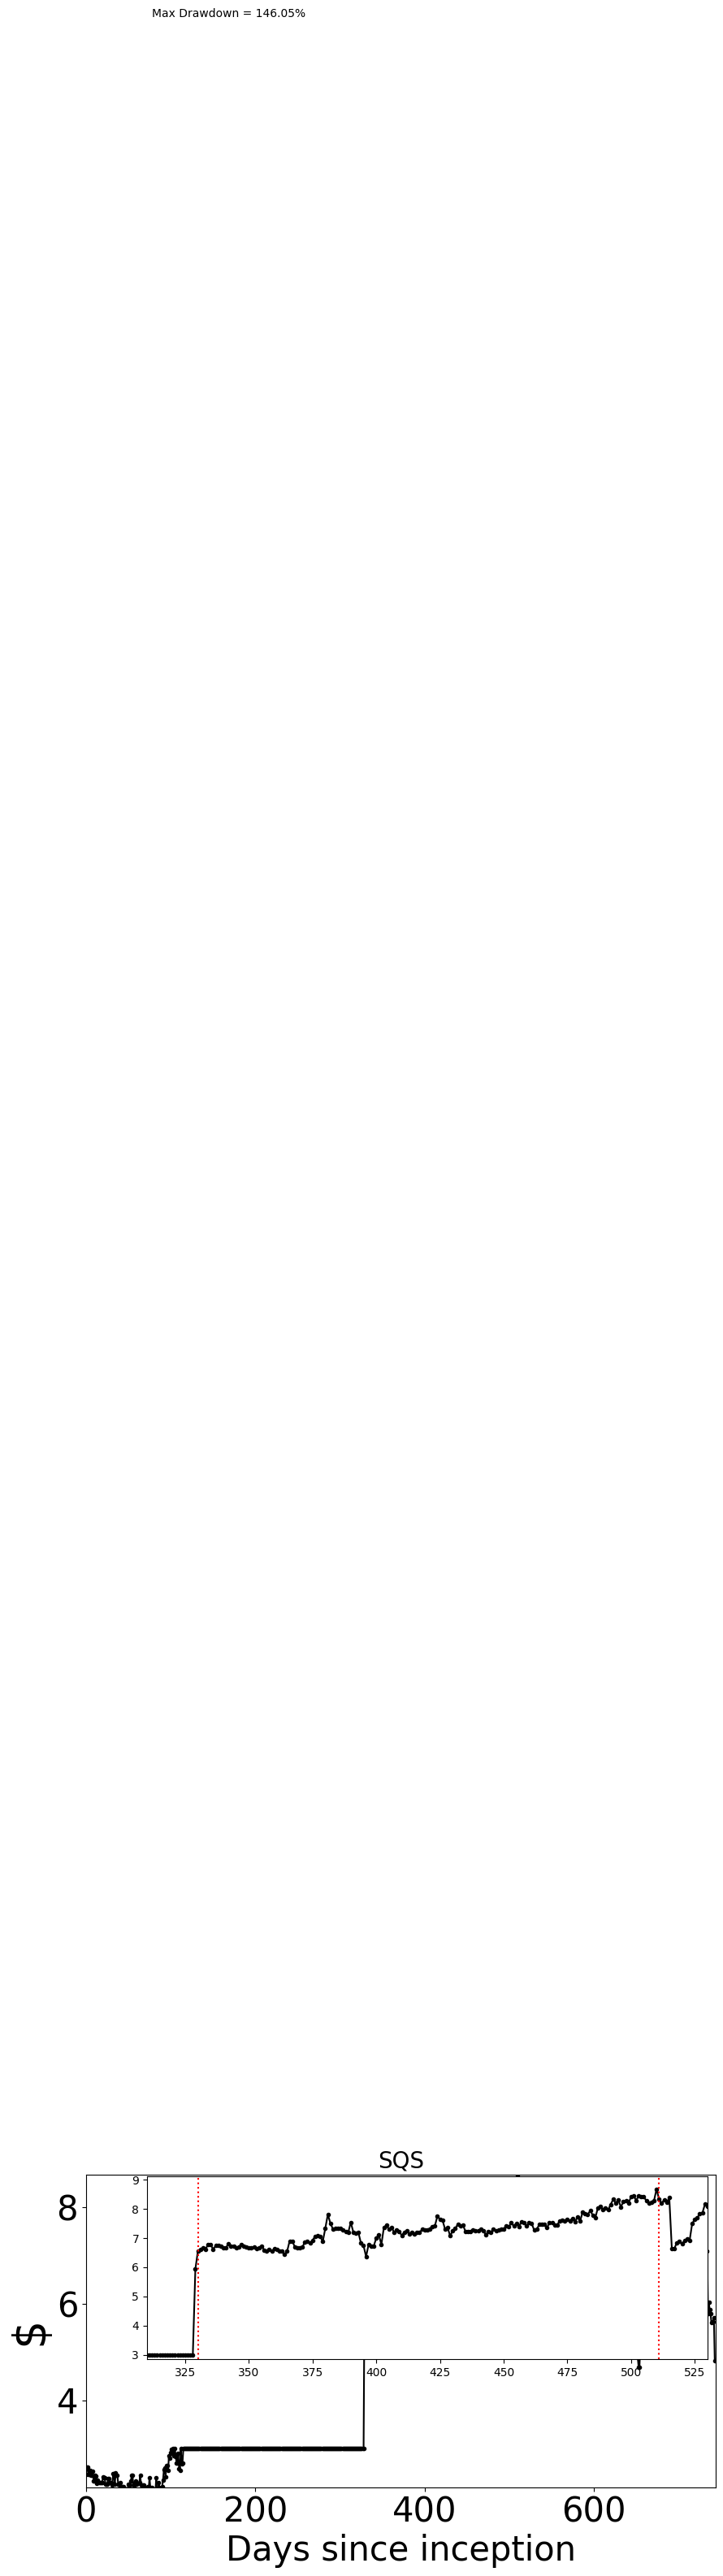

C:\Users\Scott\AppData\Local\Temp\ipykernel_4988\4208330821.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


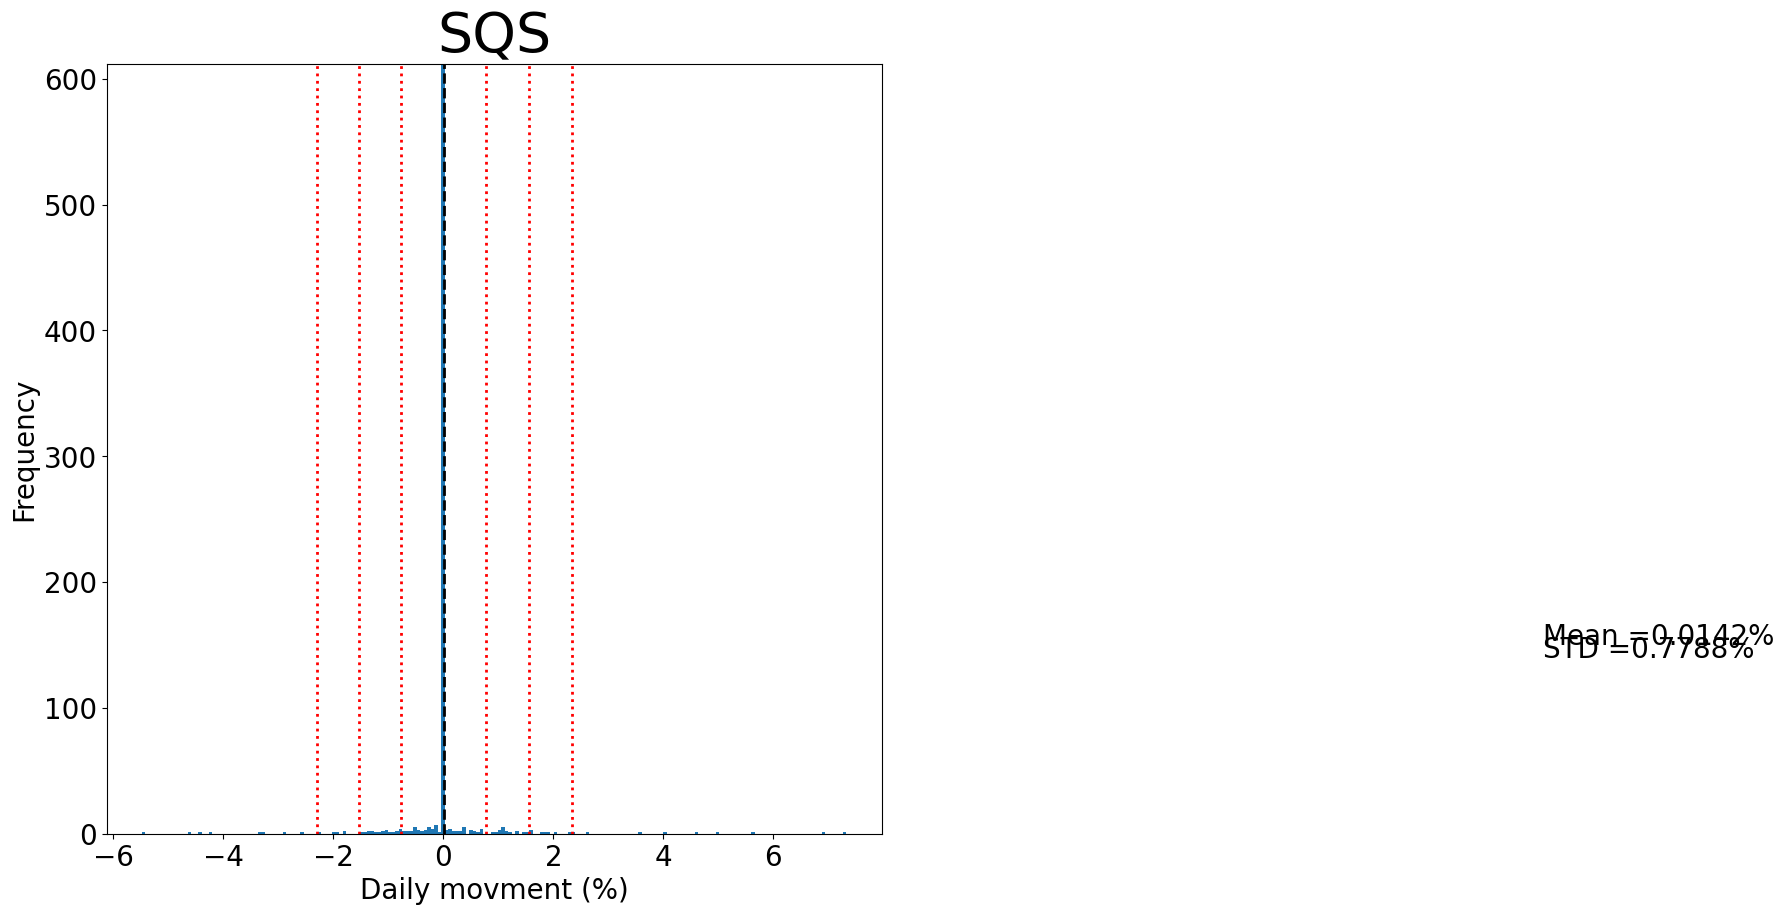

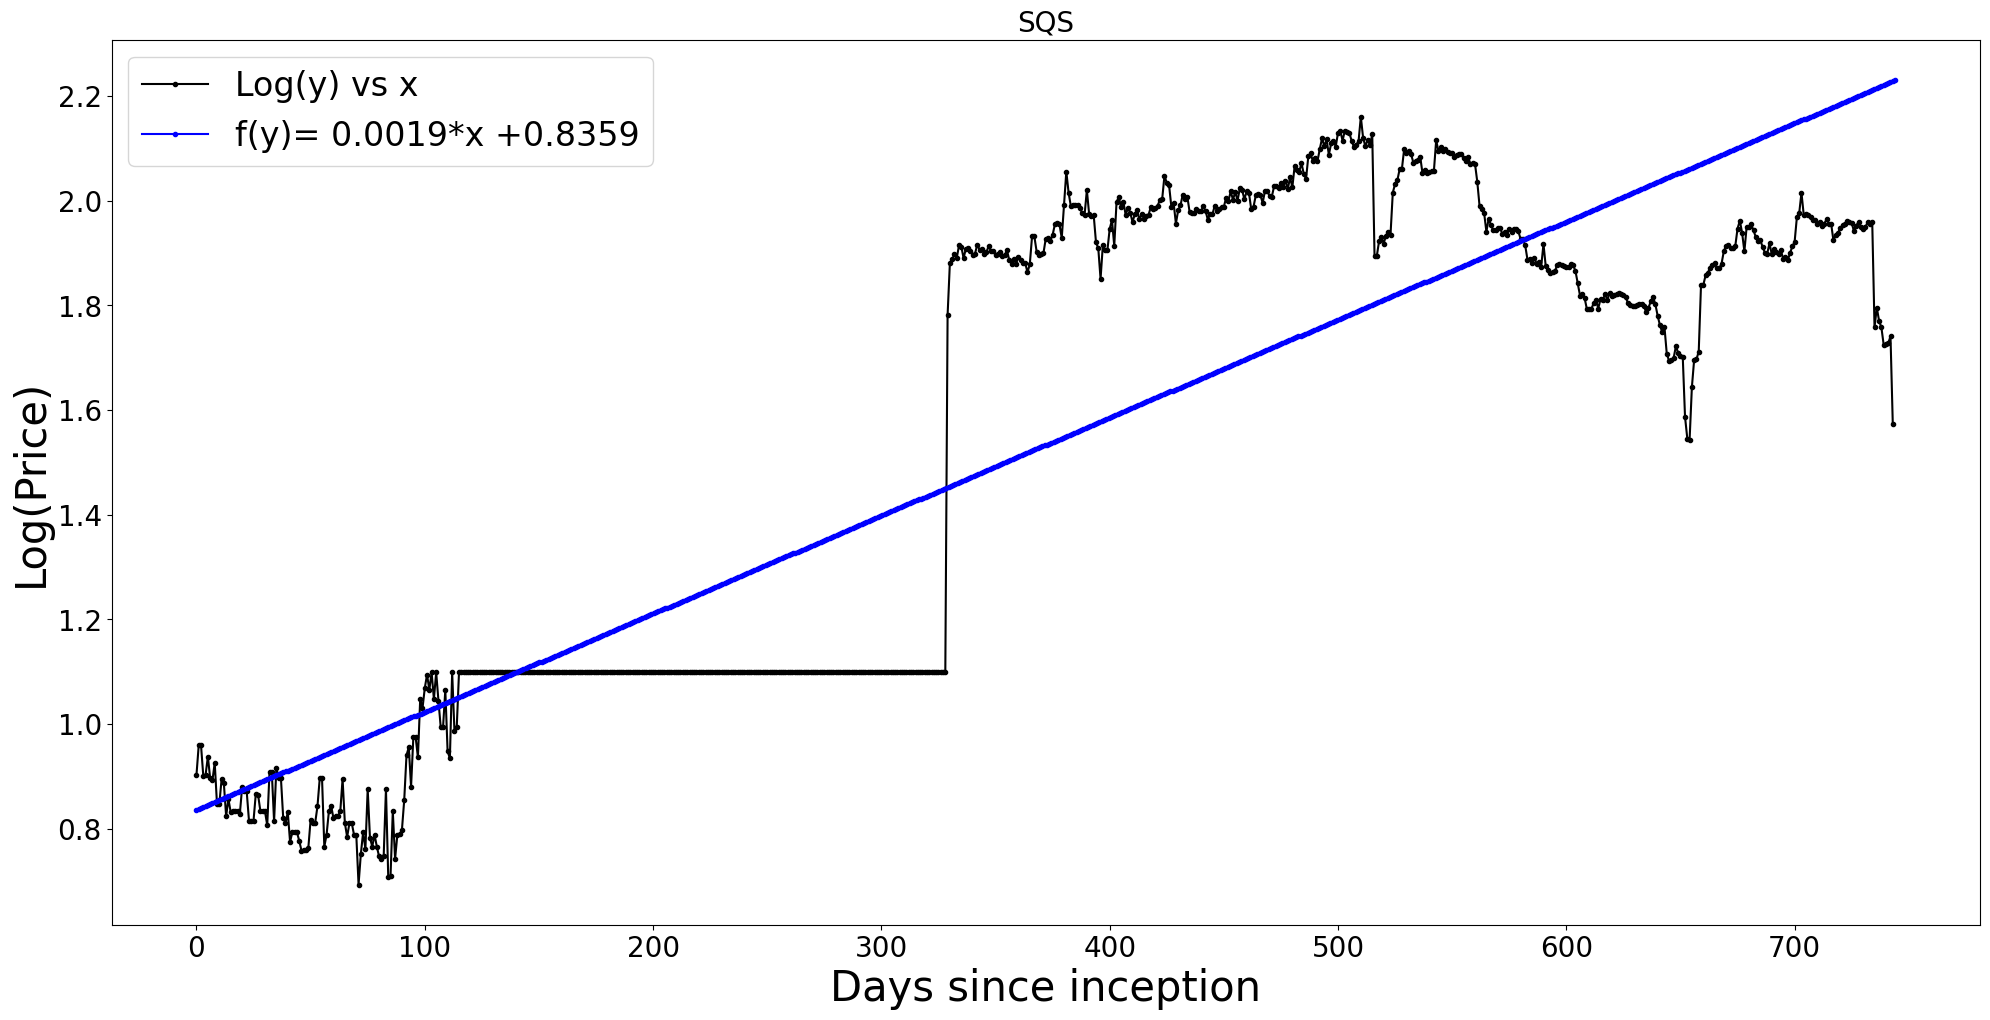

SQQQ
[*********************100%***********************]  1 of 1 completed


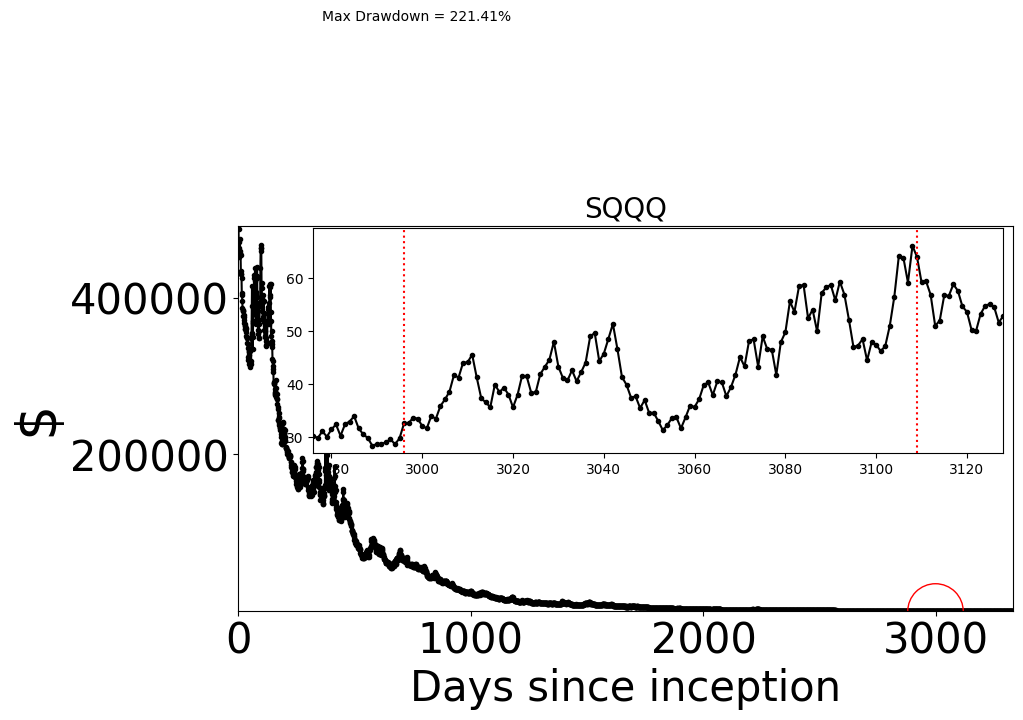

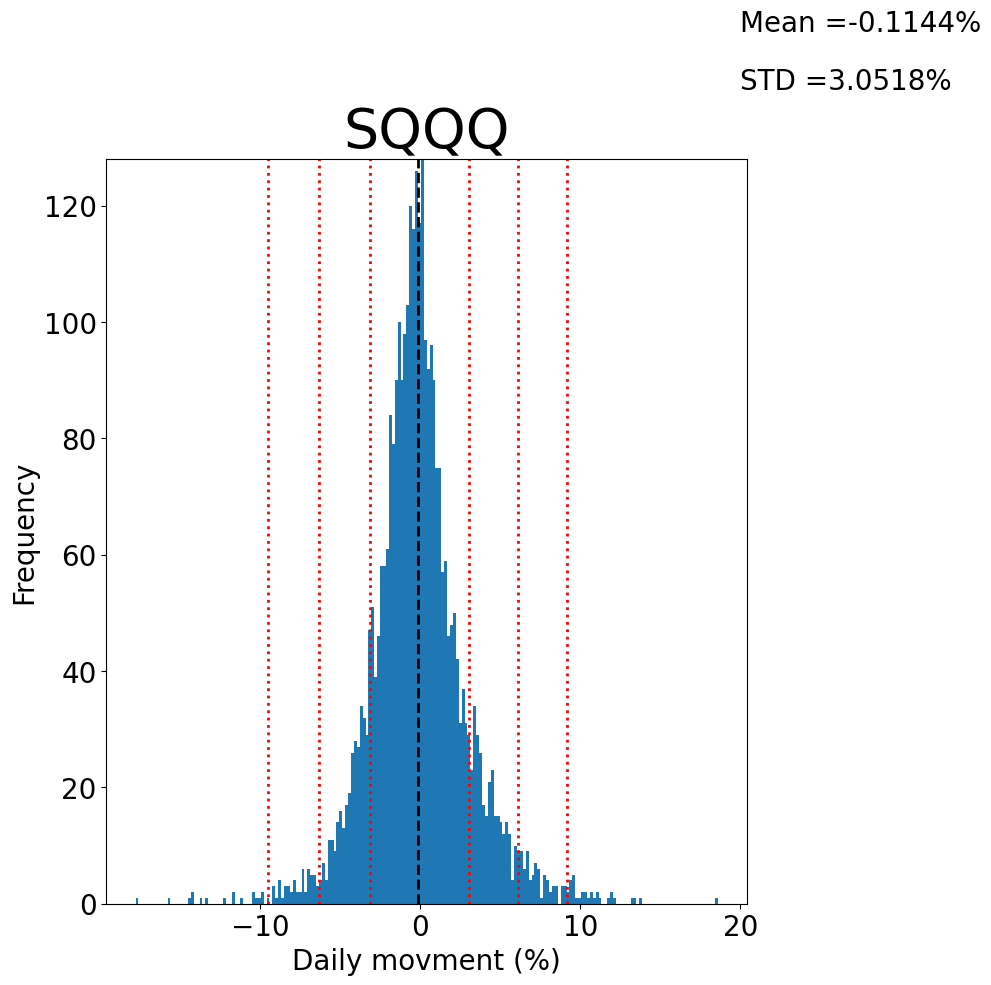

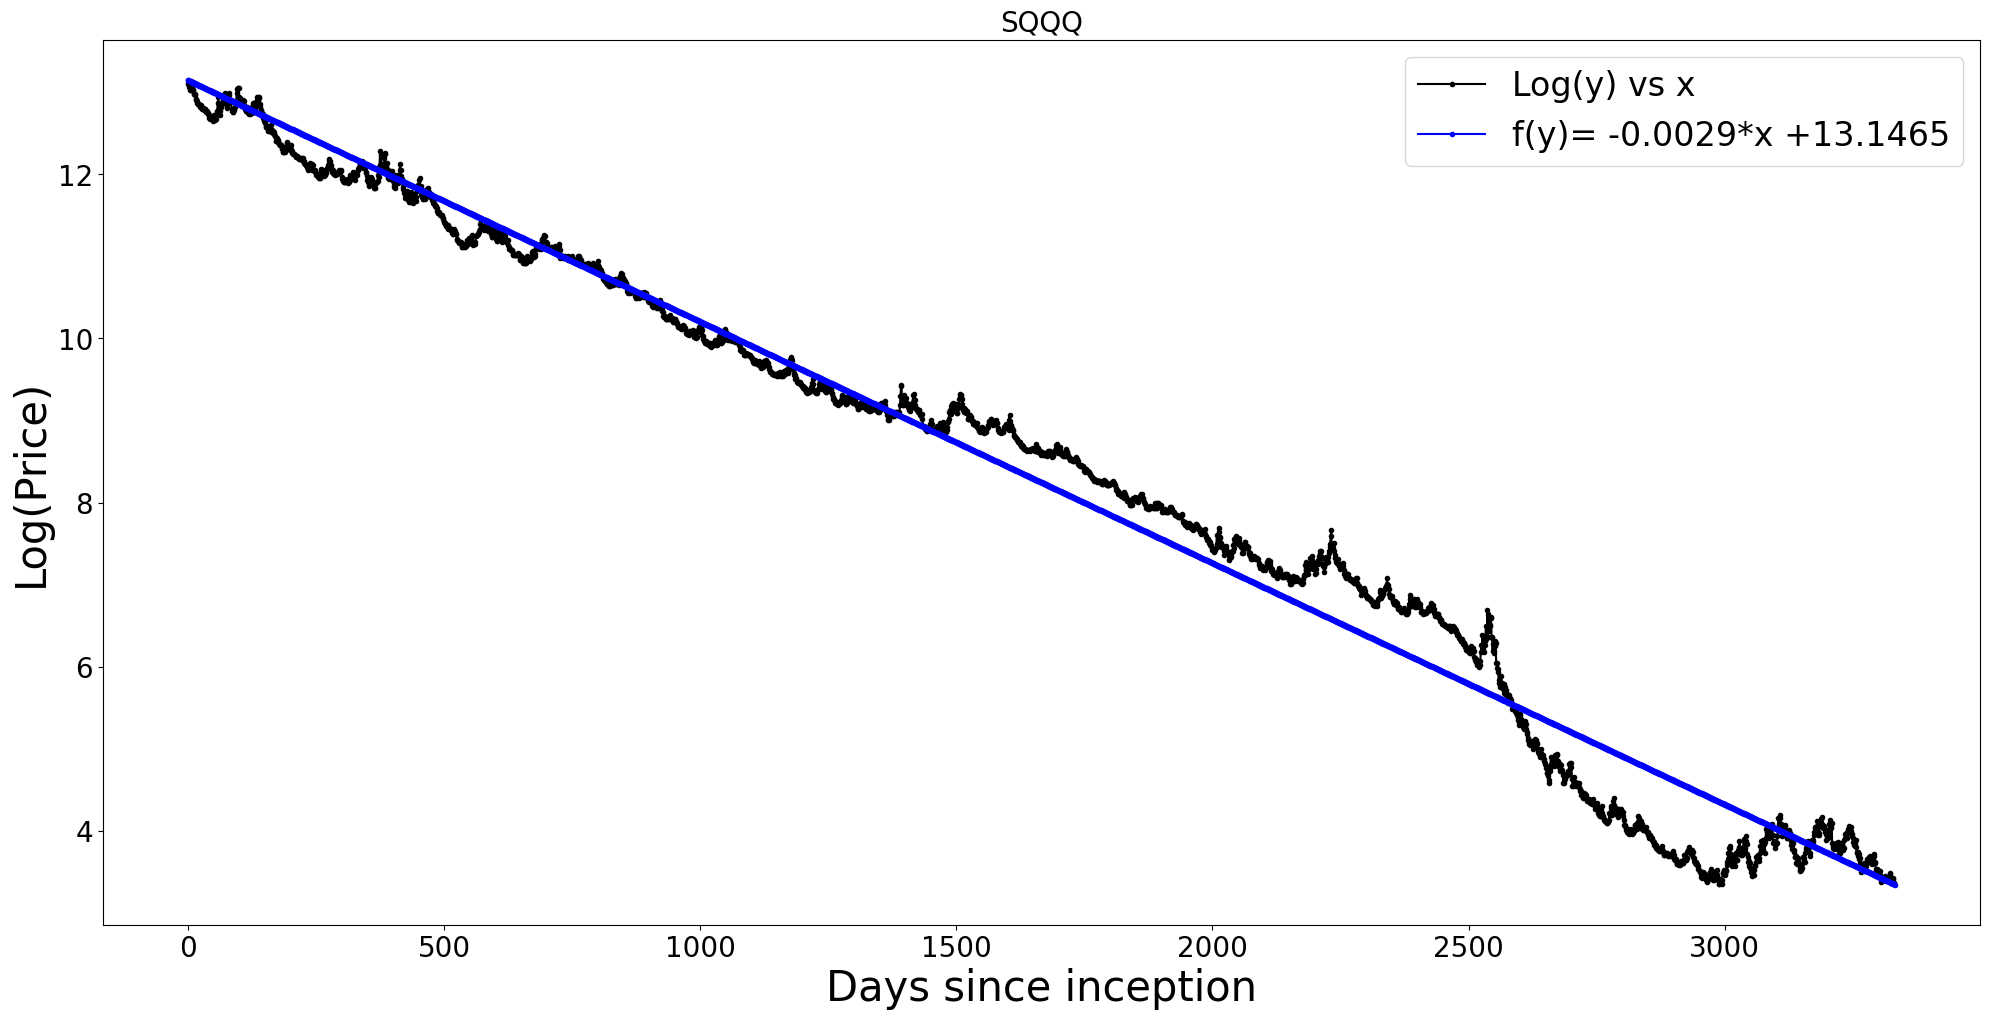

In [57]:
# iterate over assets, retrive data and make calculations  
for index in data["indices"]:
    for ticker in data["indices"][index]["Derivatives"]:
        print(ticker)
        info = getData(ticker)
        DD = largestDrawDown(info)

        x= np.arange(0,len(info.index))
        Insetplotter(x,info['Close'],str(ticker),DD,info['Percentage'],-18,80,0.,0.175,-0.01,-0.1,[20,150],[20,140])
#

        logPlot(x, info['Log Close'],str(ticker))


In [ ]:

def largestDrawDown(df):
# find worst possible drawdown:
    drawDowns=[]
    #print(len(df))
    for i in range(len(df)):
       
       if i == (len(df)-1):
           break
       else:
           v1=df['Close'].iloc[i]
           loss=True ; count = i ; DD=0. ; top=0.
           while loss:
               try:
                   count+=1
                   v2=df['Close'].iloc[count]
                   if v2<v1:
                       drawDowns.append([DD,i+1,count,top+1])
                       loss=False
                   else:
                       var= 100.*(v2/v1)
                       if var>DD:
                           DD=var
                           top=count
                       else:
                           pass
               except:
                   loss=False


    orderedDD=sorted(drawDowns,key = lambda x:x[0])
    return orderedDD
SPXS_DD = largestDrawDown(SPXS)
print(SPXS_DD[-1])

In [ ]:
def Insetplotter(x,y,name,DD,percentSet,xshift,yshift,left,bottom,width,height,loc1,loc2):
    #Plot price against time
    plt.figure(1,[10,5])
    DDstart = DD[-1][1] ; DDend = DD[-1][2]
    plt.plot(x,y,'k.-')
    #plt.scatter(DDstart,y[DDstart],s=20, facecolors='none', edgecolors='r')
    plt.plot(DDstart,y[DDstart],'ro',markersize=40,fillstyle='none')
    #plt.arrow(1500,15000,750,-11500,color='r')
    plt.axis([0, len(x), 1.1*np.amin(y), np.amax(y)])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.xlabel('Days since inception',fontsize=30)
    plt.ylabel('$',fontsize=40)
    plt.xlim(0.,len(x))
    
    plt.title(name,fontsize=20)
     
    #Plot inset of logged version with fit line
    DDstart = DD[-1][1] ; DDend = DD[-1][-1]
    xx=x[DDstart-20:DDend+20] ; yy=y[DDstart-20:DDend+20]
    a= plt.axes([0.2+left,0.25+bottom,0.7+width,0.55+height])    # [left,bottom,width,height]
    plt.plot(xx,yy,'k.-')
    
    plt.plot([DDstart,DDstart],[np.amin(yy)*0.95,np.amax(yy)*1.05],'r:')
    plt.plot([DDend,DDend],[np.amin(yy)*0.95,np.amax(yy)*1.05],'r:')
    plt.ylim(np.amin(yy)*0.95,np.amax(yy)*1.05)
    plt.xlim(xx[0],xx[-1])
    l1='Max Drawdown = '+str(round(DD[-1][0],2))+'%'
    plt.text(DDstart+xshift,np.amin(yy)+yshift,l1,fontsize=10)
    #plt.savefig('plots//'+'DD '+name+'.png',bbox_inches="tight")
    #plt.tight_layout()
    plt.show()
    
    def distributionPlot(percentSet,name,loc1,loc2):
        # Histogram of daily percentage movments
        percentSet=(percentSet-1.)*100.
        #Plot params
        fig= plt.figure(1,[10,10])
        ax = fig.add_subplot(1, 1, 1)
        ax.tick_params(axis='both', which='major', labelsize=20)
        var= ax.hist(percentSet,bins=200)
        plotHeight=sorted(var[0])
        plotWidth=sorted(var[1])
        plt.xlabel('Daily movment (%)',fontsize=20)
        plt.ylabel('Frequency',fontsize=20)
        plt.ylim(plotHeight[0],plotHeight[-1])
        plt.title(name,fontsize=40)
        # Stats
        mean,std=norm.fit(percentSet)
        std1=[std,std] ;std2=[2*std,2*std];std3=[3*std,3*std]
        Nstd1=[(-std+mean),(-std+mean)] ;Nstd2=[2*(-std+mean),2*(-std+mean)];Nstd3=[3*(-std+mean),3*(-std+mean)]
        aveX=[mean,mean]; aveY=[0,plotHeight[-1]+5]
        #plot and save
        plt.plot(aveX,aveY,'k--',linewidth=2)
        plt.plot(std1,aveY,'r:',linewidth=2)
        plt.plot(std2,aveY,'r:',linewidth=2)
        plt.plot(std3,aveY,'r:',linewidth=2)
        plt.plot(Nstd1,aveY,'r:',linewidth=2)
        plt.plot(Nstd2,aveY,'r:',linewidth=2)
        plt.plot(Nstd3,aveY,'r:',linewidth=2)
        m='Mean ='+str(round(mean,4))+'%'
        s='STD ='+str(round(std,4))+'%'
        plt.text(loc1[0],loc1[1],m,fontsize=20)
        plt.tight_layout()
        plt.text(loc2[0],loc2[1],s,fontsize=20)
        #plt.savefig('plots//'+name+'Distribution'+'.png',bbox_inches="tight")
        plt.show()
        
    distributionPlot(percentSet,name,loc1,loc2)

    
def logPlot(x,y,name):

    fig= plt.figure(5,[20,10])
    ax = fig.add_subplot(1, 1, 1)
    #plt.plot(x,y,'b.-')
    #lx=np.log10(cp)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

    string1='f(y)= '+str(round(slope,4))+'*x'+' +'+str(round(intercept,4))
    xFit=np.linspace(0,len(x),num=len(x))
    yFit=slope*xFit+intercept
    ax.plot(x,y,'k.-',label='Log(y) vs x')
    ax.plot(xFit,yFit,'b.-',label=string1)
    plt.legend(prop={'size': 24})
    #ax.set_xlim(0,xlim)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.xlabel('Days since inception',fontsize=30)
    plt.ylabel('Log(Price)',fontsize=30)
    plt.tight_layout()
    plt.title(name,fontsize=20)
    #plt.savefig('plots//'+'log'+name+'.png',bbox_inches="tight")
    plt.show()
    

# Build plots
# args format (x,y,name,DD,percentSet,xshift,yshift,left,bottom,width,height,loc1,loc2)



In [ ]:








"""
starting=1000.
sqe, sqePercent = [], [] 
for i in range(len(NAZ100op)):
    if i == 0:
        sqe.append(starting)
        sqePercent.append(1.)

    else:
        yDay=sqe[i-1]
        tDay=yDay*(3.*(1.-NAZ100percent[i])+1.)
        sqePercent.append((3.*(1.-NAZ100percent[i])+1.))
        sqe.append(tDay)
        
sqe = np.array(sqe) ; sqeLog = np.log(sqe)
sqePercent=np.array(sqePercent)

# Calculate all possible drawdowns
FAZDD = largestDrawDown(FAZindex, FAZcp)
SDOWDD = largestDrawDown(SDOWindex, SDOWcp)
SPXSDD = largestDrawDown(SPXSindex, SPXScp)
SQQQDD = largestDrawDown(SQQQindex, SQQQcp)
TZADD = largestDrawDown(TZAindex, TZAcp)
DRIPDD = largestDrawDown(DRIPindex, DRIPcp)
LABDDD = largestDrawDown(LABDindex, LABDcp)
SVXYDD = largestDrawDown(SVXYindex, SVXYcp)
SQQQDDEquiv = largestDrawDown(NAZ100index,sqe)
DUSTDD = largestDrawDown(DUSTindex, DUSTcp)
JDSTDD = largestDrawDown(JDSTindex, JDSTcp)

def Insetplotter(x,y,name,DD,percentSet,xshift,yshift,left,bottom,width,height,loc1,loc2):
    #Plot price against time
    plt.figure(1,[10,5])
    DDstart = DD[-1][1] ; DDend = DD[-1][2]
    plt.plot(x,y,'k.-')
    #plt.scatter(DDstart,y[DDstart],s=20, facecolors='none', edgecolors='r')
    plt.plot(DDstart,y[DDstart],'ro',markersize=40,fillstyle='none')
    #plt.arrow(1500,15000,750,-11500,color='r')
    plt.axis([0, len(x), 1.1*np.amin(y), np.amax(y)])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.xlabel('Days since inception',fontsize=30)
    plt.ylabel('$',fontsize=40)
    plt.xlim(0.,len(x))
    
    plt.title(name,fontsize=20)
     
    #Plot inset of logged version with fit line
    DDstart = DD[-1][1] ; DDend = DD[-1][-1]
    xx=x[DDstart-20:DDend+20] ; yy=y[DDstart-20:DDend+20]
    a= plt.axes([0.2+left,0.25+bottom,0.7+width,0.55+height])    # [left,bottom,width,height]
    plt.plot(xx,yy,'k.-')
    
    plt.plot([DDstart,DDstart],[np.amin(yy)*0.95,np.amax(yy)*1.05],'r:')
    plt.plot([DDend,DDend],[np.amin(yy)*0.95,np.amax(yy)*1.05],'r:')
    plt.ylim(np.amin(yy)*0.95,np.amax(yy)*1.05)
    plt.xlim(xx[0],xx[-1])
    l1='Max Drawdown = '+str(round(DD[-1][0],2))+'%'
    plt.text(DDstart+xshift,np.amin(yy)+yshift,l1,fontsize=10)
    plt.savefig('plots//'+'DD '+name+'.png',bbox_inches="tight")
    #plt.tight_layout()
    plt.show()
    
    def distributionPlot(percentSet,name,loc1,loc2):
        # Histogram of daily percentage movments
        percentSet=(percentSet-1.)*100.
        #Plot params
        fig= plt.figure(1,[10,10])
        ax = fig.add_subplot(1, 1, 1)
        ax.tick_params(axis='both', which='major', labelsize=20)
        var= ax.hist(percentSet,bins=200)
        plotHeight=sorted(var[0])
        plotWidth=sorted(var[1])
        plt.xlabel('Daily movment (%)',fontsize=20)
        plt.ylabel('Frequency',fontsize=20)
        plt.ylim(plotHeight[0],plotHeight[-1])
        plt.title(name,fontsize=40)
        # Stats
        mean,std=norm.fit(percentSet)
        std1=[std,std] ;std2=[2*std,2*std];std3=[3*std,3*std]
        Nstd1=[(-std+mean),(-std+mean)] ;Nstd2=[2*(-std+mean),2*(-std+mean)];Nstd3=[3*(-std+mean),3*(-std+mean)]
        aveX=[mean,mean]; aveY=[0,plotHeight[-1]+5]
        #plot and save
        plt.plot(aveX,aveY,'k--',linewidth=2)
        plt.plot(std1,aveY,'r:',linewidth=2)
        plt.plot(std2,aveY,'r:',linewidth=2)
        plt.plot(std3,aveY,'r:',linewidth=2)
        plt.plot(Nstd1,aveY,'r:',linewidth=2)
        plt.plot(Nstd2,aveY,'r:',linewidth=2)
        plt.plot(Nstd3,aveY,'r:',linewidth=2)
        m='Mean ='+str(round(mean,4))+'%'
        s='STD ='+str(round(std,4))+'%'
        plt.text(loc1[0],loc1[1],m,fontsize=20)
        plt.tight_layout()
        plt.text(loc2[0],loc2[1],s,fontsize=20)
        plt.savefig('plots//'+name+'Distribution'+'.png',bbox_inches="tight")
        plt.show()
        
    distributionPlot(percentSet,name,loc1,loc2)

    
def logPlot(x,y,name,xlim):

    fig= plt.figure(5,[20,10])
    ax = fig.add_subplot(1, 1, 1)
    #plt.plot(x,y,'b.-')
    #lx=np.log10(cp)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

    string1='f(y)= '+str(round(slope,4))+'*x'+' +'+str(round(intercept,4))
    xFit=np.linspace(0,len(x),num=len(x))
    yFit=slope*xFit+intercept
    ax.plot(x,y,'k.-',label='Log(y) vs x')
    ax.plot(xFit,yFit,'b.-',label=string1)
    plt.legend(prop={'size': 24})
    ax.set_xlim(0,xlim)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.xlabel('Days since inception',fontsize=30)
    plt.ylabel('Log(Price)',fontsize=30)
    plt.tight_layout()
    plt.title(name,fontsize=20)
    plt.savefig('plots//'+'log'+name+'.png',bbox_inches="tight")
    plt.show()
    

# Build plots
# args format (x,y,name,DD,percentSet,xshift,yshift,left,bottom,width,height,loc1,loc2)

Insetplotter(JDSTindex,JDSTcp,'JDST',JDSTDD,JDSTpercent,0,0,0.25,0.33,-0.25,-0.25,[0,0],[0,0])
logPlot(JDSTindex,JDSTlog,'JDST',2450)

Insetplotter(DUSTindex,DUSTcp,'DUST',DUSTDD,DUSTpercent,0,80000,0.25,0.33,-0.25,-0.25,[0,0],[0,0])
logPlot(DUSTindex,DUSTlog,'DUST',2450)

Insetplotter(FAZindex,FAZcp,'FAZ',FAZDD,FAZpercent,-18,80,0.0,0.175,0.0,-0.1,[32,210],[32,200])
logPlot(FAZindex,FAZlog,'FAZ',2450)

Insetplotter(SDOWindex,SDOWcp,'SDOW',SDOWDD,SDOWpercent,-18,80,0.1,0.175,-0.1,-0.1,[20,160],[20,150])
logPlot(SDOWindex,SDOWlog,'SDOW',2450)

Insetplotter(SPXSindex,SPXScp,'SPXS',SPXSDD,SPXSpercent,-18,80,0.,0.175,-0.01,-0.1,[20,150],[20,140])
logPlot(SPXSindex,SPXSlog,'SPXS',2450)

Insetplotter(SQQQindex,SQQQcp,'SQQQ',SQQQDD,SQQQpercent,-18,80,0.1,0.175,-0.1,-0.1,[21,120],[21,110])
logPlot(SQQQindex,SQQQlog,'SQQQ',2450)

Insetplotter(TZAindex,TZAcp,'TZA',TZADD,TZApercent,1,580,0.0,0.175,0.0,-0.1,[27,115],[27,110])
logPlot(TZAindex,TZAlog,'TZA',2450)

Insetplotter(DRIPindex,DRIPcp,'DRIP',DRIPDD,DRIPpercent,1,500,0.1,0.175,-0.1,-0.1,[32,55],[32,52.5])
logPlot(DRIPindex,DRIPlog,'DRIP',DRIPindex[-1])

Insetplotter(LABDindex,LABDcp,'LABD',LABDDD,LABDpercent,1,13000,0.12,0.175,-0.15,-0.1,[30,40],[30,37])
logPlot(DRIPindex,DRIPlog,'LABD',DRIPindex[-1])

Insetplotter(SVXYindex,SVXYcp,'SVXY',SVXYDD,SVXYpercent,-30,80,0,0.175,-0.4,-0.1,[21,142],[21,137])
logPlot(SVXYindex,SVXYlog,'SVXY',SVXYindex[-1])

Insetplotter(NAZ100index,sqe,'SQQQ Equivilent',SQQQDDEquiv,sqePercent,0.0001,0.00026,0.04,0.08,-0.05,0,[52,710],[52,690])
logPlot(NAZ100index,sqeLog,'SQQQ Equivilent',8920)



# get sycronised start date data:
folder='commonStartDate//'
FAZindexS, FAZdateS, FAZopS, FAZcpS, FAZpercentS, FAZlogS = getData(fp+folder+'FAZ.csv')
SDOWindexS, SDOWdateS, SDOWopS, SDOWcpS, SDOWpercentS, SDOWlogS = getData(fp+folder+'SDOW.csv')
SPXSindexS, SPXSdateS, SPXSopS, SPXScpS, SPXSpercentS, SPXSlogS = getData(fp+folder+'SPXS.csv')
SQQQindexS, SQQQdateS, SQQQopS, SQQQcpS, SQQQpercentS, SQQQlogS = getData(fp+folder+'SQQQ.csv')
TZAindexS, TZAdateS, TZAopS, TZAcpS, TZApercentS, TZAlogS = getData(fp+folder+'TZA.csv')

# normalise to start at zero to make direct comparison over assets
def normalise(someArray):
    return someArray - (someArray[0]+1.)

FAZlogNormed=normalise(FAZlogS) ; SPXSlogNormed=normalise(SPXSlogS) ; SDOWlogNormed=normalise(SDOWlogS)
SQQQlogNormed=normalise(SQQQlogS) ; TZAlogNormed=normalise(TZAlogS)

#FAZN=normalise(FAZcpS)

#FAZlogN=np.log(FAZN)#; SPXSlogNormed=np.log(normalise(SPXScpS)) ; SDOWlogNormed=np.log(normalise(SDOWcpS))
#SQQQlogNormed=np.log(normalise(SQQQcpS)) ; TZAlogNormed=np.log(normalise(TZAcpS))

fig= plt.figure(6,[20,10])
ax = fig.add_subplot(1, 1, 1)
plt.plot(FAZindexS,FAZlogNormed,'k-',label='FAZ')
plt.plot(SPXSindexS,SPXSlogNormed,'c-',label='SPXS')
plt.plot(SDOWindexS,SDOWlogNormed,'m-',label='SDOW')
plt.plot(SQQQindexS,SQQQlogNormed,'g-',label='SQQQ')
plt.plot(TZAindexS,TZAlogNormed,'b-',label='TZA')
plt.legend(prop={'size': 24})
ax.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Days since inception',fontsize=30)
plt.xlim(0.,FAZindexS[-1])
plt.ylabel('Normalised Log($)',fontsize=30)
plt.savefig('plots//'+'logNorm'+'comparison'+'.png')
plt.show()
"""

In [ ]:
"""
def test(time,price,capital):
    count=-1 ;history=[] #global history
    
    def updateStops(listOfPositions,currentPrice,SLpercent):     #calculate/update trailing stop loss
        for position in listOfPositions:
            if position[-1]>=1.15:
                var=round(currentPrice*SLpercent,2)
                position[2]=var
        return listOfPositions
    
    def updatePLs(listOfPositions,currentPrice):                #calculate/update trailing profit/loss
        for position in listOfPositions:
            PL =round(1.+(1.- (currentPrice/position[1])),5)
            position[-1]=PL
        return listOfPositions
    
    def shutPosition(listOfPositions,currentPrice,currentIndex):         # check if need to shut position
        checked=[]
        for trade in listOfPositions:                                             
            if currentPrice>=trade[2] and trade[2]!=0.:     # check if stopped out
                trade.append(currentIndex)
                history.append(trade)
                                                            # check if want to close in 50% profit
            elif trade[-1]>1.5:
                trade.append(currentIndex)
                history.append(trade)
            
            else:
                checked.append(trade)
        return checked
    
    def updateDrawdowns(listOfPositions,currentPrice):          # keep track of drawdowns on each trade
        for trade in listOfPositions:
            if currentPrice>trade[3]:
                trade[3] = currentPrice                   # larger drawdown so log
        return listOfPositions
    
    for day in time:                               # iterate over data
        count+=1
        p=price[count]

        if count == 0:                              # is first iteration
            trades=[[day,p,0.,0.,0.]]               # structure [day,openPrice,trailingStop,MaxDrwaDown,PL]
            PL=0.
        else:                                       # update quantitys
            trades = updatePLs(trades,p)
            trades = updateStops(trades,p,1.15)     #if first trade >15% set trailing stops
            trades = shutPosition(trades,p,count)
            trades = updateDrawdowns(trades,p)

        if len(trades)==1:                          #one trade open, check if want to open second
            if trades[0][-1] >= 1.15:               # if first +15% then open second
                secondPosition=[day,p,0.,0.,0.]
                trades.append(secondPosition)
      
        elif len(trades)==2:                        #two trades open, check if want to open third
            if trades[1][-1]>=1.15:                 # if second +15% then open third
                thirdPosition=[day,p,0.,0.,0.]       
                trades.append(thirdPosition)          
            
        else:
            if len(trades)==0:                       # should never execute
                print('Error, empty trade list')    

    return history 

BackTestSQQQ=test(SQQQindex,SQQQcp,1000)
BackTestTZA=test(TZAindex,TZAcp,1000)
BackTestFAZ=test(FAZindex,FAZcp,1000)
BackTestSPXS=test(SPXSindex,SPXScp,1000)
BackTestSDOW=test(SDOWindex,SDOWcp,1000)

def historyToFile(history,name):
    header['Open index','Open price','final Stop',]
    fp = 'records//'
    a=open(fp+name,'w')
    for line in history:
        a.write(str(line))
        a.write('\n')
    a.close()

historyToFile(BackTestSQQQ,'BackTestSQQQ.txt')


def positionExtraction(history):
    xO,xC,yO,yC = [],[],[],[]
    def yLoc(position):
        return (2.-position[-2])*position[1]
    for trade in history:
        xO.append(trade[0]) ; xC.append(trade[-1])
        yO.append(trade[1]); yC.append(yLoc(trade))
    xO=np.array(xO) ; yO=np.array(yO)
    xC=np.array(xC) ; yC=np.array(yC)
    return xO, xC

def getPositions(someArray,otherArray):
    yy=[]
    for i in someArray:
        yy.append(otherArray[i])
    yy=np.array(yy)
    return yy

xOSQQQ, xCSQQQ = positionExtraction(BackTestSQQQ)
yOSQQQ = getPositions(xOSQQQ,SQQQlogNormed) ; yCSQQQ = getPositions(xCSQQQ,SQQQlogNormed)

xOTZA, xCTZA = positionExtraction(BackTestTZA)
#yOTZA = getPositions(xOTZA,TZAlogNormed) 
#yCTZA = getPositions(xCTZA,TZAlogNormed)
#yy=[]
#for i in xOSQQQ:
#    yy.append(SQQQlogNormed[i])

#yy=np.array(yy)
#yOSQQQ = normalise2(np.log(yOSQQQ)) ; yCSQQQ = normalise2(np.log(yCSQQQ))
#xOTZA, xCTZA, yOTZA, yCTZA = positionExtraction(BackTestTZA)
#xOFAZ, xCFAZ, yOFAZ, yCFAZ = positionExtraction(BackTestFAZ)
#xOSPXS, xCSPXS, yOSPXS, yCSPXS = positionExtraction(BackTestSPXS)
#xOSDOW, xCSDOW, yOSDOW, yCSDOW = positionExtraction(BackTestSDOW)

fig= plt.figure(6,[20,10])
ax = fig.add_subplot(1, 1, 1)
plt.plot(FAZindexS,FAZlogNormed,'k-',label='FAZ')
plt.plot(SPXSindexS,SPXSlogNormed,'c-',label='SPXS')
plt.plot(SDOWindexS,SDOWlogNormed,'m-',label='SDOW')
plt.plot(SQQQindexS,SQQQlogNormed,'g-',label='SQQQ')
#xOSQQQ, xCSQQQ, yOSQQQ, yCSQQQ
plt.plot(xOSQQQ,yOSQQQ,'rx',markersize=10) ; plt.plot(xCSQQQ,yCSQQQ,'b.',markersize=10)
#plt.plot(xOTZA,yOTZA,'rx',markersize=10) ; plt.plot(xCTZA,yCTZA,'b.',markersize=10)
#plt.plot(xCSQQQ,yCSQQQ,'bo')

#plt.plot(TZAindexS,TZAlogNormed,'b-',label='TZA')
plt.legend(prop={'size': 24})
ax.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Days since inception',fontsize=30)
#plt.xlim(0.,FAZindexS[-1])
plt.ylabel('Normalised Log($)',fontsize=30)
#plt.savefig('plots//'+'logNorm'+'comparison'+'.png')
plt.show()
"""
